# <font color='green'> Darede

# <font color='darkorange'> 0.0. Imports

In [1]:
import sys
import os

# create a path that points to the parent directory of the current directory
module_path = os.path.abspath(os.path.join('..'))

# check if the absolute path of the parent directory has been added to the system module search path
if module_path not in sys.path:
    sys.path.append(module_path)

os.chdir(module_path)

In [2]:
import pandas                 as pd
from src                      import Starts
import numpy                  as np
import seaborn                as sns
from unidecode                import unidecode
from matplotlib               import pyplot as plt
from dateutil.relativedelta   import relativedelta
from sklearn.pipeline         import Pipeline
from sklearn.impute           import SimpleImputer
from sklearn.compose          import ColumnTransformer
from sklearn.preprocessing    import StandardScaler
from sklearn.model_selection  import TimeSeriesSplit
from category_encoders.count  import CountEncoder
from sklearn.metrics          import mean_squared_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from datetime import datetime
from datetime import timedelta
from IPython.display import Image
from src import BayesianSearchCV
from datetime import datetime
from datetime import timedelta
from IPython.display import Image
from src import BayesianSearchCV

In [3]:
starts = Starts()

In [4]:
starts.jupyter_settings()

## <font color='darkorange'> 0.1. Helper Functions

In [5]:
def RMSE(y_pred, y_true):
    """
    Calculate the RMSE
    """
    return np.sqrt(mean_squared_error(y_pred, y_true))

In [6]:
def univariate_categorical( series, text):
    """
    Print number of unique values and the percents of the values.
    """
    print(f'Numero de {text}: {series.nunique()}\n')
    print(f'Percentual de {text}: ')
    print(series.value_counts(normalize=True))

    return None

In [7]:
def split_names(data):

    """
    Split the airport names into airport name and corresponding state abbreviation.
    
    Args:
        data (DataFrame): Input DataFrame with columns 'aeroporto_de_origem_nome' and 'aeroporto_de_destino_nome'.
    
    Returns:
        DataFrame: Modified input DataFrame with additional columns 'aeroporto_de_origem_uf' and 'aeroporto_de_destino_uf'.
                   The 'aeroporto_de_origem_nome' and 'aeroporto_de_destino_nome' columns are updated to contain only the airport names.
                   The 'aeroporto_de_origem_uf' and 'aeroporto_de_destino_uf' columns are converted to the 'category' data type.
    """

    # Origem
    aeroporto_de_origem_uf = pd.DataFrame( data.aeroporto_de_origem_nome.str.split(',').str[1] )
    aeroporto_de_origem_uf = aeroporto_de_origem_uf.rename(columns={'aeroporto_de_origem_nome': 'aeroporto_de_origem_uf'})
    uf_completo = pd.DataFrame( data.aeroporto_de_origem_uf )
    uf_completo.update(aeroporto_de_origem_uf)
    data.aeroporto_de_origem_uf = uf_completo.astype('category')
    data.aeroporto_de_origem_nome = data.aeroporto_de_origem_nome.str.split(',').str[0].astype('category')

    # Destino
    aeroporto_de_destino_uf = pd.DataFrame( data.aeroporto_de_destino_nome.str.split(',').str[1] )
    aeroporto_de_destino_uf = aeroporto_de_destino_uf.rename(columns={'aeroporto_de_destino_nome': 'aeroporto_de_destino_uf'})
    uf_completo = pd.DataFrame( data.aeroporto_de_destino_uf )
    uf_completo.update(aeroporto_de_destino_uf)
    data.aeroporto_de_destino_uf = uf_completo.astype('category')
    data.aeroporto_de_destino_nome = data.aeroporto_de_destino_nome.str.split(',').str[0].astype('category')

    return data

def unicode_text( data ):
    """
    Transforme the text - strip and unidecode.
    """

    for col in data.select_dtypes(include=['category']).columns:
        data[col] = data[col].astype(str).str.strip().apply(lambda x: unidecode(x))
        data[col] = data[col].astype('category')
    
    return data

## <font color='darkorange'> 0.2. Load Data

In [8]:
dados_estatisticos = pd.read_csv("data/Dados_Estatisticos.csv")
dados_estatisticos_parte = pd.read_csv("data/Dados_Estatisticos_parte.csv")

In [9]:
dados_estatisticos_parte.head()

,EMPRESA_SIGLA,EMPRESA_NOME,EMPRESA_NACIONALIDADE,ANO,MES,AEROPORTO_DE_ORIGEM_SIGLA,AEROPORTO_DE_ORIGEM_NOME,AEROPORTO_DE_ORIGEM_UF,AEROPORTO_DE_ORIGEM_REGIAO,AEROPORTO_DE_ORIGEM_PAIS,AEROPORTO_DE_ORIGEM_CONTINENTE,AEROPORTO_DE_DESTINO_SIGLA,AEROPORTO_DE_DESTINO_NOME,AEROPORTO_DE_DESTINO_UF,AEROPORTO_DE_DESTINO_REGIAO,AEROPORTO_DE_DESTINO_PAIS,AEROPORTO_DE_DESTINO_CONTINENTE,NATUREZA,GRUPO_DE_VOO,PASSAGEIROS_PAGOS,PASSAGEIROS_GRATIS,CARGA_PAGA_KG,CARGA_GRATIS_KG,CORREIO_KG,ASK,RPK,ATK,RTK,COMBUSTIVEL_LITROS,DISTANCIA_VOADA_KM,DECOLAGENS,CARGA_PAGA_KM,CARGA_GRATIS_KM,CORREIO_KM,ASSENTOS,PAYLOAD,HORAS_VOADAS,BAGAGEM_KG
0,NaN,ABAETÉ LINHAS AÉREAS LTDA,BRASILEIRA,2000,5,SBLP,BOM JESUS DA LAPA,BA,NORDESTE,BRASIL,AMÉRICA DO SUL,SNGI,GUANAMBI,BA,NORDESTE,BRASIL,AMÉRICA DO SUL,DOMÉSTICA,REGULAR,NaN,NaN,NaN,NaN,NaN,1905.00,127.00,711.00,10.00,110.00,127.00,1.00,0.00,0.00,0.00,15.00,5600.00,"0,58",NaN
1,NaN,ABAETÉ LINHAS AÉREAS LTDA,BRASILEIRA,2000,5,SNGI,GUANAMBI,BA,NORDESTE,BRASIL,AMÉRICA DO SUL,SBSV,SALVADOR,BA,NORDESTE,BRASIL,AMÉRICA DO SUL,DOMÉSTICA,REGULAR,NaN,NaN,NaN,NaN,NaN,7500.00,6000.00,2800.00,470.00,390.00,500.00,1.00,0.00,0.00,0.00,15.00,5600.00,"1,57",NaN
2,NaN,ABAETÉ LINHAS AÉREAS LTDA,BRASILEIRA,2000,11,SBAR,ARACAJU,SE,NORDESTE,BRASIL,AMÉRICA DO SUL,SBSV,SALVADOR,BA,NORDESTE,BRASIL,AMÉRICA DO SUL,DOMÉSTICA,REGULAR,NaN,NaN,NaN,NaN,NaN,0.00,0.00,1012.00,379.00,300.00,253.00,1.00,0.00,0.00,379500.00,0.00,4000.00,"1,18",NaN
3,NaN,ABAETÉ LINHAS AÉREAS LTDA,BRASILEIRA,2000,11,SBSV,SALVADOR,BA,NORDESTE,BRASIL,AMÉRICA DO SUL,SBPL,PETROLINA,PE,NORDESTE,BRASIL,AMÉRICA DO SUL,DOMÉSTICA,REGULAR,NaN,NaN,NaN,NaN,NaN,0.00,0.00,324.00,287.00,195.00,463.00,1.00,0.00,0.00,287060.00,0.00,700.00,"1,8",NaN
4,NaN,ABAETÉ LINHAS AÉREAS LTDA,BRASILEIRA,2000,11,SNBR,BARREIRAS,BA,NORDESTE,BRASIL,AMÉRICA DO SUL,SBSV,SALVADOR,BA,NORDESTE,BRASIL,AMÉRICA DO SUL,DOMÉSTICA,REGULAR,NaN,NaN,NaN,NaN,NaN,0.00,0.00,512.00,204.00,303.00,732.00,1.00,0.00,0.00,204960.00,0.00,700.00,"2,45",NaN


In [10]:
dados_estatisticos.head()

,EMPRESA_SIGLA,EMPRESA_NOME,EMPRESA_NACIONALIDADE,ANO,MES,AEROPORTO_DE_ORIGEM_SIGLA,AEROPORTO_DE_ORIGEM_NOME,AEROPORTO_DE_ORIGEM_UF,AEROPORTO_DE_ORIGEM_REGIAO,AEROPORTO_DE_ORIGEM_PAIS,AEROPORTO_DE_ORIGEM_CONTINENTE,AEROPORTO_DE_DESTINO_SIGLA,AEROPORTO_DE_DESTINO_NOME,AEROPORTO_DE_DESTINO_UF,AEROPORTO_DE_DESTINO_REGIAO,AEROPORTO_DE_DESTINO_PAIS,AEROPORTO_DE_DESTINO_CONTINENTE,NATUREZA,GRUPO_DE_VOO,PASSAGEIROS_PAGOS,PASSAGEIROS_GRATIS,CARGA_PAGA_KG,CARGA_GRATIS_KG,CORREIO_KG,ASK,RPK,ATK,RTK,COMBUSTIVEL_LITROS,DISTANCIA_VOADA_KM,DECOLAGENS,CARGA_PAGA_KM,CARGA_GRATIS_KM,CORREIO_KM,ASSENTOS,PAYLOAD,HORAS_VOADAS,BAGAGEM_KG
0,AAL,"AMERICAN AIRLINES, INC.",ESTRANGEIRA,2000,1,KDFW,"DALLAS & FORT WORTH, TEXAS",NaN,NaN,ESTADOS UNIDOS DA AMÉRICA,AMÉRICA DO NORTE,SBGR,GUARULHOS,SP,SUDESTE,BRASIL,AMÉRICA DO SUL,INTERNACIONAL,REGULAR,3932.00,142.00,97876.00,0.00,73.00,52184500.00,32415400.00,8656200.00,3724860.00,NaN,247320.00,30.00,806890000.00,0.00,601812.00,6330.00,1050000.00,"409,08",NaN
1,AAL,"AMERICAN AIRLINES, INC.",ESTRANGEIRA,2000,1,KJFK,"NEW YORK, NEW YORK",NaN,NaN,ESTADOS UNIDOS DA AMÉRICA,AMÉRICA DO NORTE,SBGL,RIO DE JANEIRO,RJ,SUDESTE,BRASIL,AMÉRICA DO SUL,INTERNACIONAL,REGULAR,2338.00,131.00,48066.00,0.00,8034.00,47293800.00,18070400.00,3586260.00,2059920.00,NaN,224141.00,29.00,371502000.00,0.00,62094800.00,6119.00,464000.00,"418,1",NaN
2,AAL,"AMERICAN AIRLINES, INC.",ESTRANGEIRA,2000,1,KJFK,"NEW YORK, NEW YORK",NaN,NaN,ESTADOS UNIDOS DA AMÉRICA,AMÉRICA DO NORTE,SBGR,GUARULHOS,SP,SUDESTE,BRASIL,AMÉRICA DO SUL,INTERNACIONAL,REGULAR,2892.00,127.00,194997.00,0.00,1980.00,46896000.00,22164300.00,7778960.00,3504400.00,NaN,222256.00,29.00,1494460000.00,0.00,15174700.00,6119.00,1015000.00,"411,5",NaN
3,AAL,"AMERICAN AIRLINES, INC.",ESTRANGEIRA,2000,1,KMIA,"MIAMI, FLORIDA",NaN,NaN,ESTADOS UNIDOS DA AMÉRICA,AMÉRICA DO NORTE,SBCF,CONFINS,MG,SUDESTE,BRASIL,AMÉRICA DO SUL,INTERNACIONAL,REGULAR,997.00,20.00,91022.00,493.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAL,"AMERICAN AIRLINES, INC.",ESTRANGEIRA,2000,1,KMIA,"MIAMI, FLORIDA",NaN,NaN,ESTADOS UNIDOS DA AMÉRICA,AMÉRICA DO NORTE,SBGL,RIO DE JANEIRO,RJ,SUDESTE,BRASIL,AMÉRICA DO SUL,INTERNACIONAL,REGULAR,3589.00,133.00,29865.00,6429.00,34344.00,43935900.00,30804200.00,7234210.00,3815040.00,NaN,208227.00,31.00,811998000.00,46495100.00,230689000.00,6541.00,1077000.00,"491,8",NaN


In [11]:
check_cols = (dados_estatisticos.columns == dados_estatisticos_parte.columns).all()
print(f'As colunas são iguais: {check_cols}')

check_rows = dados_estatisticos_parte.isin(dados_estatisticos).all(axis=1).sum()
print(f'Quantas linhas são iguais: {check_rows}')

As colunas são iguais: True
Quantas linhas são iguais: 0


In [12]:
data_raw = pd.concat([dados_estatisticos, dados_estatisticos_parte], ignore_index=True)

| Coluna |	Significado |
| ---    |   ---        |
| EMPRESA_SIGLA |	Sigla da empresa de aviação |
| EMPRESA_NOME |	Nome da empresa de aviação |
| EMPRESA_NACIONALIDADE |	Nacionalidade da empresa de aviação |
| ANO |	Ano da operação |
| MES |	Mês da operação |
| AEROPORTO_DE_ORIGEM_SIGLA |	Sigla do aeroporto de origem |
| AEROPORTO_DE_ORIGEM_NOME |	Nome do aeroporto de origem |
| AEROPORTO_DE_ORIGEM_UF |	UF do aeroporto de origem |
| AEROPORTO_DE_ORIGEM_REGIAO |	Região do aeroporto de origem |
| AEROPORTO_DE_ORIGEM_PAIS |	País do aeroporto de origem |
| AEROPORTO_DE_ORIGEM_CONTINENTE |	Continente do aeroporto de origem |
| AEROPORTO_DE_DESTINO_SIGLA |	Sigla do aeroporto de destino |
| AEROPORTO_DE_DESTINO_NOME |	Nome do aeroporto de destino |
| AEROPORTO_DE_DESTINO_UF |	UF do aeroporto de destino |
| AEROPORTO_DE_DESTINO_REGIAO |	Região do aeroporto de destino |
| AEROPORTO_DE_DESTINO_PAIS |	País do aeroporto de destino |
| AEROPORTO_DE_DESTINO_CONTINENTE |	Continente do aeroporto de destino |
| NATUREZA |	Natureza do voo (doméstico ou internacional) |
| GRUPO_DE_VOO |	Grupo do voo (regular ou não regular) |
| PASSAGEIROS_PAGOS |	Número de passageiros pagos |
| PASSAGEIROS_GRATIS |	Número de passageiros que viajaram gratuitamente |
| CARGA_PAGA_KG |	Peso da carga paga em kg |
| CARGA_GRATIS_KG |	Peso da carga que viajou gratuitamente em kg |
| CORREIO_KG |	Peso do correio em kg |
| ASK |	Assentos oferecidos por km voado |
| RPK |	Assentos ocupados por km voado |
| ATK |	Carga paga por km voado |
| RTK |	Carga total por km voado |
| COMBUSTIVEL_LITROS |	Quantidade de combustível consumida em litros |
| DISTANCIA_VOADA_KM |	Distância total voada em km |
| DECOLAGENS |	Número de decolagens realizadas |
| CARGA_PAGA_KM |	Carga paga por km voado |
| CARGA_GRATIS_KM |	Carga que viajou gratuitamente por km voado |
| CORREIO_KM |	Correio por km voado |
| ASSENTOS |	Número de assentos disponíveis |
| PAYLOAD |	Peso máximo da aeronave |
| HORAS_VOADAS |	Horas totais voadas |
| BAGAGEM_KG |	Peso da bagagem |

# <font color='darkorange'> 1.0. Data Description

In [13]:
df1 = data_raw.copy()
df1.head()

,EMPRESA_SIGLA,EMPRESA_NOME,EMPRESA_NACIONALIDADE,ANO,MES,AEROPORTO_DE_ORIGEM_SIGLA,AEROPORTO_DE_ORIGEM_NOME,AEROPORTO_DE_ORIGEM_UF,AEROPORTO_DE_ORIGEM_REGIAO,AEROPORTO_DE_ORIGEM_PAIS,AEROPORTO_DE_ORIGEM_CONTINENTE,AEROPORTO_DE_DESTINO_SIGLA,AEROPORTO_DE_DESTINO_NOME,AEROPORTO_DE_DESTINO_UF,AEROPORTO_DE_DESTINO_REGIAO,AEROPORTO_DE_DESTINO_PAIS,AEROPORTO_DE_DESTINO_CONTINENTE,NATUREZA,GRUPO_DE_VOO,PASSAGEIROS_PAGOS,PASSAGEIROS_GRATIS,CARGA_PAGA_KG,CARGA_GRATIS_KG,CORREIO_KG,ASK,RPK,ATK,RTK,COMBUSTIVEL_LITROS,DISTANCIA_VOADA_KM,DECOLAGENS,CARGA_PAGA_KM,CARGA_GRATIS_KM,CORREIO_KM,ASSENTOS,PAYLOAD,HORAS_VOADAS,BAGAGEM_KG
0,AAL,"AMERICAN AIRLINES, INC.",ESTRANGEIRA,2000,1,KDFW,"DALLAS & FORT WORTH, TEXAS",NaN,NaN,ESTADOS UNIDOS DA AMÉRICA,AMÉRICA DO NORTE,SBGR,GUARULHOS,SP,SUDESTE,BRASIL,AMÉRICA DO SUL,INTERNACIONAL,REGULAR,3932.00,142.00,97876.00,0.00,73.00,52184500.00,32415400.00,8656200.00,3724860.00,NaN,247320.00,30.00,806890000.00,0.00,601812.00,6330.00,1050000.00,"409,08",NaN
1,AAL,"AMERICAN AIRLINES, INC.",ESTRANGEIRA,2000,1,KJFK,"NEW YORK, NEW YORK",NaN,NaN,ESTADOS UNIDOS DA AMÉRICA,AMÉRICA DO NORTE,SBGL,RIO DE JANEIRO,RJ,SUDESTE,BRASIL,AMÉRICA DO SUL,INTERNACIONAL,REGULAR,2338.00,131.00,48066.00,0.00,8034.00,47293800.00,18070400.00,3586260.00,2059920.00,NaN,224141.00,29.00,371502000.00,0.00,62094800.00,6119.00,464000.00,"418,1",NaN
2,AAL,"AMERICAN AIRLINES, INC.",ESTRANGEIRA,2000,1,KJFK,"NEW YORK, NEW YORK",NaN,NaN,ESTADOS UNIDOS DA AMÉRICA,AMÉRICA DO NORTE,SBGR,GUARULHOS,SP,SUDESTE,BRASIL,AMÉRICA DO SUL,INTERNACIONAL,REGULAR,2892.00,127.00,194997.00,0.00,1980.00,46896000.00,22164300.00,7778960.00,3504400.00,NaN,222256.00,29.00,1494460000.00,0.00,15174700.00,6119.00,1015000.00,"411,5",NaN
3,AAL,"AMERICAN AIRLINES, INC.",ESTRANGEIRA,2000,1,KMIA,"MIAMI, FLORIDA",NaN,NaN,ESTADOS UNIDOS DA AMÉRICA,AMÉRICA DO NORTE,SBCF,CONFINS,MG,SUDESTE,BRASIL,AMÉRICA DO SUL,INTERNACIONAL,REGULAR,997.00,20.00,91022.00,493.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAL,"AMERICAN AIRLINES, INC.",ESTRANGEIRA,2000,1,KMIA,"MIAMI, FLORIDA",NaN,NaN,ESTADOS UNIDOS DA AMÉRICA,AMÉRICA DO NORTE,SBGL,RIO DE JANEIRO,RJ,SUDESTE,BRASIL,AMÉRICA DO SUL,INTERNACIONAL,REGULAR,3589.00,133.00,29865.00,6429.00,34344.00,43935900.00,30804200.00,7234210.00,3815040.00,NaN,208227.00,31.00,811998000.00,46495100.00,230689000.00,6541.00,1077000.00,"491,8",NaN


## <font color='darkorange'> 1.1. Rename Columns

In [14]:
df1.columns = list( col.lower() for col in df1.columns )
df1.head()

,empresa_sigla,empresa_nome,empresa_nacionalidade,ano,mes,aeroporto_de_origem_sigla,aeroporto_de_origem_nome,aeroporto_de_origem_uf,aeroporto_de_origem_regiao,aeroporto_de_origem_pais,aeroporto_de_origem_continente,aeroporto_de_destino_sigla,aeroporto_de_destino_nome,aeroporto_de_destino_uf,aeroporto_de_destino_regiao,aeroporto_de_destino_pais,aeroporto_de_destino_continente,natureza,grupo_de_voo,passageiros_pagos,passageiros_gratis,carga_paga_kg,carga_gratis_kg,correio_kg,ask,rpk,atk,rtk,combustivel_litros,distancia_voada_km,decolagens,carga_paga_km,carga_gratis_km,correio_km,assentos,payload,horas_voadas,bagagem_kg
0,AAL,"AMERICAN AIRLINES, INC.",ESTRANGEIRA,2000,1,KDFW,"DALLAS & FORT WORTH, TEXAS",NaN,NaN,ESTADOS UNIDOS DA AMÉRICA,AMÉRICA DO NORTE,SBGR,GUARULHOS,SP,SUDESTE,BRASIL,AMÉRICA DO SUL,INTERNACIONAL,REGULAR,3932.00,142.00,97876.00,0.00,73.00,52184500.00,32415400.00,8656200.00,3724860.00,NaN,247320.00,30.00,806890000.00,0.00,601812.00,6330.00,1050000.00,"409,08",NaN
1,AAL,"AMERICAN AIRLINES, INC.",ESTRANGEIRA,2000,1,KJFK,"NEW YORK, NEW YORK",NaN,NaN,ESTADOS UNIDOS DA AMÉRICA,AMÉRICA DO NORTE,SBGL,RIO DE JANEIRO,RJ,SUDESTE,BRASIL,AMÉRICA DO SUL,INTERNACIONAL,REGULAR,2338.00,131.00,48066.00,0.00,8034.00,47293800.00,18070400.00,3586260.00,2059920.00,NaN,224141.00,29.00,371502000.00,0.00,62094800.00,6119.00,464000.00,"418,1",NaN
2,AAL,"AMERICAN AIRLINES, INC.",ESTRANGEIRA,2000,1,KJFK,"NEW YORK, NEW YORK",NaN,NaN,ESTADOS UNIDOS DA AMÉRICA,AMÉRICA DO NORTE,SBGR,GUARULHOS,SP,SUDESTE,BRASIL,AMÉRICA DO SUL,INTERNACIONAL,REGULAR,2892.00,127.00,194997.00,0.00,1980.00,46896000.00,22164300.00,7778960.00,3504400.00,NaN,222256.00,29.00,1494460000.00,0.00,15174700.00,6119.00,1015000.00,"411,5",NaN
3,AAL,"AMERICAN AIRLINES, INC.",ESTRANGEIRA,2000,1,KMIA,"MIAMI, FLORIDA",NaN,NaN,ESTADOS UNIDOS DA AMÉRICA,AMÉRICA DO NORTE,SBCF,CONFINS,MG,SUDESTE,BRASIL,AMÉRICA DO SUL,INTERNACIONAL,REGULAR,997.00,20.00,91022.00,493.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAL,"AMERICAN AIRLINES, INC.",ESTRANGEIRA,2000,1,KMIA,"MIAMI, FLORIDA",NaN,NaN,ESTADOS UNIDOS DA AMÉRICA,AMÉRICA DO NORTE,SBGL,RIO DE JANEIRO,RJ,SUDESTE,BRASIL,AMÉRICA DO SUL,INTERNACIONAL,REGULAR,3589.00,133.00,29865.00,6429.00,34344.00,43935900.00,30804200.00,7234210.00,3815040.00,NaN,208227.00,31.00,811998000.00,46495100.00,230689000.00,6541.00,1077000.00,"491,8",NaN


## <font color='darkorange'> 1.2. Data Dimensions

Nesta etapa busco entender se consigo trabalhar com este dataset em minha maquina.

In [15]:
starts.data_dimensions(df1)

Number of rows: 1167673
Number of cols: 38


Este dataset é bem grande, pode ser que para alguns trabalhos eu tenha dificuldade em processar tantos dados.

## <font color='darkorange'> 1.3. Data Checks ( Types and NA )

In [16]:
# Contagem de linhas com NAs
num_rows_with_na = df1.isna().sum(axis=1)

# Total de linhas com NAs
total_rows_with_na = (num_rows_with_na > 0).sum()

print(f"Total de linhas com NAs: {total_rows_with_na}")

Total de linhas com NAs: 528734


In [17]:
starts.type_na(df1)

,Type,number na,percent na
empresa_sigla,object,5,0.0 %
empresa_nome,object,0,0.0 %
empresa_nacionalidade,object,0,0.0 %
ano,int64,0,0.0 %
mes,int64,0,0.0 %
aeroporto_de_origem_sigla,object,7502,0.64 %
aeroporto_de_origem_nome,object,7502,0.64 %
aeroporto_de_origem_uf,object,160482,13.74 %
aeroporto_de_origem_regiao,object,160482,13.74 %
aeroporto_de_origem_pais,object,7502,0.64 %


Tem grandes quantidades de NA's. A partir daqui vou investigar se esses NA's são erros.
Outro ponto é que como é um dataset muito grande, trabalhar com ele nos tipos object, float64 e int64 consomem muita memória. Então eu vou mudar os tipos dos dados para reduzir o tamanho do dataset mas sem perder informação.

In [18]:
def memory_usage( data ):
    """
    Print the memory usage in dataframe.
    """
    bits = data.memory_usage(deep=True).sum()
    # convert to mb
    mb = np.round(bits / ( 1024 * 1024), 1)
    print(f'O dataset usa {mb} MB')

    return None

In [19]:
memory_usage( df1 )

O dataset usa 1584.8 MB


In [20]:
# Object columns
category_cols = df1.select_dtypes(include=['object']).columns
df1[category_cols] = df1.select_dtypes(include=['object']).astype('category')

# Float columns
float_cols = df1.select_dtypes(include=['float64']).columns
df1[float_cols] = df1.select_dtypes(include=['float64']).astype('float32')
df1.horas_voadas = df1.horas_voadas.str.replace(',', '.')
df1.horas_voadas = df1.horas_voadas.astype('float32')

# Int columns 
int_cols = df1.select_dtypes(include=['int64']).columns
df1[int_cols] = df1.select_dtypes(include=['int64']).astype('int32')

In [21]:
memory_usage( df1 )

O dataset usa 121.9 MB


Antes o dataset usava 1584.8 MB de memória.

E agora o dataset esta com 121.9 MB de memória.

A redução foi de **13 vezes**

In [22]:
# Salvando em Parquet já que é um formato que consegue otimizar memoria
df1.to_parquet('data/data.parquet')

# <font color='darkorange'> 2.0. EDA

In [23]:
df2 = pd.read_parquet('data/data.parquet')
df2 = df2.dropna(subset=['passageiros_pagos', 'passageiros_gratis'])
df2['rota'] = (df2.aeroporto_de_origem_sigla.astype(str) + ' - ' + df2.aeroporto_de_destino_sigla.astype(str))
df2['date'] = df2.ano.astype(str) + "/" + df2.mes.astype(str)
df2.date = pd.to_datetime(df2.date, format='%Y-%m')
df2['passageiros_pg_por_voo'] = df2.passageiros_pagos / df2.decolagens
df2['passageiros_gt_por_voo'] = df2.passageiros_gratis / df2.decolagens
df2['distancia_voada_km_por_voo'] = df2.distancia_voada_km / df2.decolagens
df2['assentos_por_voo'] = df2.assentos / df2.decolagens
df2['horas_voadas_por_voo'] = df2.horas_voadas / df2.decolagens
df2['passageiros'] = df2.passageiros_pagos + df2.passageiros_gratis
df2['passageiros_voo'] = df2.passageiros / df2.decolagens
df2['passageiros_assentos'] = df2.passageiros - df2.assentos
df2['combustivel_voo'] = df2.combustivel_litros / df2.decolagens
df2['km_combustivel'] = df2.distancia_voada_km / df2.combustivel_litros

df2.head()

,empresa_sigla,empresa_nome,empresa_nacionalidade,ano,mes,aeroporto_de_origem_sigla,aeroporto_de_origem_nome,aeroporto_de_origem_uf,aeroporto_de_origem_regiao,aeroporto_de_origem_pais,aeroporto_de_origem_continente,aeroporto_de_destino_sigla,aeroporto_de_destino_nome,aeroporto_de_destino_uf,aeroporto_de_destino_regiao,aeroporto_de_destino_pais,aeroporto_de_destino_continente,natureza,grupo_de_voo,passageiros_pagos,passageiros_gratis,carga_paga_kg,carga_gratis_kg,correio_kg,ask,rpk,atk,rtk,combustivel_litros,distancia_voada_km,decolagens,carga_paga_km,carga_gratis_km,correio_km,assentos,payload,horas_voadas,bagagem_kg,rota,date,passageiros_pg_por_voo,passageiros_gt_por_voo,distancia_voada_km_por_voo,assentos_por_voo,horas_voadas_por_voo,passageiros,passageiros_voo,passageiros_assentos,combustivel_voo,km_combustivel
0,AAL,"AMERICAN AIRLINES, INC.",ESTRANGEIRA,2000,1,KDFW,"DALLAS & FORT WORTH, TEXAS",NaN,NaN,ESTADOS UNIDOS DA AMÉRICA,AMÉRICA DO NORTE,SBGR,GUARULHOS,SP,SUDESTE,BRASIL,AMÉRICA DO SUL,INTERNACIONAL,REGULAR,3932.00,142.00,97876.00,0.00,73.00,52184500.00,32415400.00,8656200.00,3724860.00,NaN,247320.00,30.00,806889984.00,0.00,601812.00,6330.00,1050000.00,409.08,NaN,KDFW - SBGR,2000-01-01,131.07,4.73,8244.00,211.00,13.64,4074.00,135.80,-2256.00,NaN,NaN
1,AAL,"AMERICAN AIRLINES, INC.",ESTRANGEIRA,2000,1,KJFK,"NEW YORK, NEW YORK",NaN,NaN,ESTADOS UNIDOS DA AMÉRICA,AMÉRICA DO NORTE,SBGL,RIO DE JANEIRO,RJ,SUDESTE,BRASIL,AMÉRICA DO SUL,INTERNACIONAL,REGULAR,2338.00,131.00,48066.00,0.00,8034.00,47293800.00,18070400.00,3586260.00,2059920.00,NaN,224141.00,29.00,371502016.00,0.00,62094800.00,6119.00,464000.00,418.10,NaN,KJFK - SBGL,2000-01-01,80.62,4.52,7729.00,211.00,14.42,2469.00,85.14,-3650.00,NaN,NaN
2,AAL,"AMERICAN AIRLINES, INC.",ESTRANGEIRA,2000,1,KJFK,"NEW YORK, NEW YORK",NaN,NaN,ESTADOS UNIDOS DA AMÉRICA,AMÉRICA DO NORTE,SBGR,GUARULHOS,SP,SUDESTE,BRASIL,AMÉRICA DO SUL,INTERNACIONAL,REGULAR,2892.00,127.00,194997.00,0.00,1980.00,46896000.00,22164300.00,7778960.00,3504400.00,NaN,222256.00,29.00,1494460032.00,0.00,15174700.00,6119.00,1015000.00,411.50,NaN,KJFK - SBGR,2000-01-01,99.72,4.38,7664.00,211.00,14.19,3019.00,104.10,-3100.00,NaN,NaN
3,AAL,"AMERICAN AIRLINES, INC.",ESTRANGEIRA,2000,1,KMIA,"MIAMI, FLORIDA",NaN,NaN,ESTADOS UNIDOS DA AMÉRICA,AMÉRICA DO NORTE,SBCF,CONFINS,MG,SUDESTE,BRASIL,AMÉRICA DO SUL,INTERNACIONAL,REGULAR,997.00,20.00,91022.00,493.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KMIA - SBCF,2000-01-01,NaN,NaN,NaN,NaN,NaN,1017.00,NaN,NaN,NaN,NaN
4,AAL,"AMERICAN AIRLINES, INC.",ESTRANGEIRA,2000,1,KMIA,"MIAMI, FLORIDA",NaN,NaN,ESTADOS UNIDOS DA AMÉRICA,AMÉRICA DO NORTE,SBGL,RIO DE JANEIRO,RJ,SUDESTE,BRASIL,AMÉRICA DO SUL,INTERNACIONAL,REGULAR,3589.00,133.00,29865.00,6429.00,34344.00,43935900.00,30804200.00,7234210.00,3815040.00,NaN,208227.00,31.00,811998016.00,46495100.00,230688992.00,6541.00,1077000.00,491.80,NaN,KMIA - SBGL,2000-01-01,115.77,4.29,6717.00,211.00,15.86,3722.00,120.06,-2819.00,NaN,NaN


- A coluna "aeroporto_de_origem_nome" tem dados tanto dela quanto da coluna ao lado "aeroporto_de_origem_uf".

## <font color='darkorange'> 2.1. Descriptive Analyses

In [24]:
starts.statistics_info(df2)

,Non-Null,range,min,quant25,median,quant75,max,mean,std,skew,kurtosis
ano,1110148,23.00,2000.00,2003.00,2008.00,2015.00,2023.00,2009.17,6.92,0.30,-1.20
mes,1110148,11.00,1.00,3.00,6.00,10.00,12.00,6.45,3.51,0.01,-1.25
passageiros_pagos,1110148,92357.00,0.00,0.00,180.00,1563.00,92357.00,1797.31,4282.08,5.78,55.90
passageiros_gratis,1110148,7452.00,0.00,0.00,0.00,19.00,7452.00,40.67,154.11,13.94,359.69
carga_paga_kg,1110148,4339325.00,0.00,0.00,60.00,7544.00,4339325.00,23766.23,92911.88,10.10,166.19
carga_gratis_kg,1110148,189562.00,0.00,0.00,0.00,0.00,189562.00,241.49,1987.24,24.10,975.72
correio_kg,1110148,825678.00,0.00,0.00,0.00,0.00,825678.00,2313.57,21799.10,14.79,272.69
ask,831836,378238016.00,0.00,32500.00,576944.00,4631280.00,378238016.00,6197999.00,15896581.00,5.00,33.76
rpk,832176,288659008.00,0.00,6280.00,329951.00,3027060.00,288659008.00,4645623.50,12833206.00,5.40,38.81
atk,831836,63086400.00,0.00,17736.00,138909.00,685824.00,63086400.00,1001147.62,2729380.00,5.58,43.36


- O dataset tem 23 anos de informações - 2000, 2023
<font color='red'>
- Até o quantile 25 há registro sem passageiros pagos
- Até o quantile 50 há registro sem passageiros gratis
- Combustivel em litros com quantidades negativas 
- Distancias voadas == 0
- Decolagens == 0
- Assentos == 0
- Horas voadas == 0

- 615 passageiros - font - [UOL](https://economia.uol.com.br/todos-a-bordo/2020/01/23/maiores-avioes-comerciais.htm#:~:text=Boeing%20787&text=Primeira%20companhia%20a%C3%A9rea%20do%20mundo,tem%20capacidade%20para%20337%20passageiros.)
- Menor distancia voada comercialmente 3 km - fonte [Ministerio do turismo](https://www.gov.br/turismo/pt-br/assuntos/noticias/conheca-os-voos-mais-curtos-e-os-mais-longos-realizados-no-brasil#:~:text=A%20dist%C3%A2ncia%20que%20liga%20o,%20%C3%A0%20Goi%C3%A2nia%20(GO))
- combustivel [Fligh Consultoria Aeronautica](https://flightconsultoria.com.br/quanto-combustivel-um-aviao-consome/#:~:text=O%20modelo%20Airbus%20A380%20vazio,de%20276%20litros%20por%20passageiro.) -- [ABEAR](https://www.abear.com.br/imprensa/agencia-abear/noticias/voce-tem-ideia-de-quanto-combustivel-um-aviao-gasta-em-um-voo/)

In [25]:
df2 = df2.query('passageiros_pagos > 0')
df2 = df2.query('combustivel_litros > 0')
df2 = df2.query('distancia_voada_km > 3')
df2 = df2.query('decolagens > 0')
df2 = df2.query('assentos > 0')
df2 = df2.query('payload > 0')
df2 = df2.query('horas_voadas > 0') 
df2 = df2.query('bagagem_kg	 > 0')
df2 = df2.query('passageiros > 0')
df2 = df2.query('horas_voadas_por_voo > 0.5') # 30 min de voo minimo
df2 = df2.query('passageiros_pg_por_voo > 1')
df2 = df2.query('assentos_por_voo > 1')

df2 = df2.query('passageiros_assentos < 0')
df2 = df2.query('assentos_por_voo < 615')

In [26]:
starts.statistics_info(df2)

,Non-Null,range,min,quant25,median,quant75,max,mean,std,skew,kurtosis
ano,492582,23.00,2000.00,2003.00,2010.00,2016.00,2023.00,2009.90,7.03,0.15,-1.28
mes,492582,11.00,1.00,3.00,6.00,10.00,12.00,6.43,3.54,0.02,-1.26
passageiros_pagos,492582,92355.00,2.00,189.00,1125.00,3976.00,92357.00,3314.12,5783.86,4.38,31.53
passageiros_gratis,492582,7452.00,0.00,0.00,10.00,66.00,7452.00,76.51,219.32,10.27,188.33
carga_paga_kg,492582,1793300.00,0.00,0.00,840.00,11050.00,1793300.00,16990.38,55579.37,9.17,138.77
carga_gratis_kg,492582,189562.00,0.00,0.00,0.00,7.00,189562.00,386.17,2418.80,19.13,674.45
correio_kg,492582,452372.00,0.00,0.00,0.00,0.00,452372.00,367.84,5998.35,30.08,1134.05
ask,492582,174381964.00,36.00,324137.25,1753145.00,6300000.00,174382000.00,6051848.00,12316298.00,4.78,31.30
rpk,492582,164684992.00,0.00,187056.00,1104000.00,4359137.50,164684992.00,4459082.50,9853552.00,5.29,38.66
atk,492582,30210100.00,0.00,34788.00,192914.50,685776.00,30210100.00,741700.25,1839385.38,6.35,53.29


In [27]:
df2.sort_values('combustivel_voo', ascending=False)

,empresa_sigla,empresa_nome,empresa_nacionalidade,ano,mes,aeroporto_de_origem_sigla,aeroporto_de_origem_nome,aeroporto_de_origem_uf,aeroporto_de_origem_regiao,aeroporto_de_origem_pais,aeroporto_de_origem_continente,aeroporto_de_destino_sigla,aeroporto_de_destino_nome,aeroporto_de_destino_uf,aeroporto_de_destino_regiao,aeroporto_de_destino_pais,aeroporto_de_destino_continente,natureza,grupo_de_voo,passageiros_pagos,passageiros_gratis,carga_paga_kg,carga_gratis_kg,correio_kg,ask,rpk,atk,rtk,combustivel_litros,distancia_voada_km,decolagens,carga_paga_km,carga_gratis_km,correio_km,assentos,payload,horas_voadas,bagagem_kg,rota,date,passageiros_pg_por_voo,passageiros_gt_por_voo,distancia_voada_km_por_voo,assentos_por_voo,horas_voadas_por_voo,passageiros,passageiros_voo,passageiros_assentos,combustivel_voo,km_combustivel
781842,TAM,TAM LINHAS AÉREAS S.A.,BRASILEIRA,2017,7,LEBL,BARCELONA,NaN,NaN,ESPANHA,EUROPA,SBGR,GUARULHOS,SP,SUDESTE,BRASIL,AMÉRICA DO SUL,INTERNACIONAL,NÃO REGULAR,166.00,12.00,0.00,0.00,0.00,1937060.00,1454990.00,359365.00,120957.00,387608.00,8765.00,1.00,0.00,0.00,0.00,221.00,41000.00,11.62,1350.00,LEBL - SBGR,2017-07-01,166.00,12.00,8765.00,221.00,11.62,178.00,178.00,-43.00,387608.00,0.02
782101,TAM,TAM LINHAS AÉREAS S.A.,BRASILEIRA,2017,7,SBGR,GUARULHOS,SP,SUDESTE,BRASIL,AMÉRICA DO SUL,LEBL,BARCELONA,NaN,NaN,ESPANHA,EUROPA,INTERNACIONAL,NÃO REGULAR,178.00,0.00,140.00,0.00,0.00,1937060.00,1560170.00,359365.00,146831.00,376267.00,8765.00,1.00,1227100.00,0.00,0.00,221.00,41000.00,11.28,3262.00,SBGR - LEBL,2017-07-01,178.00,0.00,8765.00,221.00,11.28,178.00,178.00,-43.00,376267.00,0.02
340743,TAM,TAM LINHAS AÉREAS S.A.,BRASILEIRA,2007,12,SBCF,CONFINS,MG,SUDESTE,BRASIL,AMÉRICA DO SUL,SBJP,SANTA RITA,PB,NORDESTE,BRASIL,AMÉRICA DO SUL,DOMÉSTICA,NÃO REGULAR,154.00,0.00,0.00,0.00,0.00,294930.00,261030.00,28645.00,23060.00,234370.00,1695.00,1.00,0.00,0.00,0.00,174.00,16900.00,2.52,2055.00,SBCF - SBJP,2007-12-01,154.00,0.00,1695.00,174.00,2.52,154.00,154.00,-20.00,234370.00,0.01
341034,TAM,TAM LINHAS AÉREAS S.A.,BRASILEIRA,2007,12,SBJP,SANTA RITA,PB,NORDESTE,BRASIL,AMÉRICA DO SUL,SBCF,CONFINS,MG,SUDESTE,BRASIL,AMÉRICA DO SUL,DOMÉSTICA,NÃO REGULAR,55.00,0.00,0.00,0.00,0.00,294930.00,93225.00,28645.00,8122.00,216699.00,1695.00,1.00,0.00,0.00,0.00,174.00,16900.00,2.33,667.00,SBJP - SBCF,2007-12-01,55.00,0.00,1695.00,174.00,2.33,55.00,55.00,-119.00,216699.00,0.01
460923,TAM,TAM LINHAS AÉREAS S.A.,BRASILEIRA,2010,11,SBGR,GUARULHOS,SP,SUDESTE,BRASIL,AMÉRICA DO SUL,OMAA,AB DHABI INTERNATIONAL,NaN,NaN,EMIRADOS ÁRABES UNIDOS,ÁSIA,INTERNACIONAL,NÃO REGULAR,265.00,0.00,1180.00,0.00,0.00,3236310.00,3212060.00,606050.00,319448.00,151909.00,12121.00,1.00,14302800.00,0.00,0.00,267.00,50000.00,14.55,5300.00,SBGR - OMAA,2010-11-01,265.00,0.00,12121.00,267.00,14.55,265.00,265.00,-2.00,151909.00,0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119613,ONE,OCEANAIR LINHAS AÉREAS S.A. (AVIANCA),BRASILEIRA,2003,11,SBVT,VITÓRIA,ES,SUDESTE,BRASIL,AMÉRICA DO SUL,SNMX,SÃO MATEUS,ES,SUDESTE,BRASIL,AMÉRICA DO SUL,DOMÉSTICA,REGULAR,38.00,1.00,0.00,0.00,0.00,92916.00,14418.00,9288.00,1187.00,12.00,2136.00,12.00,0.00,0.00,0.00,522.00,52200.00,7.14,236.00,SBVT - SNMX,2003-11-01,3.17,0.08,178.00,43.50,0.59,39.00,3.25,-483.00,1.00,178.00
152558,ONE,OCEANAIR LINHAS AÉREAS S.A. (AVIANCA),BRASILEIRA,2003,3,SBVT,VITÓRIA,ES,SUDESTE,BRASIL,AMÉRICA DO SUL,SNMX,SÃO MATEUS,ES,SUDESTE,BRASIL,AMÉRICA DO SUL,DOMÉSTICA,NÃO REGULAR,26.00,0.00,0.00,0.00,0.00,37380.00,4628.00,3549.00,391.00,7.00,1246.00,7.00,0.00,0.00,0.00,210.00,19950.00,4.16,260.00,SBVT - SNMX,2003-03-01,3.71,0.00,178.00,30.00,0.59,26.00,3.71,-184.00,1.00,178.00
152565,ONE,OCEANAIR LINHAS AÉREAS S.A. (AVIANCA),BRASILEIRA,2003,3,SNMX,SÃO MATEUS,ES,SUDESTE,BRASIL,AMÉRICA DO SUL,SBVT,VITÓRIA,ES,SUDESTE,BRASIL,AMÉRICA DO SUL,DOMÉSTICA,NÃO REGULAR,25.00

### <font color='darkorange'> 2.1.1. Numerical

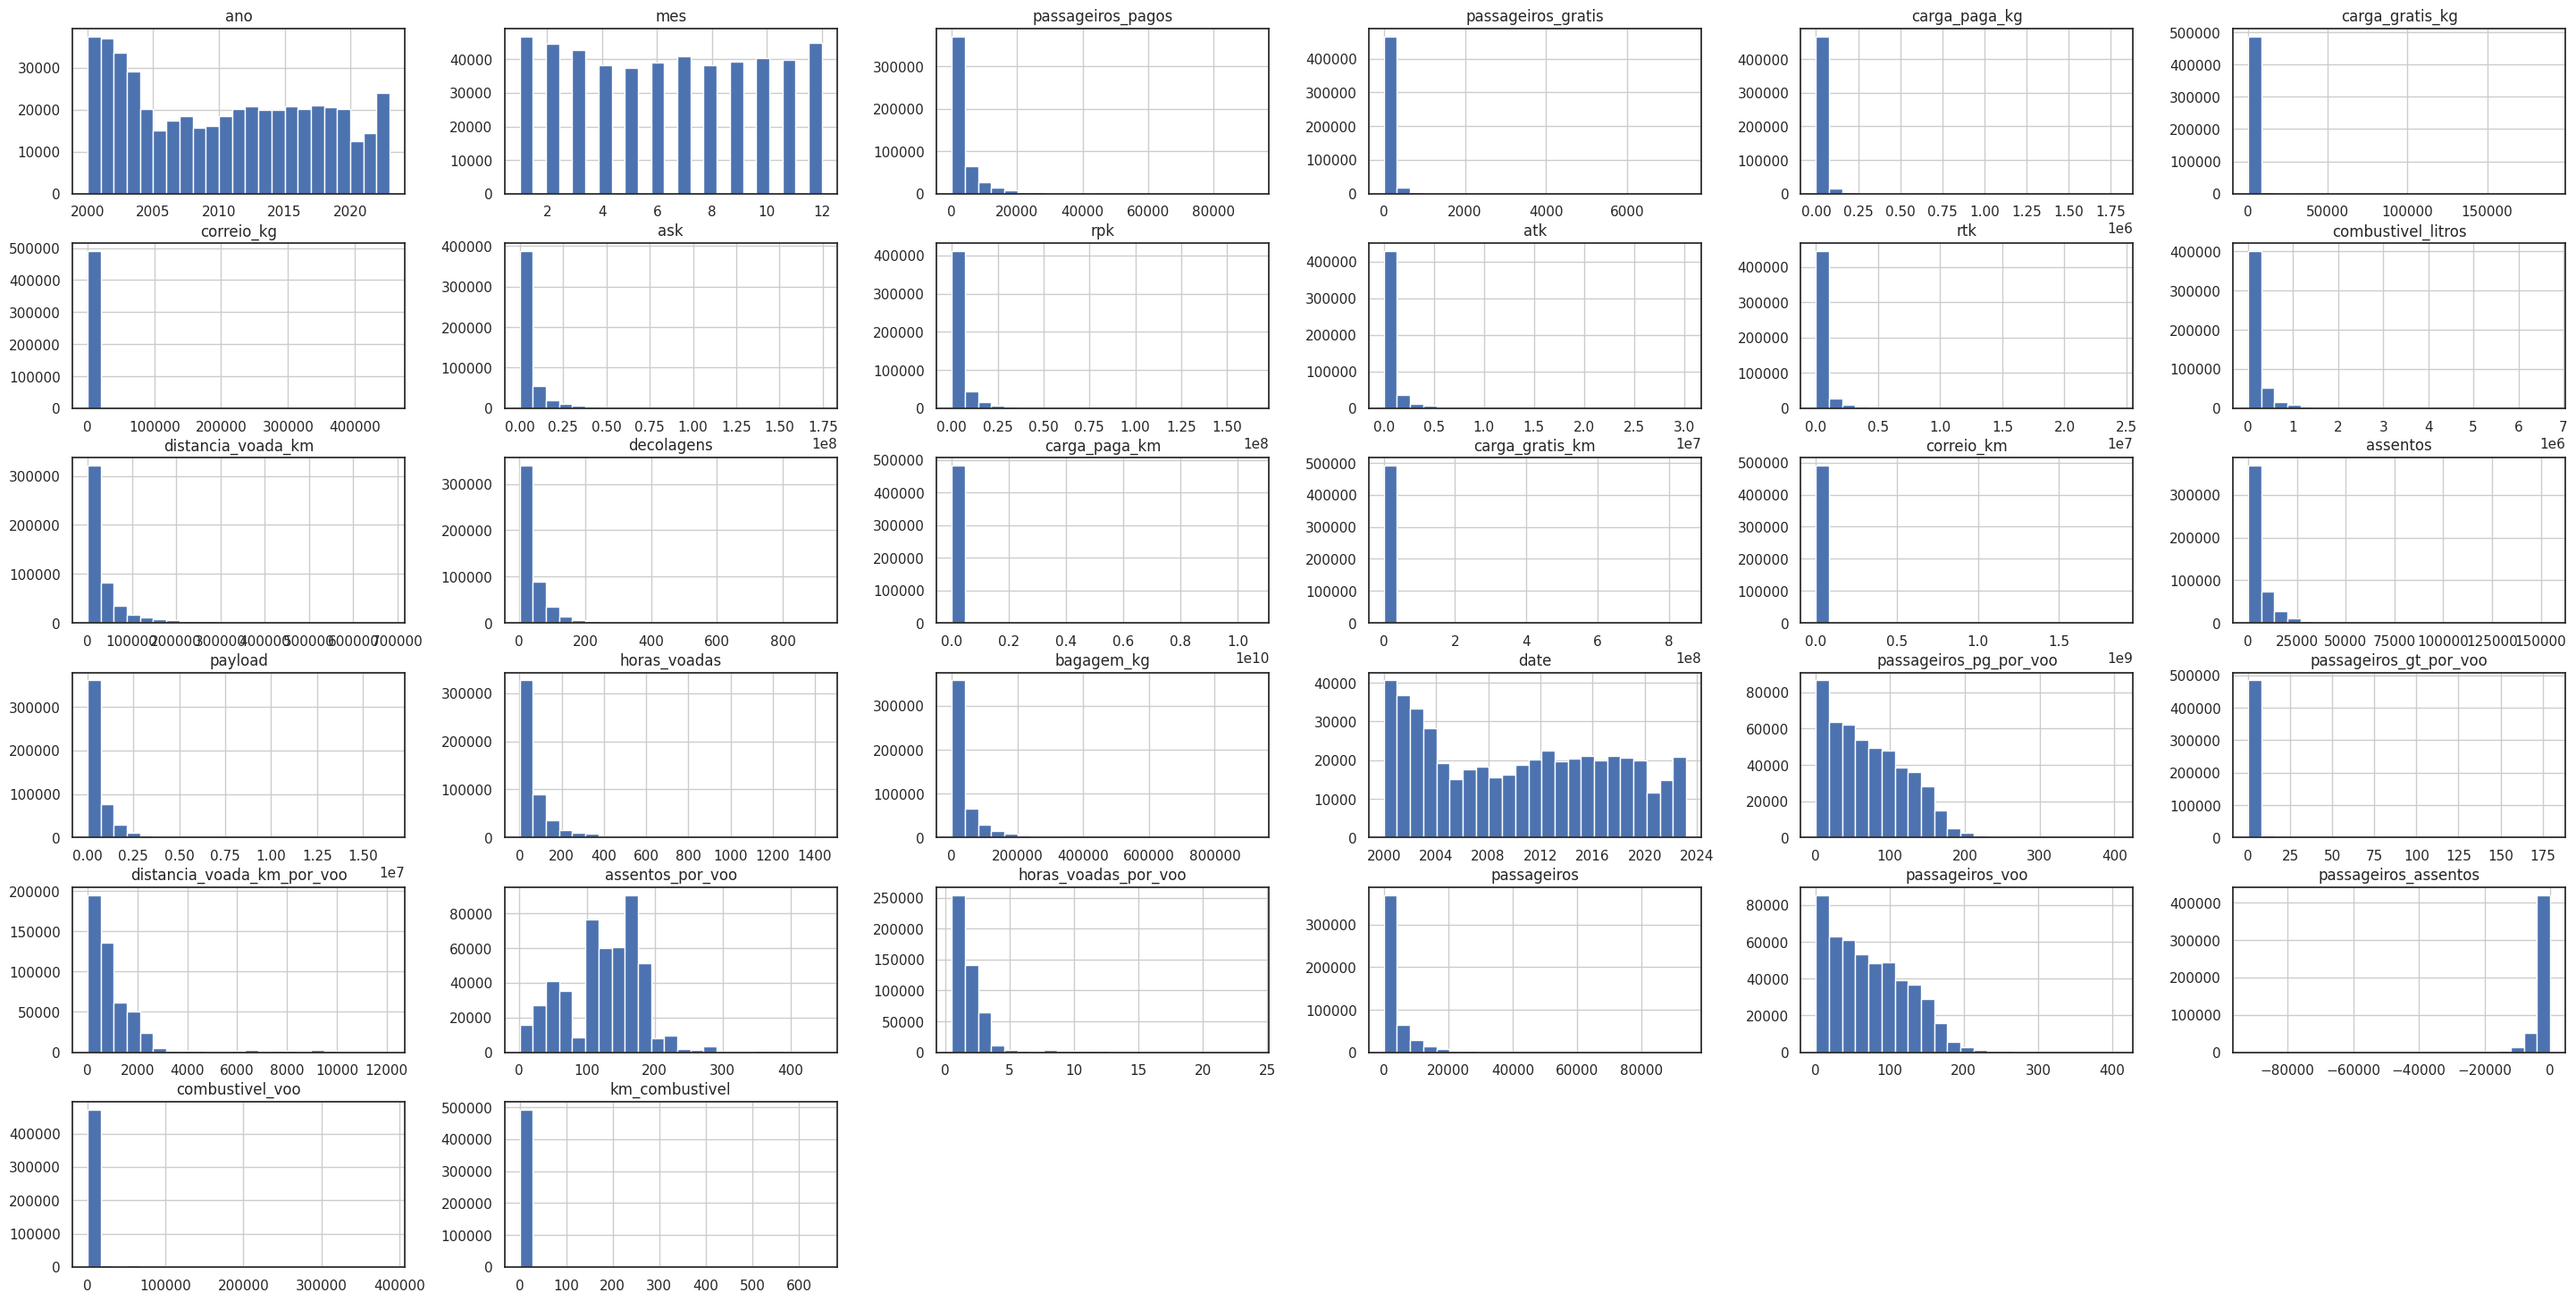

In [28]:
df2.hist(bins=23, figsize=(36,18));

### <font color='darkorange'> 2.1.2. Categorical

In [29]:
df2.select_dtypes(include=['category']).nunique()

empresa_sigla                       44
empresa_nome                        44
empresa_nacionalidade                1
aeroporto_de_origem_sigla          481
aeroporto_de_origem_nome           410
aeroporto_de_origem_uf              27
aeroporto_de_origem_regiao           5
aeroporto_de_origem_pais            49
aeroporto_de_origem_continente       7
aeroporto_de_destino_sigla         502
aeroporto_de_destino_nome          429
aeroporto_de_destino_uf             27
aeroporto_de_destino_regiao          5
aeroporto_de_destino_pais           53
aeroporto_de_destino_continente      6
natureza                             2
grupo_de_voo                         3
dtype: int64

- Existem mais siglas de aeroportos do que nomes de aeroportos
- 8 Continentes?

## <font color='darkorange'> 2.2. Univariate Analysis

In [30]:
#profile = ProfileReport( df2 )
#profile.to_file( 'reports/dados_anac.html' ) 

# Product space too large to allocate -> O data set é muito grande

### <font color='darkorange'> 2.2.1. empresa_sigla


In [31]:
univariate_categorical(df2.empresa_sigla, "sigla")


Numero de sigla: 44

Percentual de sigla: 
TAM   0.25
GLO   0.19
AZU   0.15
VRG   0.07
TIB   0.05
      ... 
FBZ   0.00
FDX   0.00
FNT   0.00
FPO   0.00
XCA   0.00
Name: empresa_sigla, Length: 297, dtype: float64


### <font color='darkorange'> 2.2.2. empresa_nome


In [32]:
univariate_categorical(df2.empresa_nome, "empresas")


Numero de empresas: 44

Percentual de empresas: 
TAM LINHAS AÉREAS S.A.                                        0.25
GOL LINHAS AÉREAS S.A. (EX- VRG LINHAS AÉREAS S.A.)           0.19
AZUL LINHAS AÉREAS BRASILEIRAS S/A                            0.15
VARIG - VIAÇÃO AÉREA RIO-GRANDENSE                            0.07
TRIP SERVIÇOS DE SUPORTE AÉREO S.A (EX. TRIP LINHAS AÉREAS)   0.05
                                                              ... 
DANISH AIR TRANSPORT                                          0.00
DELTA AIR LINES INC.                                          0.00
DEUTSCHE LUFTHANSA A.G.                                       0.00
DINAR LÍNEAS AEREAS                                           0.00
WORLD AIRWAYS INC                                             0.00
Name: empresa_nome, Length: 297, dtype: float64


### <font color='darkorange'> 2.2.3. empresa_nacionalidade


In [33]:
univariate_categorical(df2.empresa_nacionalidade, "nacionalidade")


Numero de nacionalidade: 1

Percentual de nacionalidade: 
BRASILEIRA    1.00
ESTRANGEIRA   0.00
Name: empresa_nacionalidade, dtype: float64


### <font color='darkorange'> 2.2.4. ano


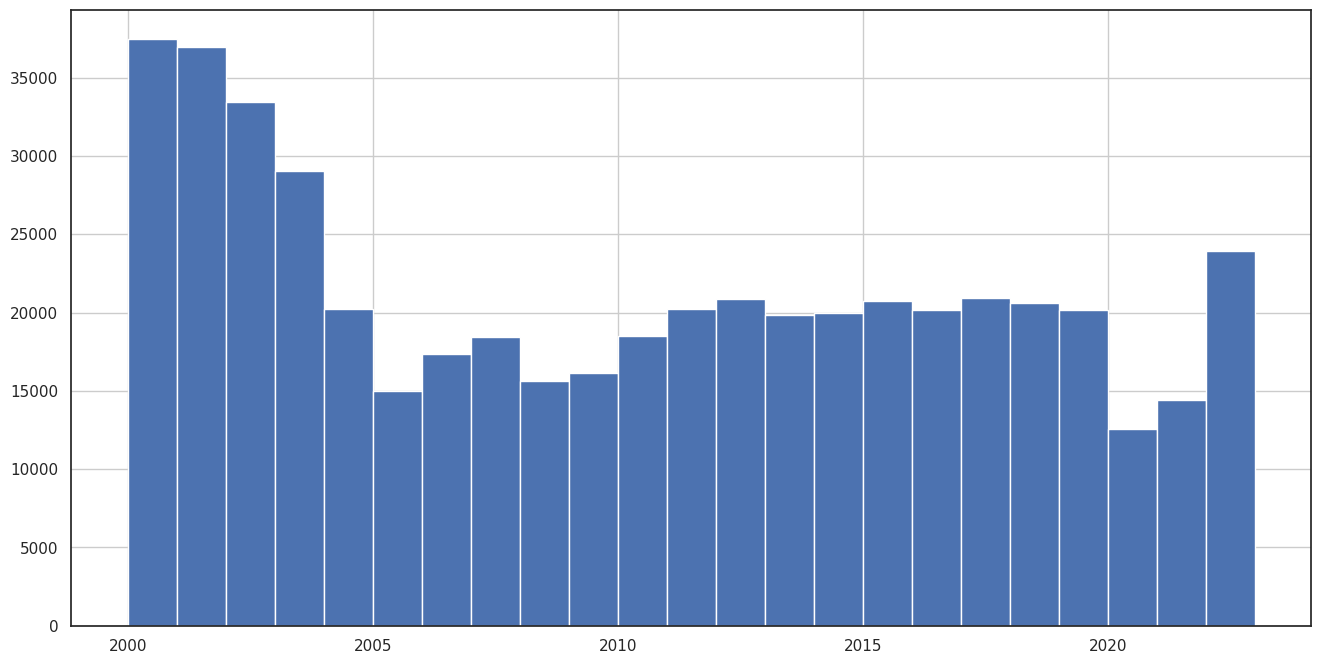

In [34]:
df2.ano.hist(bins=23);

- Tendencia de queda no numero de registros ao longo dos anos

### <font color='darkorange'> 2.2.5. mes


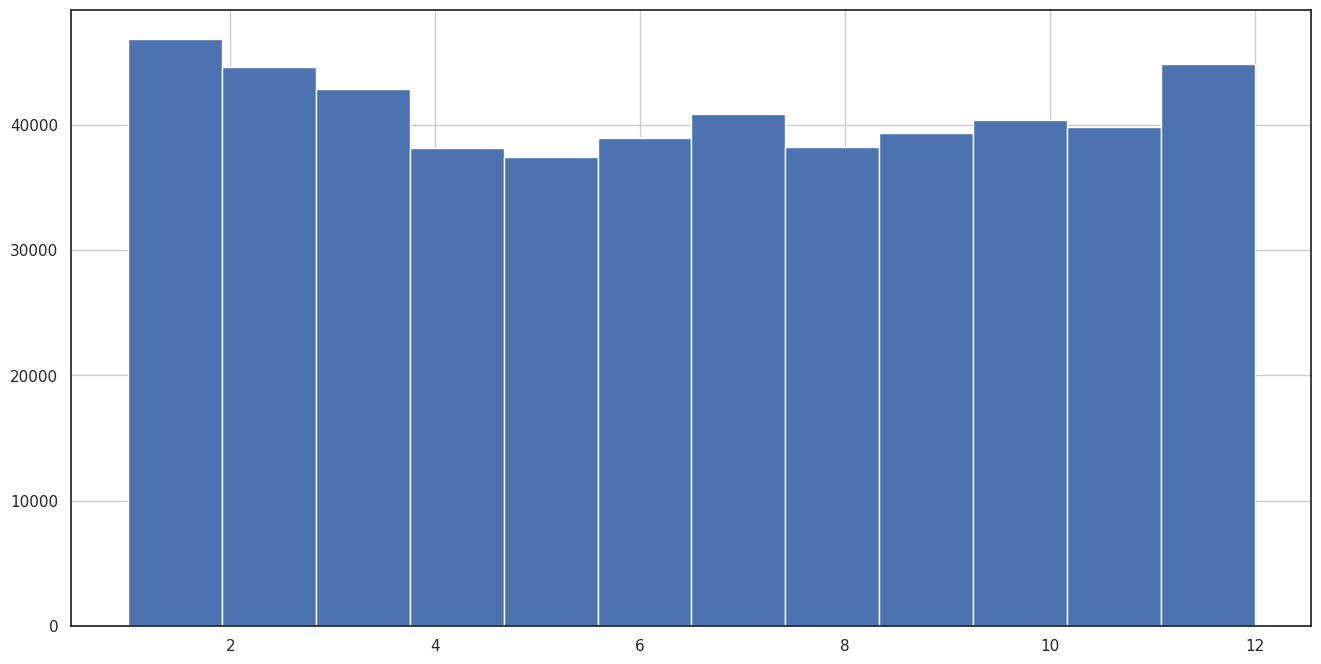

In [35]:
df2.mes.hist(bins=12);

### <font color='darkorange'> 2.2.6. aeroporto_de_origem_sigla


In [36]:
univariate_categorical(df2.aeroporto_de_origem_sigla, "sigla aeroporto origem")


Numero de sigla aeroporto origem: 481

Percentual de sigla aeroporto origem: 
SBGR   0.08
SBBR   0.06
SBSP   0.05
SBGL   0.04
SBSV   0.04
       ... 
SBPN   0.00
HUEN   0.00
HTKJ   0.00
HSSS   0.00
ZUUU   0.00
Name: aeroporto_de_origem_sigla, Length: 1053, dtype: float64


### <font color='darkorange'> 2.2.7. aeroporto_de_origem_nome


In [37]:
univariate_categorical(df2.aeroporto_de_origem_nome, "aeroporto nome")


Numero de aeroporto nome: 410

Percentual de aeroporto nome: 
GUARULHOS               0.08
RIO DE JANEIRO          0.07
BRASÍLIA                0.06
SÃO PAULO               0.05
SALVADOR                0.04
                        ... 
KANSAS CITY, MISSOURI   0.00
KAOHSIUNG CITY          0.00
KARACHI                 0.00
KARAGANDA               0.00
ÖREBRO                  0.00
Name: aeroporto_de_origem_nome, Length: 923, dtype: float64


### <font color='darkorange'> 2.2.8. aeroporto_de_origem_uf


In [38]:
univariate_categorical(df2.aeroporto_de_origem_uf, "estado origem")


Numero de estado origem: 27

Percentual de estado origem: 
SP   0.21
BA   0.08
MG   0.07
RJ   0.07
DF   0.06
PA   0.06
PR   0.06
AM   0.05
PE   0.04
RS   0.04
CE   0.03
SC   0.03
MT   0.03
GO   0.02
RN   0.02
AL   0.02
MS   0.01
ES   0.01
MA   0.01
RO   0.01
SE   0.01
AC   0.01
PI   0.01
PB   0.01
AP   0.01
TO   0.01
RR   0.00
     0.00
Name: aeroporto_de_origem_uf, dtype: float64


### <font color='darkorange'> 2.2.9. aeroporto_de_origem_regiao


In [39]:
univariate_categorical(df2.aeroporto_de_origem_regiao, "regiao origem")


Numero de regiao origem: 5

Percentual de regiao origem: 
SUDESTE        0.37
NORDESTE       0.23
NORTE          0.15
SUL            0.13
CENTRO-OESTE   0.12
               0.00
Name: aeroporto_de_origem_regiao, dtype: float64


### <font color='darkorange'> 2.2.10. aeroporto_de_origem_pais


In [40]:
univariate_categorical(df2.aeroporto_de_origem_pais, "pais origem")


Numero de pais origem: 49

Percentual de pais origem: 
BRASIL                      0.95
ARGENTINA                   0.01
ESTADOS UNIDOS DA AMÉRICA   0.01
URUGUAI                     0.00
CHILE                       0.00
                            ... 
GUINÉ                       0.00
GUATEMALA                   0.00
GUAM                        0.00
GRÉCIA                      0.00
ÍNDIA                       0.00
Name: aeroporto_de_origem_pais, Length: 146, dtype: float64


### <font color='darkorange'> 2.2.11. aeroporto_de_origem_continente


In [41]:
univariate_categorical(df2.aeroporto_de_origem_continente, "origem continente")


Numero de origem continente: 7

Percentual de origem continente: 
AMÉRICA DO SUL     0.98
EUROPA             0.01
AMÉRICA DO NORTE   0.01
AMÉRICA CENTRAL    0.00
ÁSIA               0.00
ÁFRICA             0.00
NÃO IDENTIFICADO   0.00
OCEANIA            0.00
Name: aeroporto_de_origem_continente, dtype: float64


### <font color='darkorange'> 2.2.12. aeroporto_de_destino_sigla


In [42]:
univariate_categorical(df2.aeroporto_de_destino_sigla, "sigla destino")


Numero de sigla destino: 502

Percentual de sigla destino: 
SBGR   0.09
SBBR   0.06
SBSP   0.05
SBGL   0.05
SBSV   0.04
       ... 
KAUS   0.00
KAUH   0.00
KARG   0.00
KAFW   0.00
ZWTP   0.00
Name: aeroporto_de_destino_sigla, Length: 1083, dtype: float64


### <font color='darkorange'> 2.2.13. aeroporto_de_destino_nome


In [43]:
univariate_categorical(df2.aeroporto_de_destino_nome, "nome destino")


Numero de nome destino: 429

Percentual de nome destino: 
GUARULHOS                     0.09
RIO DE JANEIRO                0.07
BRASÍLIA                      0.06
SÃO PAULO                     0.05
SALVADOR                      0.04
                              ... 
NOUAKCHOTT, MAURITÂNIA        0.00
NOUAKCHOTT                    0.00
NORWICH, ENGLAND              0.00
FLESLAND, BERGEN, HORDALAND   0.00
LITTLE ROCK, ARKANSAS         0.00
Name: aeroporto_de_destino_nome, Length: 951, dtype: float64


### <font color='darkorange'> 2.2.14. aeroporto_de_destino_uf


In [44]:
univariate_categorical(df2.aeroporto_de_destino_uf, "estado destino")


Numero de estado destino: 27

Percentual de estado destino: 
SP   0.22
BA   0.08
MG   0.07
RJ   0.07
DF   0.06
PA   0.06
PR   0.06
AM   0.05
PE   0.04
RS   0.04
SC   0.03
CE   0.03
MT   0.03
GO   0.02
RN   0.02
AL   0.02
MS   0.01
ES   0.01
MA   0.01
RO   0.01
SE   0.01
PB   0.01
AC   0.01
PI   0.01
AP   0.01
TO   0.01
RR   0.00
     0.00
Name: aeroporto_de_destino_uf, dtype: float64


### <font color='darkorange'> 2.2.15. aeroporto_de_destino_regiao


In [45]:
univariate_categorical(df2.aeroporto_de_destino_regiao, "regiao destino")


Numero de regiao destino: 5

Percentual de regiao destino: 
SUDESTE        0.38
NORDESTE       0.22
NORTE          0.15
CENTRO-OESTE   0.12
SUL            0.12
               0.00
Name: aeroporto_de_destino_regiao, dtype: float64


### <font color='darkorange'> 2.2.16. aeroporto_de_destino_pais


In [46]:
univariate_categorical(df2.aeroporto_de_destino_pais, "pais destino")


Numero de pais destino: 53

Percentual de pais destino: 
BRASIL                      0.96
ARGENTINA                   0.01
ESTADOS UNIDOS DA AMÉRICA   0.01
URUGUAI                     0.00
CHILE                       0.00
                            ... 
HONG KONG                   0.00
GÂMBIA                      0.00
GUINÉ EQUATORIAL            0.00
GUAM                        0.00
ÍNDIA                       0.00
Name: aeroporto_de_destino_pais, Length: 150, dtype: float64


### <font color='darkorange'> 2.2.17. aeroporto_de_destino_continente


In [47]:
univariate_categorical(df2.aeroporto_de_destino_continente, "continente destino")


Numero de continente destino: 6

Percentual de continente destino: 
AMÉRICA DO SUL     0.98
EUROPA             0.01
AMÉRICA DO NORTE   0.01
AMÉRICA CENTRAL    0.00
ÁSIA               0.00
ÁFRICA             0.00
NÃO IDENTIFICADO   0.00
OCEANIA            0.00
Name: aeroporto_de_destino_continente, dtype: float64


### <font color='darkorange'> 2.2.18. natureza


In [48]:
univariate_categorical(df2.natureza, "naturezas")


Numero de naturezas: 2

Percentual de naturezas: 
DOMÉSTICA       0.92
INTERNACIONAL   0.08
Name: natureza, dtype: float64


### <font color='darkorange'> 2.2.19. grupo_de_voo


In [49]:
univariate_categorical(df2.grupo_de_voo, "grupos de voo")


Numero de grupos de voo: 3

Percentual de grupos de voo: 
REGULAR            0.75
NÃO REGULAR        0.25
IMPRODUTIVO        0.00
NÃO IDENTIFICADO   0.00
Name: grupo_de_voo, dtype: float64


- Utilizaremos para as previsões somente voos regulares

### <font color='darkorange'> 2.2.20. passageiros_pagos


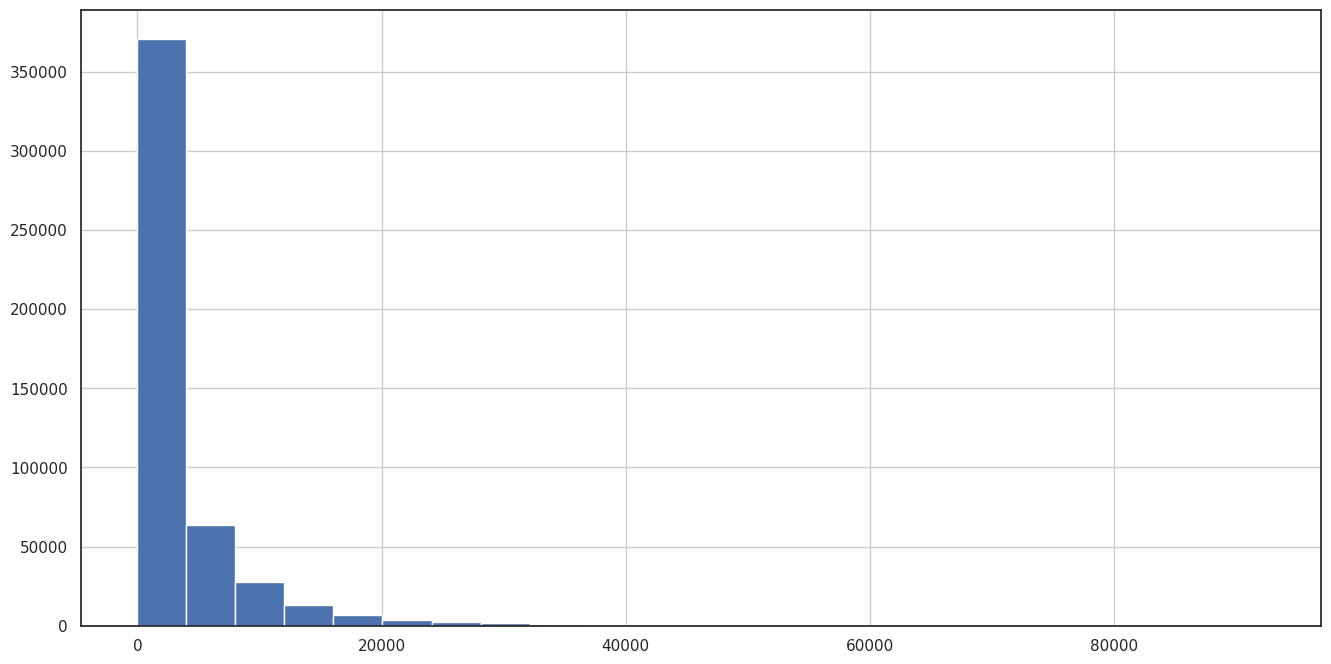

In [50]:
df2.passageiros_pagos.hist(bins=23);

- A maioria dos registros está dentro dos valores 0 e 4000.

### <font color='darkorange'> 2.2.21. passageiros_gratis


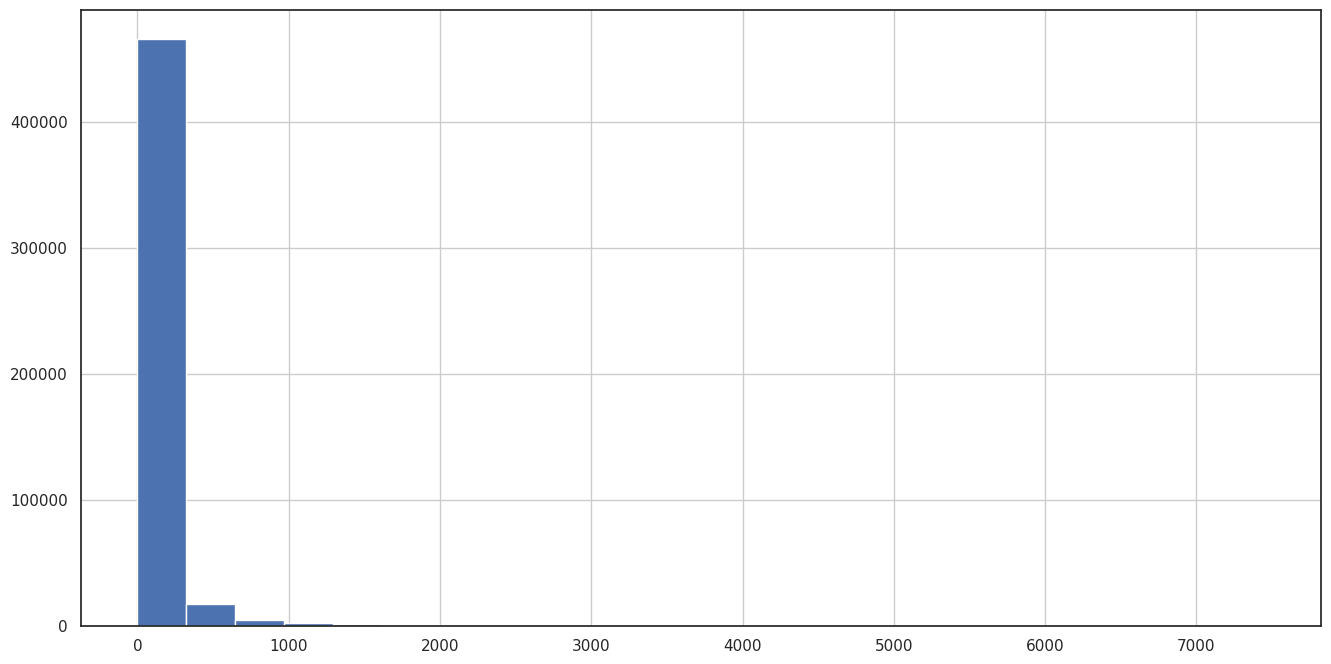

In [51]:
df2.passageiros_gratis.hist(bins=23);

### <font color='darkorange'> 2.2.22. carga_paga_kg


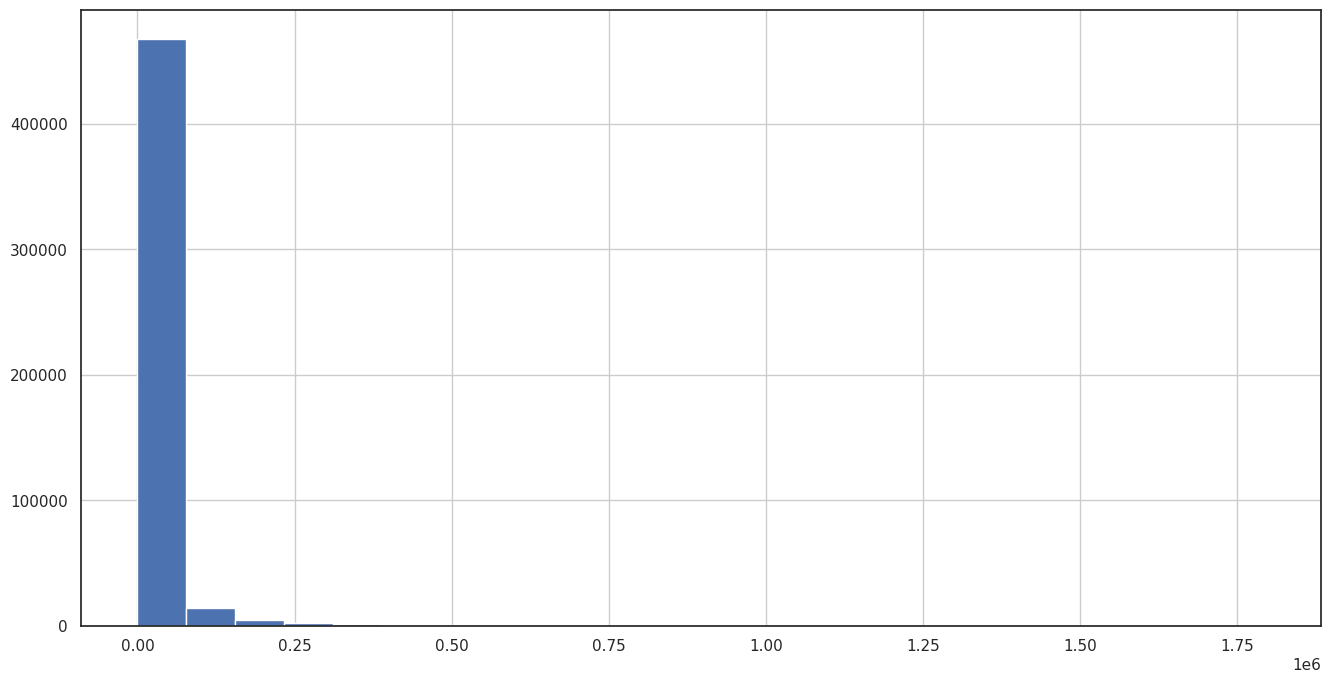

In [52]:
df2.carga_paga_kg.hist(bins=23);

### <font color='darkorange'> 2.2.23. carga_gratis_kg


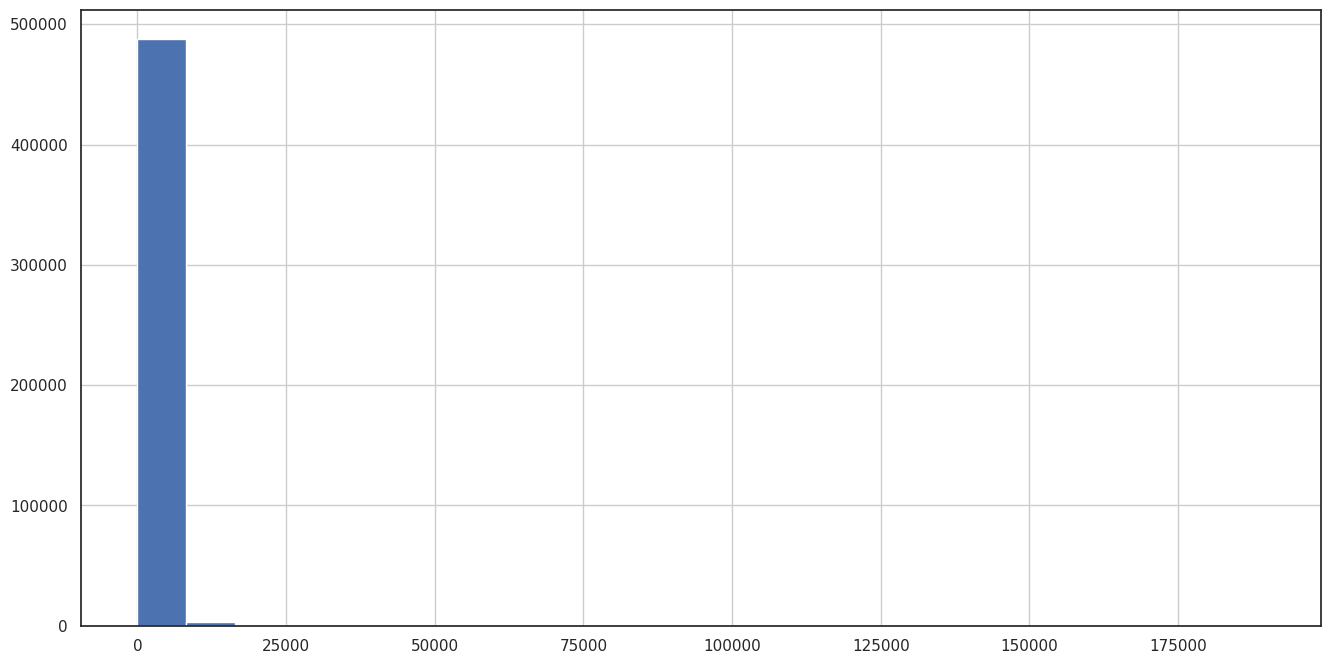

In [53]:
df2.carga_gratis_kg.hist(bins=23);

### <font color='darkorange'> 2.2.24. correio_kg


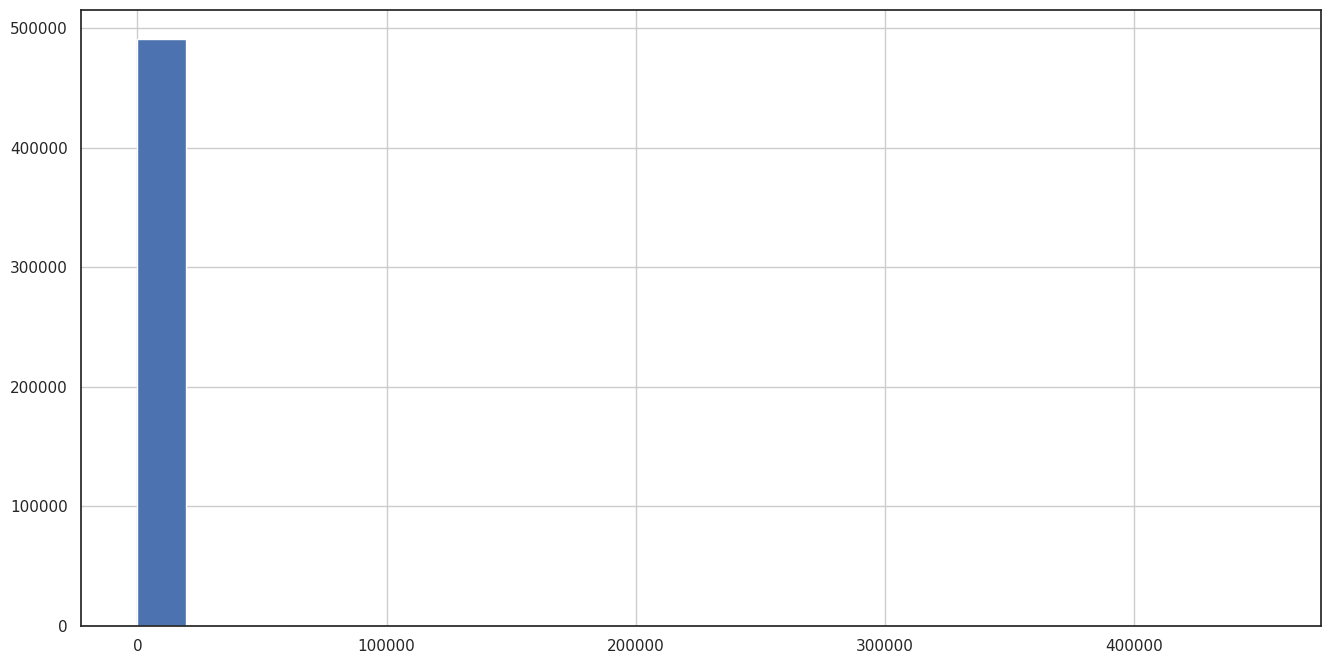

In [54]:
df2.correio_kg.hist(bins=23);

### <font color='darkorange'> 2.2.25. ask


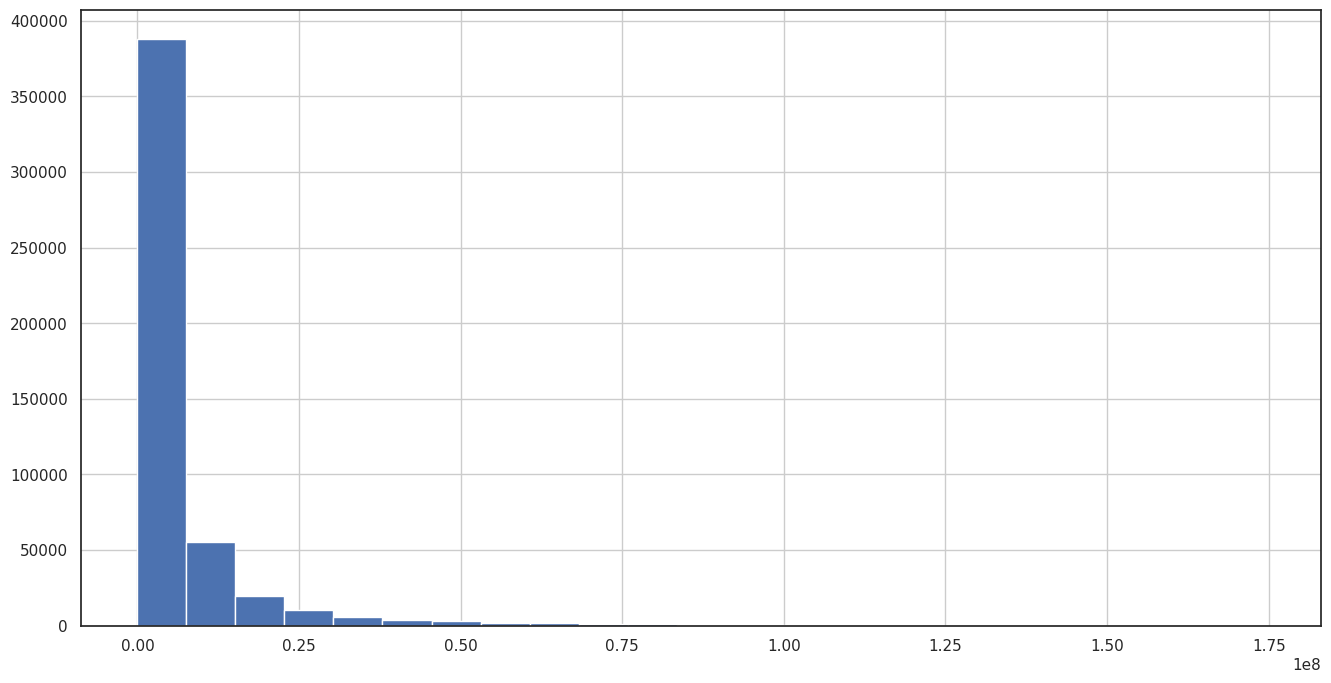

In [55]:
df2.ask.hist(bins=23);

### <font color='darkorange'> 2.2.26. rpk


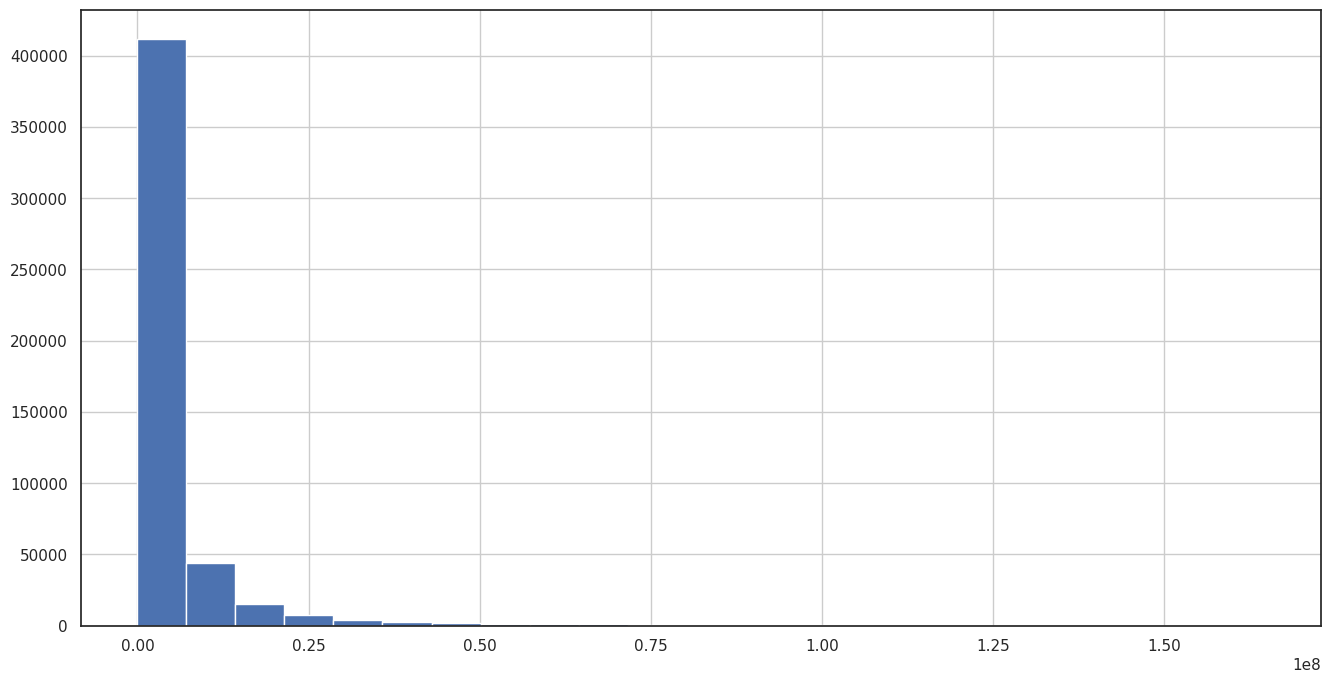

In [56]:
df2.rpk.hist(bins=23);

### <font color='darkorange'> 2.2.27. atk


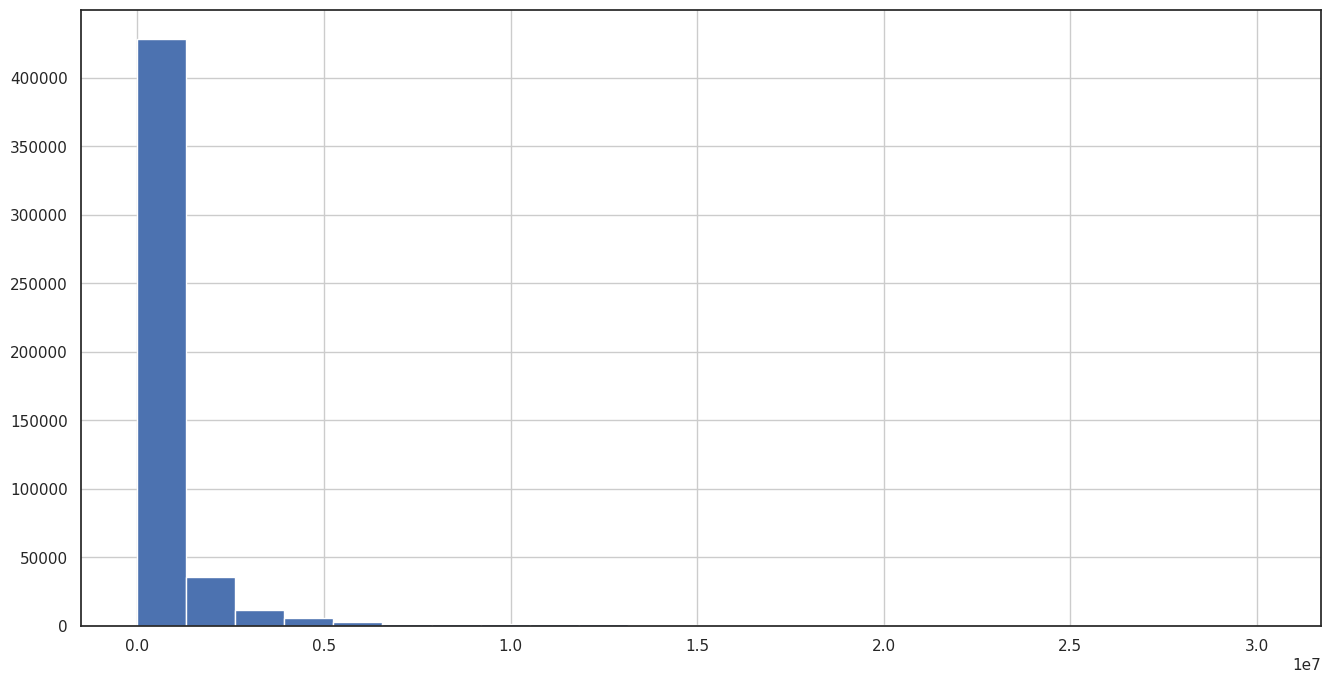

In [57]:
df2.atk.hist(bins=23);


### <font color='darkorange'> 2.2.28. rtk


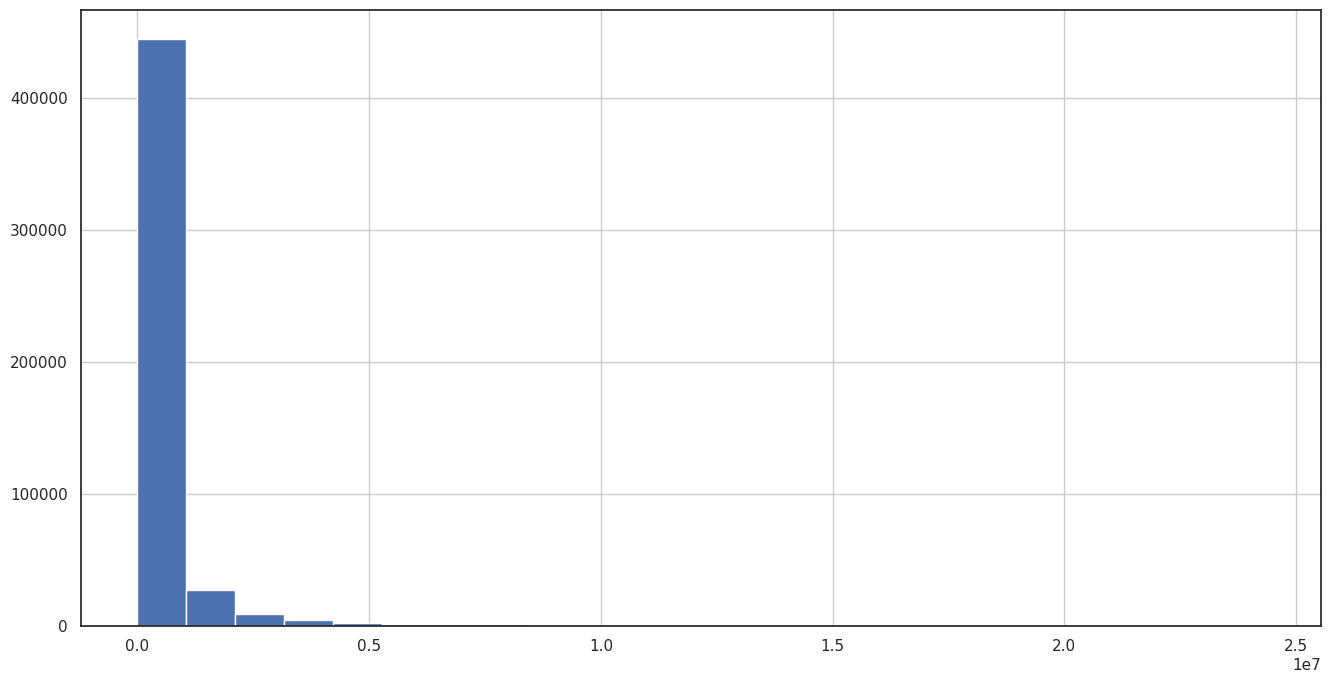

In [58]:
df2.rtk.hist(bins=23);


### <font color='darkorange'> 2.2.29. combustivel_litros


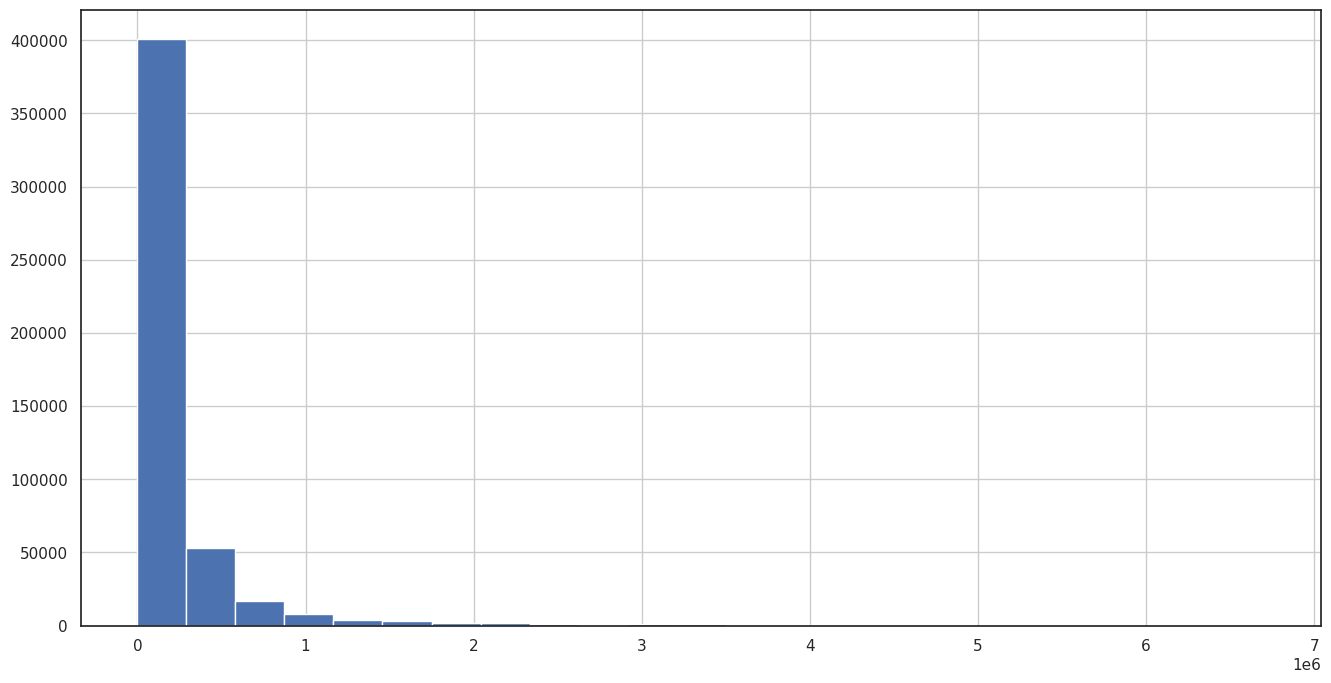

In [59]:
df2.combustivel_litros.hist(bins=23);


### <font color='darkorange'> 2.2.30. distancia_voada_km


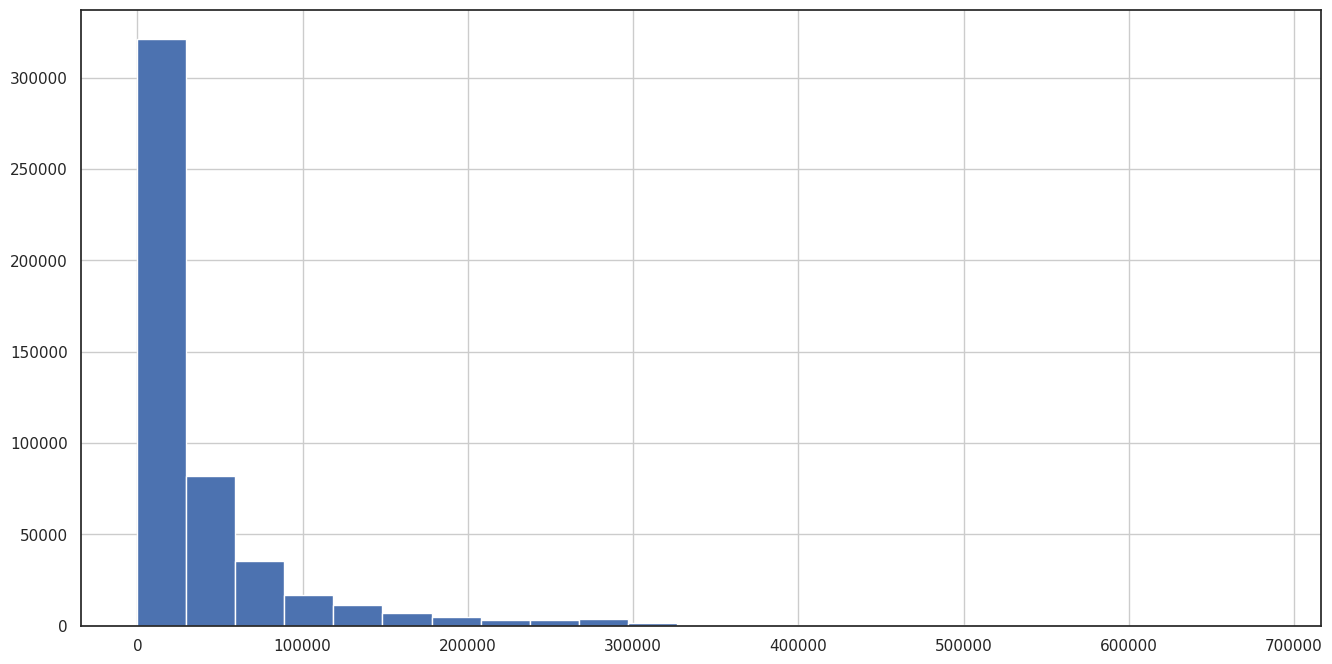

In [60]:
df2.distancia_voada_km.hist(bins=23);


### <font color='darkorange'> 2.2.31. decolagens


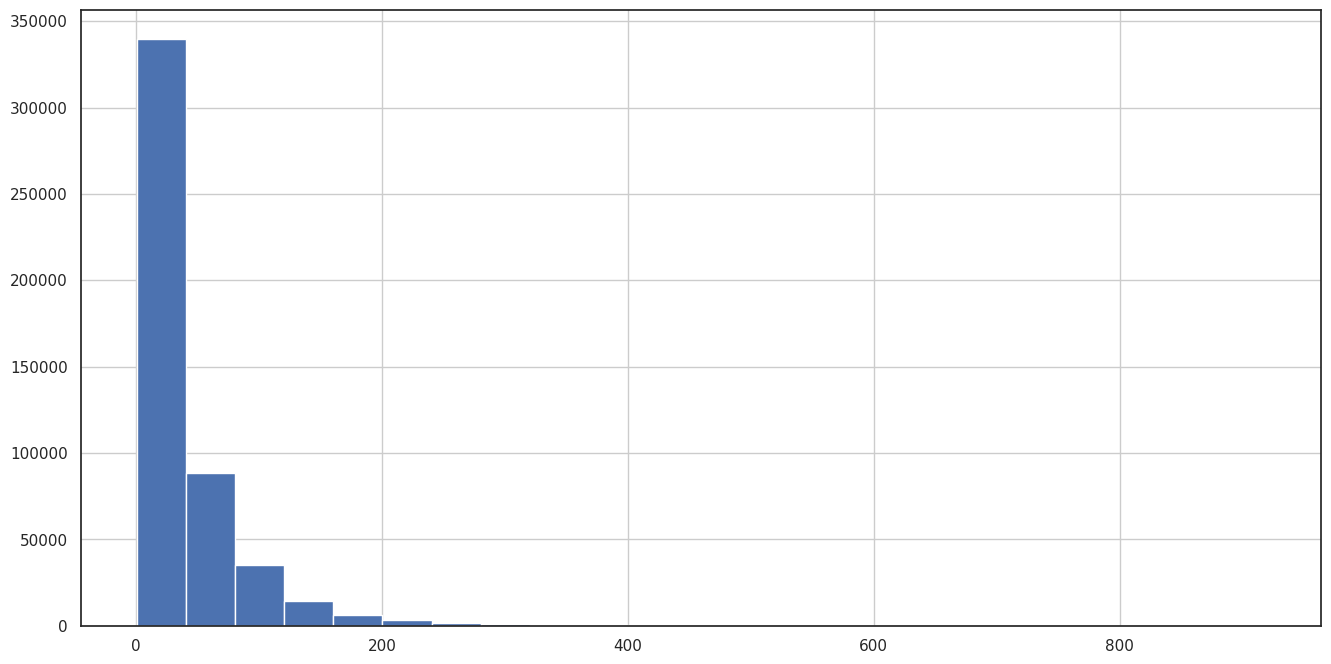

In [61]:
df2.decolagens.hist(bins=23);


In [62]:
df2.decolagens.max()/30

30.6

- Existem casos de mais de 800 decolagens em um mes, o maior registro tem mais 30 voos por dia, algo que parece praticamente impossivel.

### <font color='darkorange'> 2.2.32. carga_paga_km


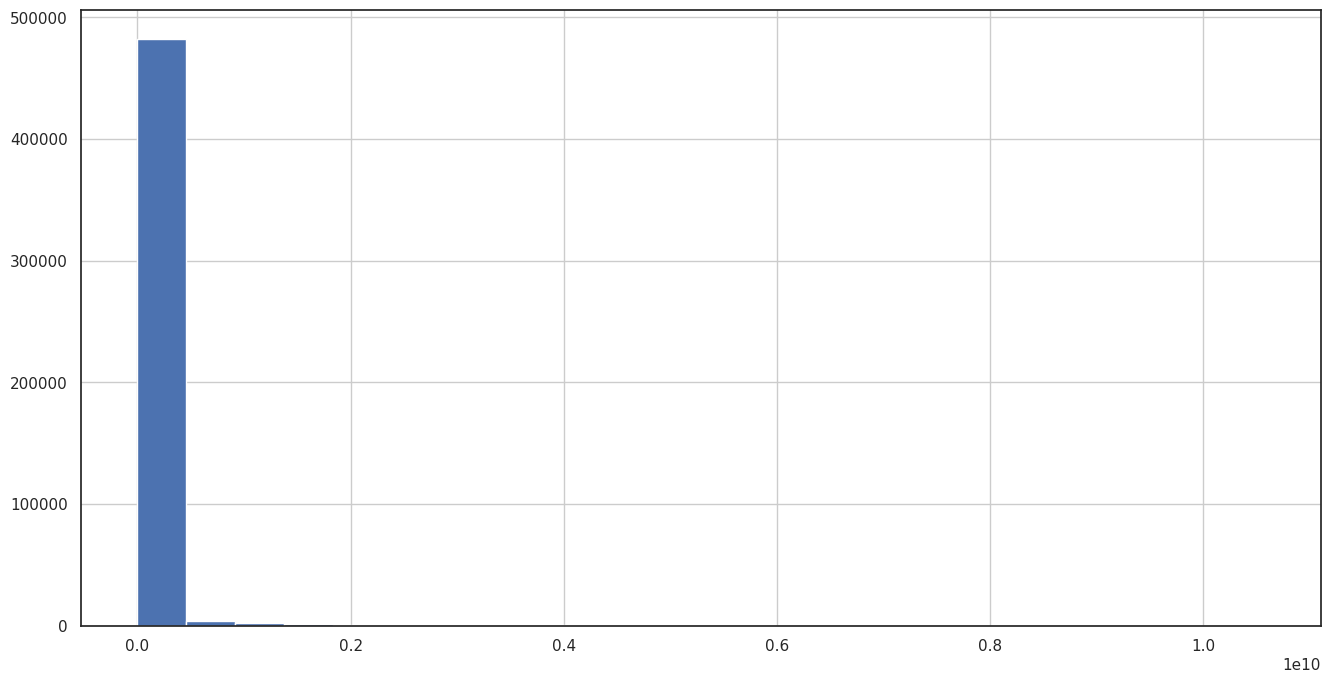

In [63]:
df2.carga_paga_km.hist(bins=23);

### <font color='darkorange'> 2.2.33. carga_gratis_km


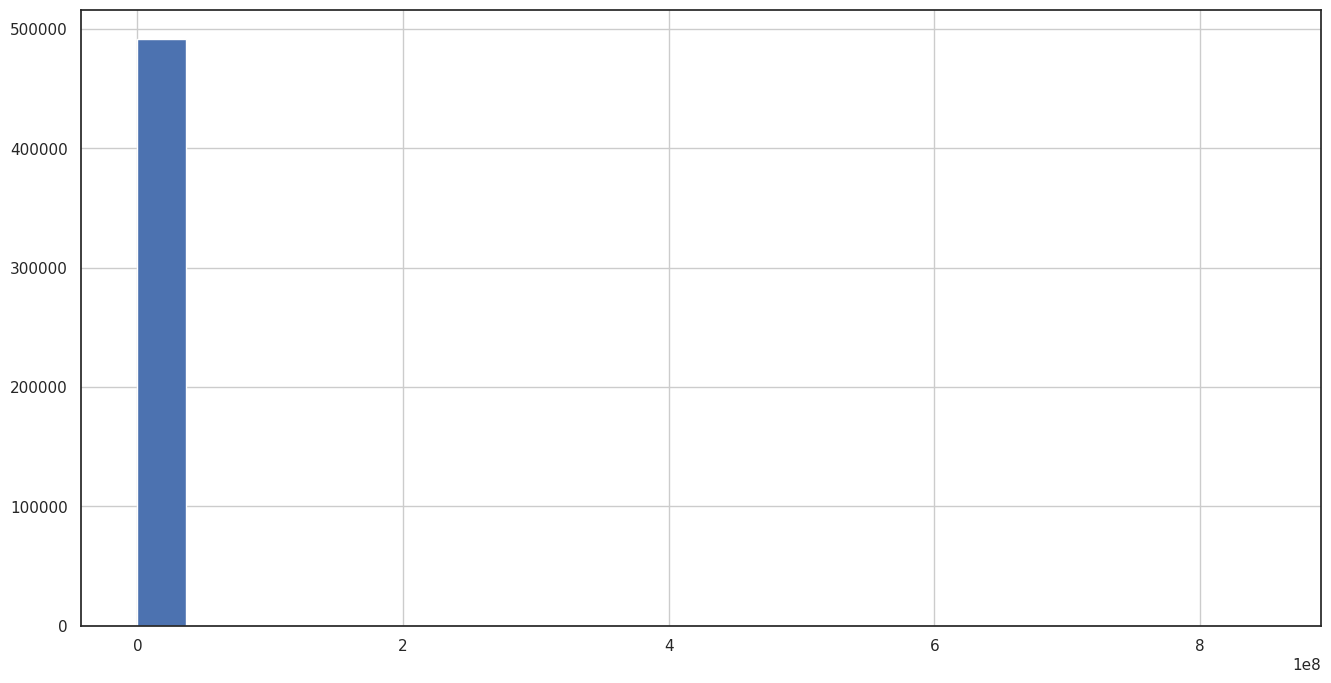

In [64]:
df2.carga_gratis_km.hist(bins=23);


### <font color='darkorange'> 2.2.34. correio_km


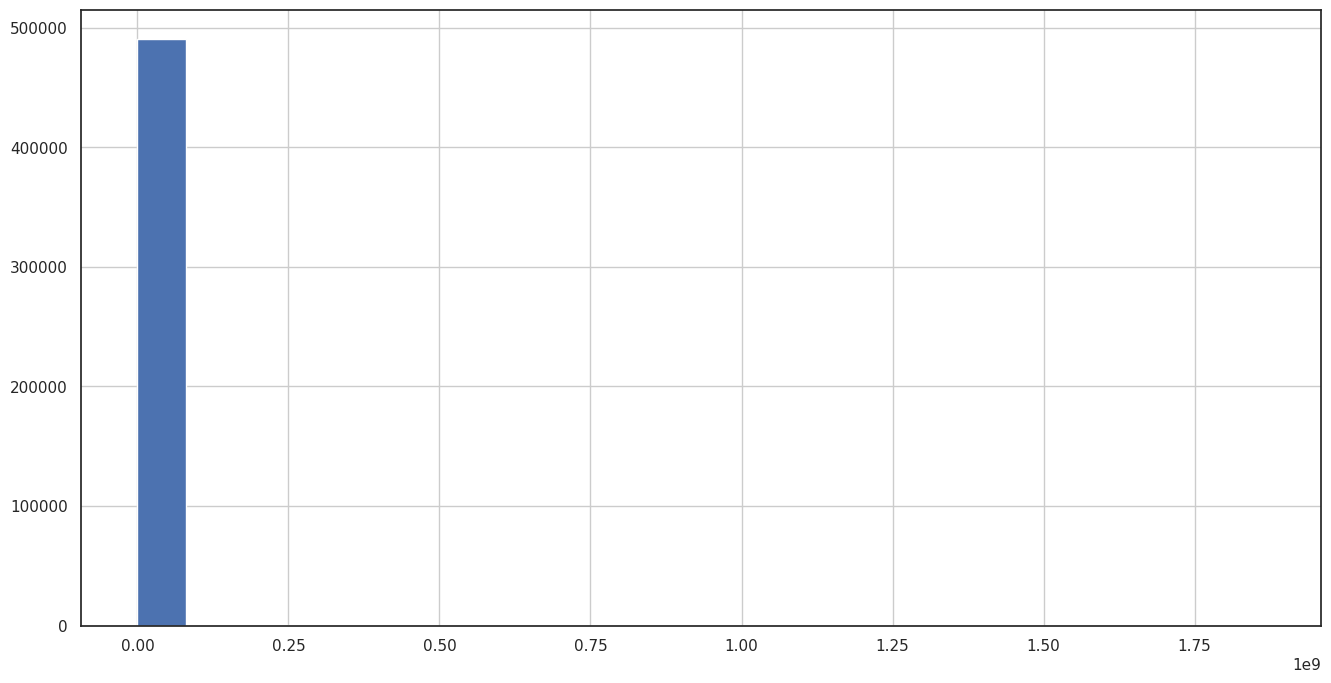

In [65]:
df2.correio_km.hist(bins=23);


### <font color='darkorange'> 2.2.35. assentos


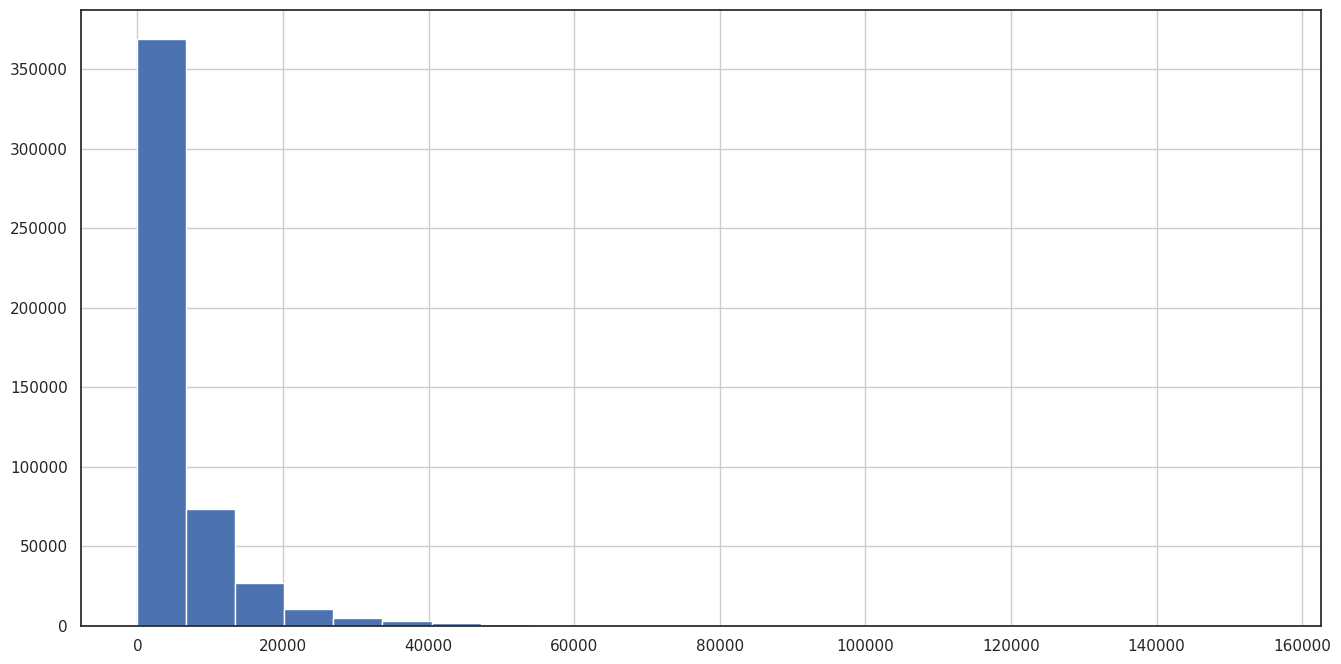

In [66]:
df2.assentos.hist(bins=23);


- A maioria dos dados de assentos disponiveis esta entre 0 e 666.
- Existem registros com 0 assentos.

### <font color='darkorange'> 2.2.36. payload


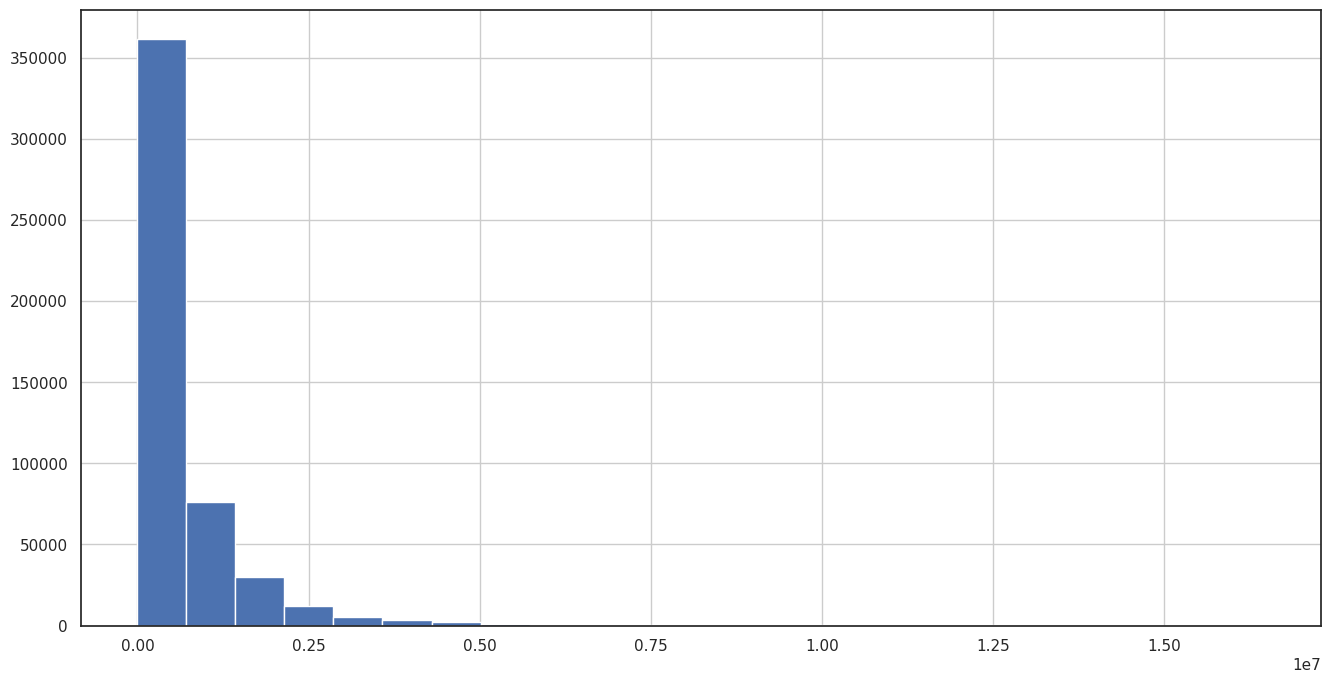

In [67]:
df2.payload.hist(bins=23);


### <font color='darkorange'> 2.2.37. horas_voadas


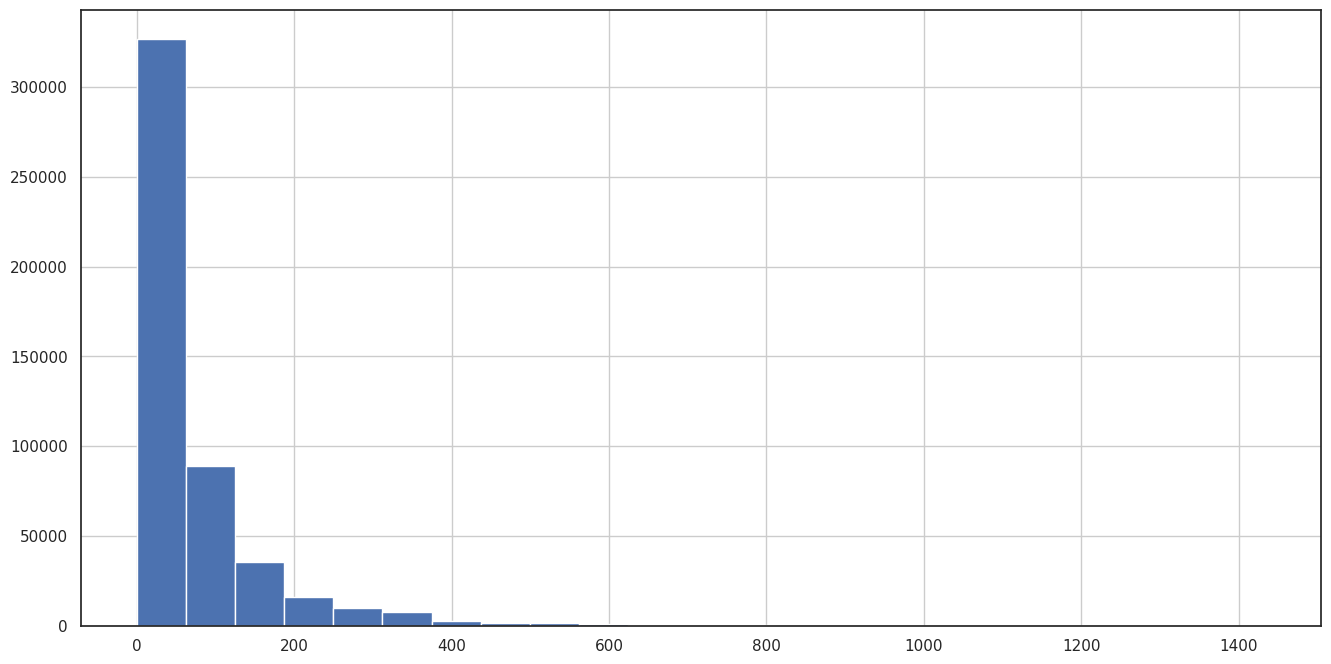

In [68]:
df2.horas_voadas.hist(bins=23);

- Existem registros de voos com 0 horas

### <font color='darkorange'> 2.2.38. bagagem_kg


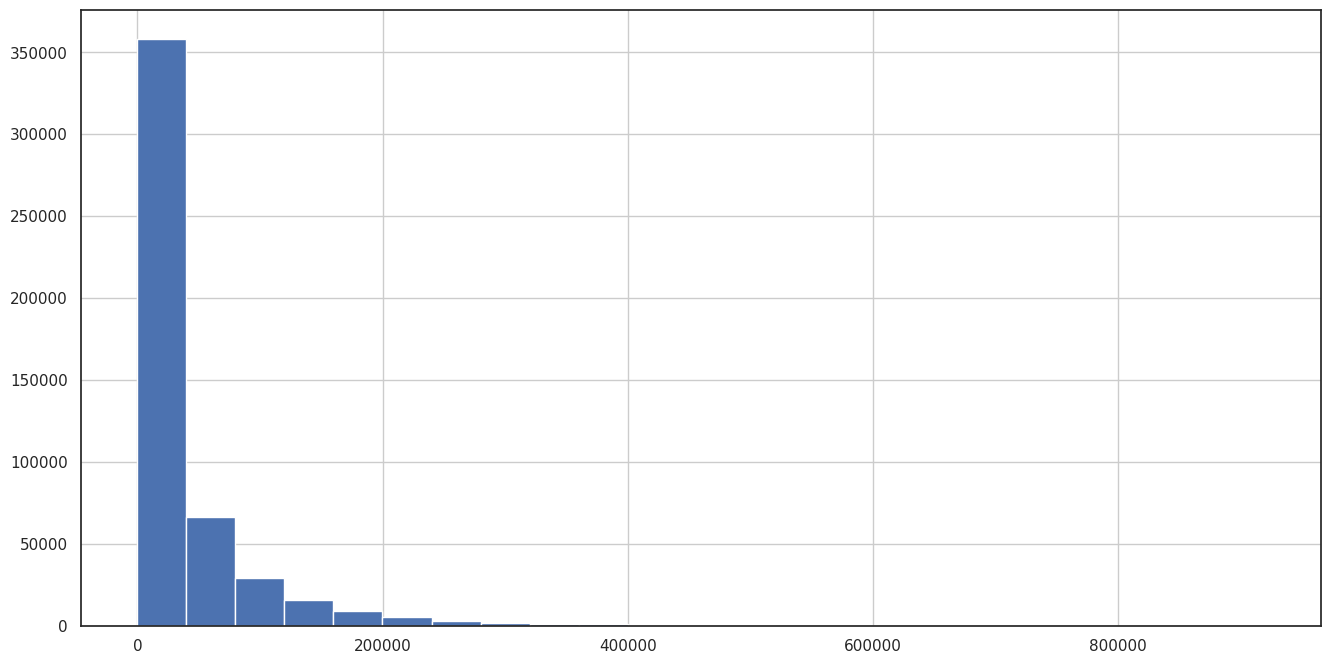

In [69]:
df2.bagagem_kg.hist(bins=23);

### <font color='darkorange'> 2.2.39. n_passageiros


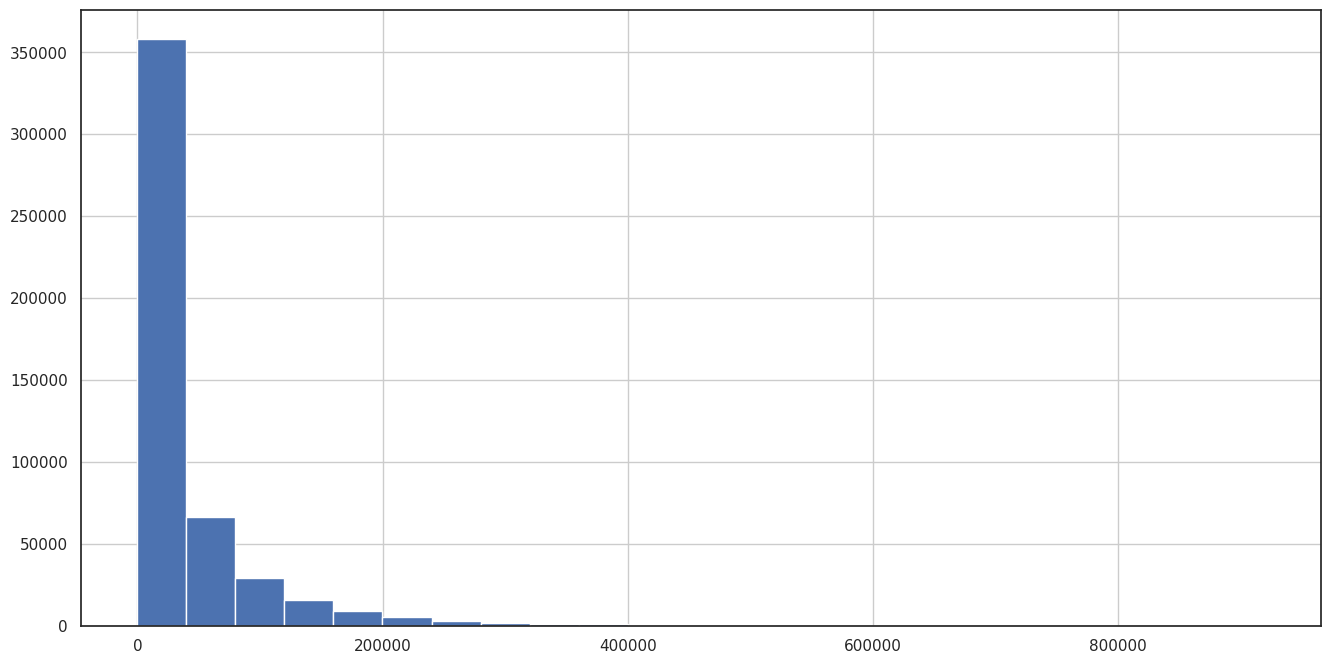

In [70]:
df2.bagagem_kg.hist(bins=23);

### <font color='darkorange'> 2.2.39. rota


In [71]:
univariate_categorical(df2.rota,'rotas')

Numero de rotas: 5253

Percentual de rotas: 
SBRJ - SBSP   0.00
SBSP - SBRJ   0.00
SBGR - SBSV   0.00
SBMQ - SBBE   0.00
SBGL - SBGR   0.00
              ... 
SBNT - SBKG   0.00
SBKG - SBNT   0.00
SBPS - SBKG   0.00
LLBG - LEMD   0.00
SBVC - SBGL   0.00
Name: rota, Length: 5253, dtype: float64


In [72]:
df2.to_parquet('data/df2.parquet')

# <font color='darkorange'>3.0. Market Analysis

## <font color='darkorange'>3.1. Qual companhia aérea possui maior quantidade de passageiros vendidos? Isso vale para todos os anos?

<font color='darkorange'> **TOP5 Empresas por numero de vendas**

In [73]:
aux1 = df2.groupby('empresa_nome')[['passageiros_pagos']].sum().sort_values('passageiros_pagos', ascending=False).reset_index().head(10)
aux1.empresa_nome = aux1.empresa_nome.astype(str).str.replace(r'\(.*?\)', '')

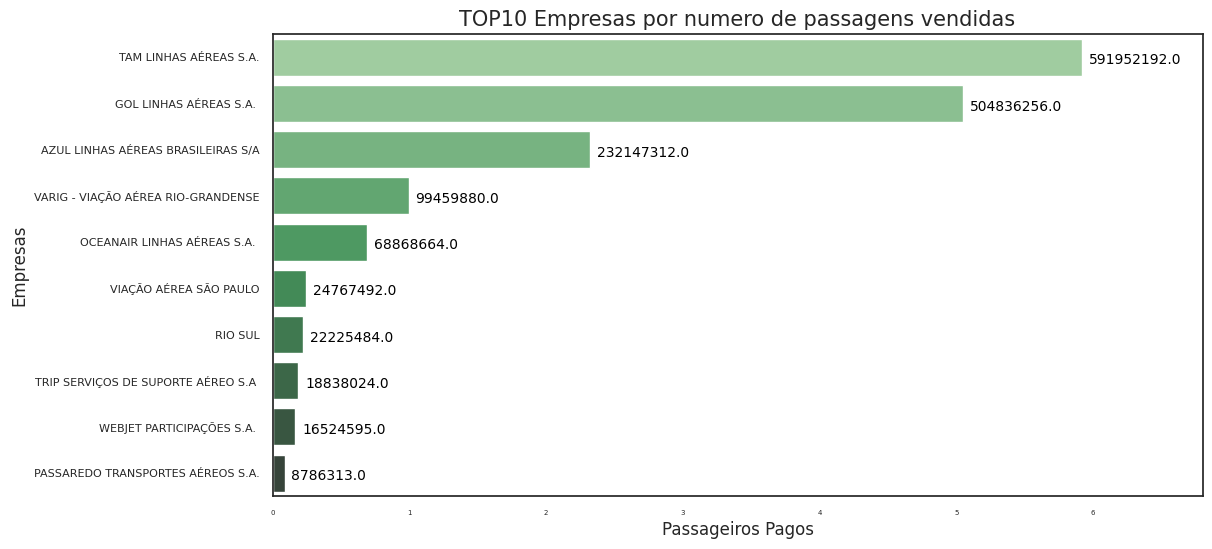

In [74]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="passageiros_pagos", y="empresa_nome", data=aux1, palette="Greens_d")
plt.xlabel('Passageiros Pagos')
plt.ylabel('Empresas')
plt.title('TOP10 Empresas por numero de passagens vendidas', fontsize=15);
plt.xlim(0,(10**9 - ((10**8)*3.2)))
ax.set_xticklabels(ax.get_xticklabels(), fontsize=5);
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8, rotation=0);
for i, row in aux1.iterrows():
    ax.annotate(format(row['passageiros_pagos']),  # Valor formatado com vírgulas
                xy=(row['passageiros_pagos'], i),  # Coordenadas da anotação
                xytext=(5, -5),  # Deslocamento da anotação em relação à coordenada
                textcoords='offset points',  # Sistema de coordenadas para a anotação
                ha='left',  # Alinhamento horizontal da anotação
                color='black',  # Cor do texto
                fontsize=10)  # Tamanho da fonte

<font color='darkorange'> **TOP1 Empresa por numero de vendas por ano**

In [75]:
aux = df2.groupby(['empresa_nome', 'ano'])[['passageiros_pagos']].sum().reset_index().sort_values('passageiros_pagos', ascending=False)

In [76]:
vendas_ano = pd.DataFrame()
for ano in df2['ano'].unique():
    max_ano = aux.query('ano == @ano').sort_values('passageiros_pagos', ascending=False).reset_index(drop=True).head(1)
    vendas_ano = pd.concat([vendas_ano, max_ano], ignore_index=True)

vendas_ano.ano = vendas_ano.ano.astype('category')

In [77]:
vendas_ano.empresa_nome = vendas_ano.empresa_nome.astype(str).str.replace(r'\(.*?\)', '')

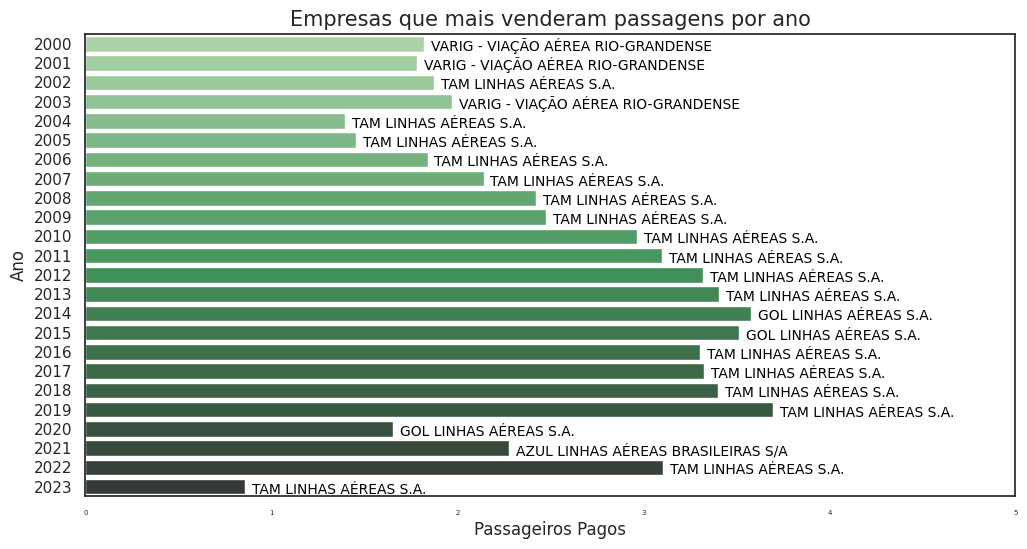

In [78]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="passageiros_pagos", y="ano", data=vendas_ano, palette="Greens_d")
for i, row in vendas_ano.iterrows():
    plt.annotate(row['empresa_nome'], xy=(row['passageiros_pagos'], i), xytext=(5, -5), textcoords='offset points', ha='left', color='black', fontsize=10)

plt.xlim(0,(10**8 - ((10**7)*5)))
plt.xlabel('Passageiros Pagos')
plt.ylabel('Ano')
plt.title('Empresas que mais venderam passagens por ano', fontsize=15);
ax.set_xticklabels(ax.get_xticklabels(), fontsize=5);

## <font color='darkorange'> 3.2. Quais a diferenças entre a TAM ( TOP1 ) e a GOL ( TOP2 )

In [79]:
tam = df2.query('empresa_sigla == "TAM"')
tam.to_parquet('data/tam.parquet')

gol = df2.query('empresa_sigla == "GLO"')
gol.to_parquet('data/gol.parquet')

In [80]:
siglas = ['TAM', 'GLO']
aux = df2.query('empresa_sigla in @siglas').copy()
aux.empresa_sigla = aux.empresa_sigla.astype(str)

aux1 = aux.groupby('empresa_sigla').agg({
                                         'empresa_nome': lambda x: x.count(),
                                         'date': lambda x: (x.max() - x.min()),
                                         'rota': lambda x: x.nunique(),
                                         'decolagens': lambda x: x.sum(),                                        
                                         'passageiros_pagos': lambda x: x.sum(),
                                         'passageiros_pg_por_voo': lambda x: x.median(),
                                         'passageiros_gratis': lambda x: x.sum(),
                                         'passageiros_gt_por_voo': lambda x: x.median(),
                                         'distancia_voada_km_por_voo': lambda x: x.median(),
                                         'assentos_por_voo': lambda x: x.median(),
                                         'horas_voadas_por_voo': lambda x: x.median()})
aux1 = aux1.reset_index()

aux1.date = (aux1.date.dt.days / 30)

aux1.columns = ['empresa', 'n_registros', 'anos', 'n_rotas', 'decolagens', 'passageiros_pagos', 'passageiros_pg_por_voo', 'passageiros_gratis',  
                'passageiros_gt_por_voo', 'distancia_voada_km_por_voo', 'assentos_por_voo', 'horas_voadas_por_voo']

aux1.iloc[:,1:] = np.round(aux1.iloc[:,1:],2)
aux1.anos = aux1.anos / 12
aux1['decolagens_anos_avg'] = aux1.decolagens / aux1.anos
aux1['passageiros_anos_avg'] = aux1.passageiros_pagos / aux1.anos

aux1 = aux1[['empresa', 'n_registros', 'n_rotas', 'anos','decolagens_anos_avg', 'decolagens', 'passageiros_anos_avg', 'passageiros_pagos', 'passageiros_pg_por_voo', 'passageiros_gratis',
       'passageiros_gt_por_voo', 'distancia_voada_km_por_voo', 'assentos_por_voo', 'horas_voadas_por_voo']]

In [81]:
aux2 = aux1.set_index(aux1.empresa)
aux2 = aux2.iloc[:, 1:]
aux2 = aux2.applymap(np.ceil)
aux2 = aux2.astype(int)
aux2 = aux2.T
def highlight_max_value(row):
    max_value = row.max()
    return ['background-color: green' if value == max_value else '' for value in row]

# Aplicar destaque condicional ao maior valor por linha usando apply()
styled_df = aux2.style.apply(highlight_max_value, axis=1)

# Exibir o DataFrame com o destaque
styled_df

empresa,GLO,TAM
n_registros,93485,122314
n_rotas,1414,1815
anos,23,24
decolagens_anos_avg,211235,247081
decolagens,4749250,5806402
passageiros_anos_avg,22453798,25189453
passageiros_pagos,504836224,591952128
passageiros_pg_por_voo,108,96
passageiros_gratis,11773455,11410875
passageiros_gt_por_voo,2,1


<font color='RED'> TAM </font>

- Tem mais foco em numero de rotas e consequentemente mais decolagens por ano
- Pegando rotas mais diversas o numero médio de passageiros por voo é reduzido

<font color='darkorange'> GOL

- Foco em menos rotas, rotas mais estratégicas que buscam maior numero de passageiros

In [82]:
siglas = ['TAM', 'GLO']
aux = df2.query('empresa_sigla in @siglas').copy()
aux.empresa_sigla = aux.empresa_sigla.astype(str)
aux = unicode_text(aux)
aux

,empresa_sigla,empresa_nome,empresa_nacionalidade,ano,mes,aeroporto_de_origem_sigla,aeroporto_de_origem_nome,aeroporto_de_origem_uf,aeroporto_de_origem_regiao,aeroporto_de_origem_pais,aeroporto_de_origem_continente,aeroporto_de_destino_sigla,aeroporto_de_destino_nome,aeroporto_de_destino_uf,aeroporto_de_destino_regiao,aeroporto_de_destino_pais,aeroporto_de_destino_continente,natureza,grupo_de_voo,passageiros_pagos,passageiros_gratis,carga_paga_kg,carga_gratis_kg,correio_kg,ask,rpk,atk,rtk,combustivel_litros,distancia_voada_km,decolagens,carga_paga_km,carga_gratis_km,correio_km,assentos,payload,horas_voadas,bagagem_kg,rota,date,passageiros_pg_por_voo,passageiros_gt_por_voo,distancia_voada_km_por_voo,assentos_por_voo,horas_voadas_por_voo,passageiros,passageiros_voo,passageiros_assentos,combustivel_voo,km_combustivel
23740,TAM,TAM LINHAS AEREAS S.A.,BRASILEIRA,2000,1,SBAU,ARACATUBA,SP,SUDESTE,BRASIL,AMERICA DO SUL,SBBU,BAURU,SP,SUDESTE,BRASIL,AMERICA DO SUL,DOMESTICA,NAO REGULAR,9.00,0.00,0.00,0.00,0.00,21060.00,3315.00,2242.00,307.00,1250.00,195.00,1.00,0.00,0.00,0.00,108.00,11500.00,0.52,149.00,SBAU - SBBU,2000-01-01,9.00,0.00,195.00,108.00,0.52,9.00,9.00,-99.00,1250.00,0.16
23741,TAM,TAM LINHAS AEREAS S.A.,BRASILEIRA,2000,1,SBAU,ARACATUBA,SP,SUDESTE,BRASIL,AMERICA DO SUL,SBBU,BAURU,SP,SUDESTE,BRASIL,AMERICA DO SUL,DOMESTICA,REGULAR,204.00,17.00,628.00,2.00,0.00,968760.00,140985.00,103132.00,11936.00,58916.00,8970.00,46.00,124605.00,390.00,0.00,4968.00,529000.00,24.50,2107.00,SBAU - SBBU,2000-01-01,4.43,0.37,195.00,108.00,0.53,221.00,4.80,-4747.00,1280.78,0.15
23742,TAM,TAM LINHAS AEREAS S.A.,BRASILEIRA,2000,1,SBAU,ARACATUBA,SP,SUDESTE,BRASIL,AMERICA DO SUL,SBCY,VARZEA GRANDE,MT,CENTRO-OESTE,BRASIL,AMERICA DO SUL,DOMESTICA,REGULAR,2047.00,73.00,30.00,0.00,0.00,2403650.00,1765930.00,255944.00,159489.00,80898.00,22256.00,26.00,700208.00,418584.00,0.00,2808.00,299000.00,35.06,30585.00,SBAU - SBCY,2000-01-01,78.73,2.81,856.00,108.00,1.35,2120.00,81.54,-688.00,3111.46,0.28
23745,TAM,TAM LINHAS AEREAS S.A.,BRASILEIRA,2000,1,SBAU,ARACATUBA,SP,SUDESTE,BRASIL,AMERICA DO SUL,SBSP,SAO PAULO,SP,SUDESTE,BRASIL,AMERICA DO SUL,DOMESTICA,REGULAR,2351.00,131.00,78.00,0.00,0.00,1439420.00,922012.00,153272.00,80639.00,65383.00,13328.00,28.00,670684.00,230384.00,0.00,3024.00,322000.00,28.12,26092.00,SBAU - SBSP,2000-01-01,83.96,4.68,476.00,108.00,1.00,2482.00,88.64,-542.00,2335.11,0.20
23749,TAM,TAM LINHAS AEREAS S.A.,BRASILEIRA,2000,1,SBBE,BELEM,PA,NORTE,BRASIL,AMERICA DO SUL,SBMA,MARABA,PA,NORTE,BRASIL,AMERICA DO SUL,DOMESTICA,REGULAR,1089.00,106.00,3026.00,218.00,0.00,1018330.00,631743.00,108423.00,61303.00,50884.00,9429.00,21.00,3399830.00,896204.00,0.00,2268.00,241500.00,21.16,17202.00,SBBE - SBMA,2000-01-01,51.86,5.05,449.00,108.00,1.01,1195.00,56.90,-1073.00,2423.05,0.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167667,TAM,TAM LINHAS AEREAS S.A.,BRASILEIRA,2004,5,SBBH,BELO HORIZONTE,MG,SUDESTE,BRASIL,AMERICA DO SUL,SBSP,SAO PAULO,SP,SUDESTE,BRASIL,AMERICA DO SUL,DOMESTICA,REGULAR,17513.00,264.00,57803.00,1345.00,21.00,17224700.00,9385990.00,1938400.00,798794.00,835850.00,116928.00,232.00,31521700.00,1021100.00,10584.00,34176.00,3846300.00,280.03,112831.00,SBBH - SBSP,2004-05-01,75.49,1.14,504.00,147.31,1.21,17777.00,76.62,-16399.00,3602.80,0.14
1167668,TAM,TAM LINHAS AEREAS S.A.,BRASILEIRA,2004,5,SBBH,BELO HORIZONTE,MG,SUDESTE,BRASIL,AMERICA DO SUL,SBSV,SALVADOR,BA,NORDESTE,BRASIL,AMERICA DO SUL,DOMESTICA,REGULAR,1287.00,48.00,4795.00,0.00,0.00,5064080.00,3233270.00,512368.00,349334.00,142060.00,30318.00,31.00,59316700.00,1497320.00,897804.00,5178.00,523900.00,45.86,19300.00,SBBH - SBSV,2004-05-01,41.52,1.55,978.00,167.03,1.48,1335.00,43.06,-3843.00,4582.58,0.21
1167669,TAM,TAM LINHAS AEREAS S.A.,BRASILEIRA,2004,5,SBBH,BELO HORIZONTE,MG,SUDESTE,BRASIL,AMERICA DO SUL,SBUL,UBERLANDI

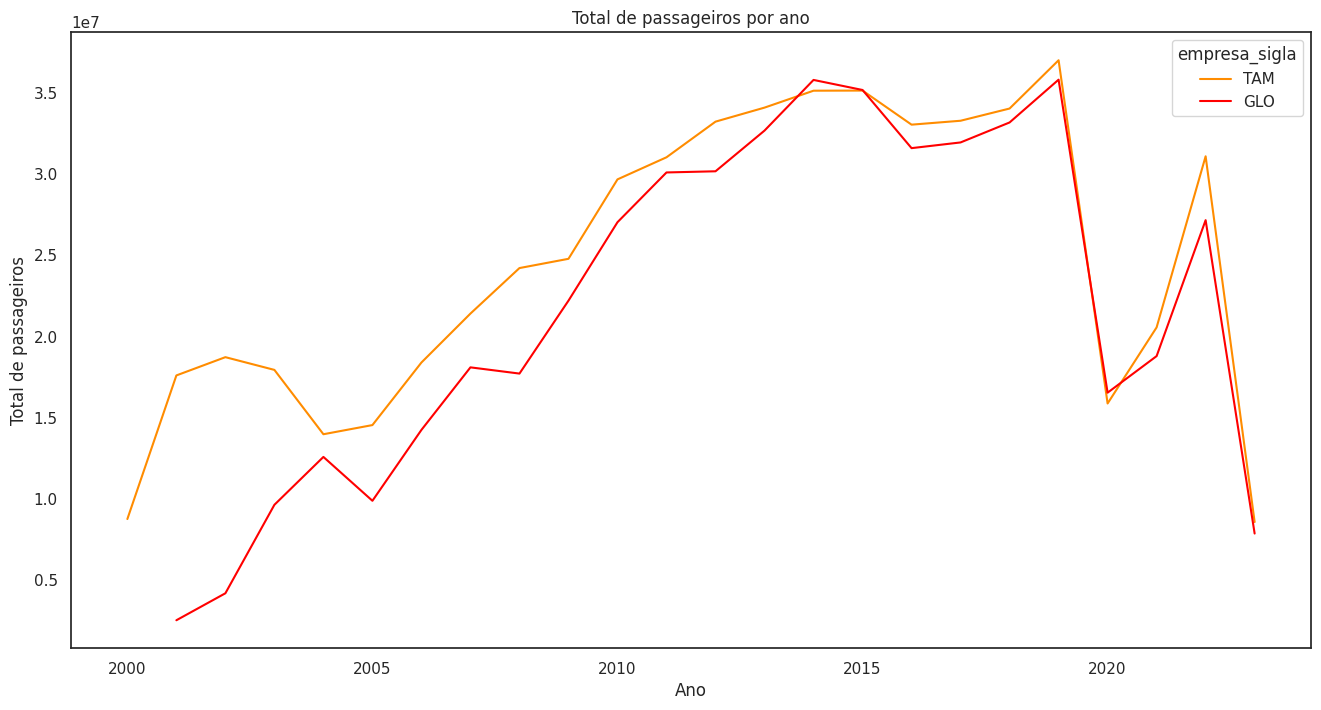

In [83]:
# TOTAL DE PASSAGEIROS POR ANO
ano_passageiro = aux.groupby(['ano','empresa_sigla'])[['passageiros_pagos']].sum().reset_index()
sns.lineplot(data=ano_passageiro, x='ano', y='passageiros_pagos', hue='empresa_sigla', palette=['darkorange', 'red']);
plt.title('Total de passageiros por ano')
plt.ylabel('Total de passageiros')
plt.xlabel('Ano');

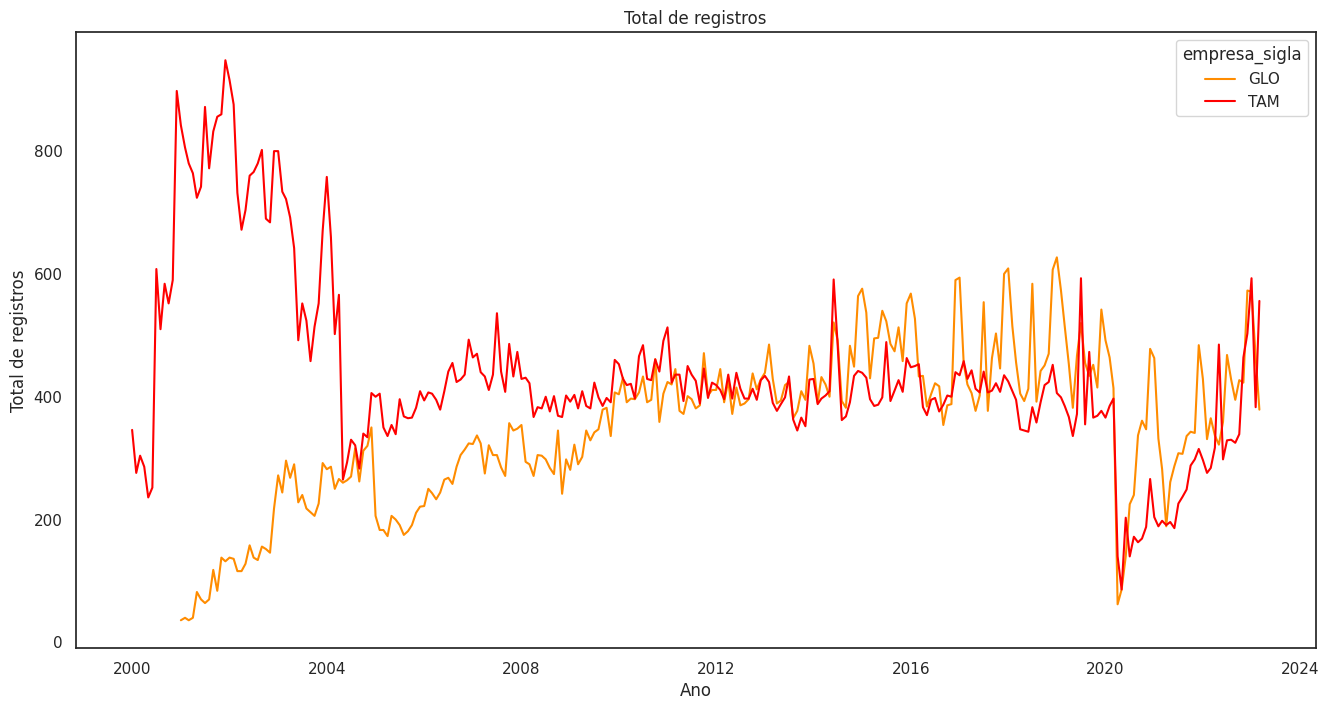

In [84]:
# TOTAL DE REGISTROS POR ANO
ano_registros = aux.groupby(['empresa_sigla', 'date'])[['empresa_nome']].count().reset_index()
sns.lineplot(data=ano_registros, x='date', y='empresa_nome', hue='empresa_sigla', palette=['darkorange', 'red']);
plt.title('Total de registros')
plt.ylabel('Total de registros')
plt.xlabel('Ano');

### MAPA

In [85]:
import geopandas as gpd
# Get Brasil
brasil = aux.query("aeroporto_de_origem_pais =='BRASIL' and aeroporto_de_destino_pais =='BRASIL'")

In [86]:
map_estados = {
'RO': 'RONDÔNIA',
'AC': 'ACRE',
'AM': 'AMAZONAS',
'RR': 'RORAIMA',
'PA': 'PARÁ',
'AP': 'AMAPÁ',
'TO': 'TOCANTINS',
'MA': 'MARANHÃO',
'PI': 'PIAUÍ',
'CE': 'CEARÁ',
'RN': 'RIO GRANDE DO NORTE',
'PB': 'PARAÍBA',
'PE': 'PERNAMBUCO',
'AL': 'ALAGOAS',
'SE': 'SERGIPE',
'BA': 'BAHIA',
'MG': 'MINAS GERAIS',
'ES': 'ESPIRITO SANTO',
'RJ': 'RIO DE JANEIRO',
'SP': 'SÃO PAULO',
'PR': 'PARANÁ',
'SC': 'SANTA CATARINA',
'RS': 'RIO GRANDE DO SUL',
'MS': 'MATO GROSSO DO SUL',
'MT': 'MATO GROSSO',
'GO': 'GOIÁS',
'DF': 'DISTRITO FEDERAL'
}

# Create column with name of states
brasil["NM_ESTADO"] = brasil.aeroporto_de_origem_uf.map(map_estados)

# Split in GOL AND TAM
gol_mapa = brasil.query("empresa_sigla == 'GLO'")
tam_mapa = brasil.query("empresa_sigla == 'TAM'")

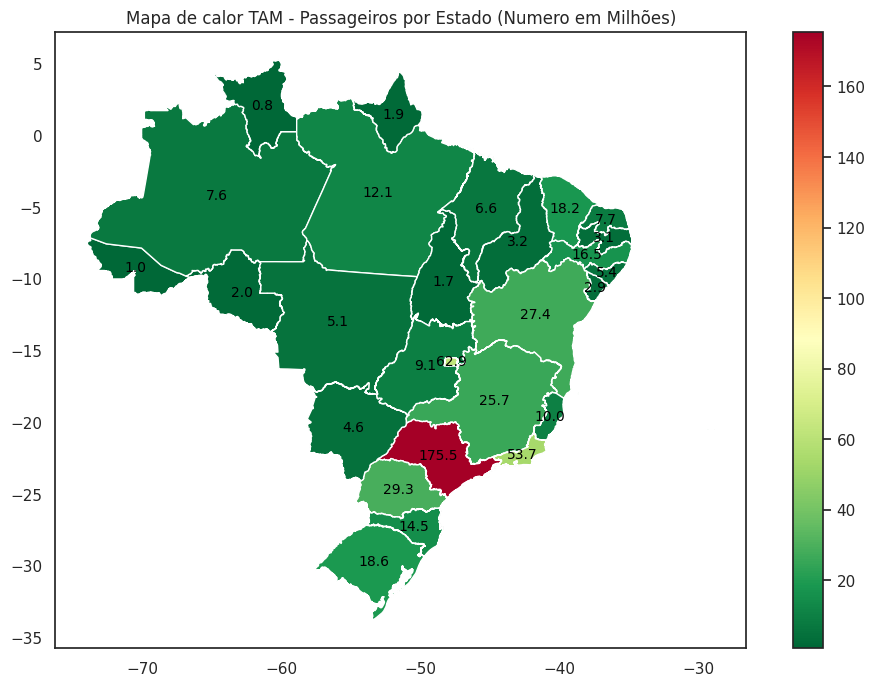

In [87]:
# Load Shape File
mapa_estados = gpd.read_file('geopandas/Estados_Brasileiros/UFEBRASIL.shp')

freq_tam = tam_mapa.groupby('NM_ESTADO')[['passageiros_pagos']].sum()
freq_tam.columns = ['NM_ESTADO']
freq_tam = freq_tam.NM_ESTADO
mapa_estados = mapa_estados.merge(freq_tam, left_on='NM_ESTADO', right_index=True)
mapa_estados.NM_ESTADO_y = np.round(mapa_estados.NM_ESTADO_y / 10**6, 1)

# Plotar o mapa
fig, ax = plt.subplots(figsize=(12, 8))
mapa_estados.plot(column='NM_ESTADO_y', cmap='RdYlGn_r', ax=ax, legend=True)

plt.title('Mapa de calor TAM - Passageiros por Estado (Numero em Milhões)')

# Adicionar os valores para cada estado
for idx, row in mapa_estados.iterrows():
    estado = row['NM_ESTADO_y']
    valor = row['NM_ESTADO_y']
    x, y = row['geometry'].centroid.coords[0]
    ax.text(x, y, f'{valor}', ha='center', va='center', fontsize=10, color='black')


# Exibir o mapa
plt.show()

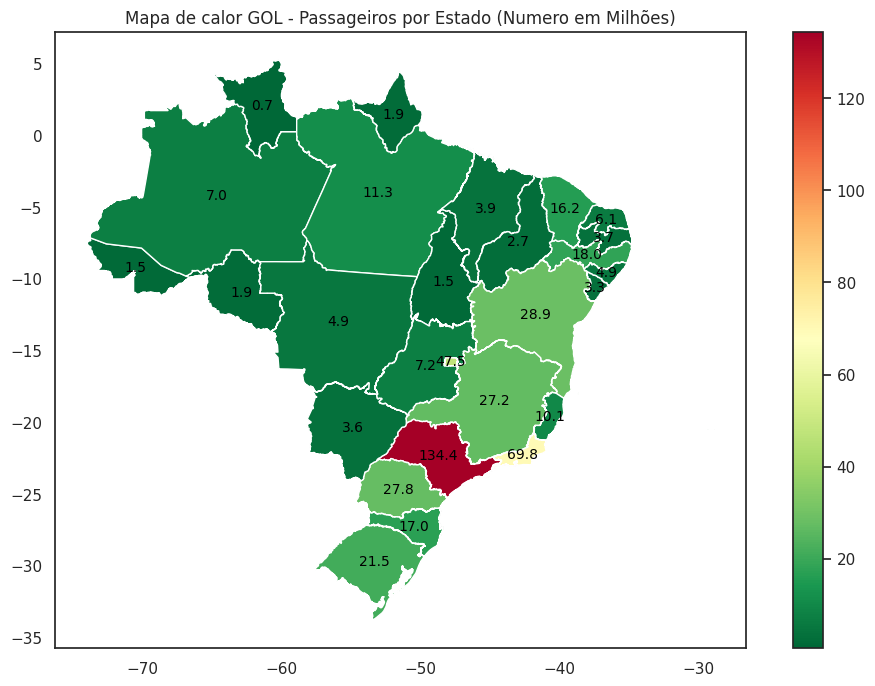

In [88]:
# Load Shape File
mapa_estados = gpd.read_file('geopandas/Estados_Brasileiros/UFEBRASIL.shp')

freq_GOL = gol_mapa.groupby('NM_ESTADO')[['passageiros_pagos']].sum()
freq_GOL.columns = ['NM_ESTADO']
freq_GOL = freq_GOL.NM_ESTADO
mapa_estados = mapa_estados.merge(freq_GOL, left_on='NM_ESTADO', right_index=True)
mapa_estados.NM_ESTADO_y = np.round(mapa_estados.NM_ESTADO_y / 10**6, 1)

# Plotar o mapa
fig, ax = plt.subplots(figsize=(12, 8))
mapa_estados.plot(column='NM_ESTADO_y', cmap='RdYlGn_r', ax=ax, legend=True)

plt.title('Mapa de calor GOL - Passageiros por Estado (Numero em Milhões)')

# Adicionar os valores para cada estado
for idx, row in mapa_estados.iterrows():
    estado = row['NM_ESTADO_y']
    valor = row['NM_ESTADO_y']
    x, y = row['geometry'].centroid.coords[0]
    ax.text(x, y, f'{valor}', ha='center', va='center', fontsize=10, color='black')


# Exibir o mapa
plt.show()

#### Registros

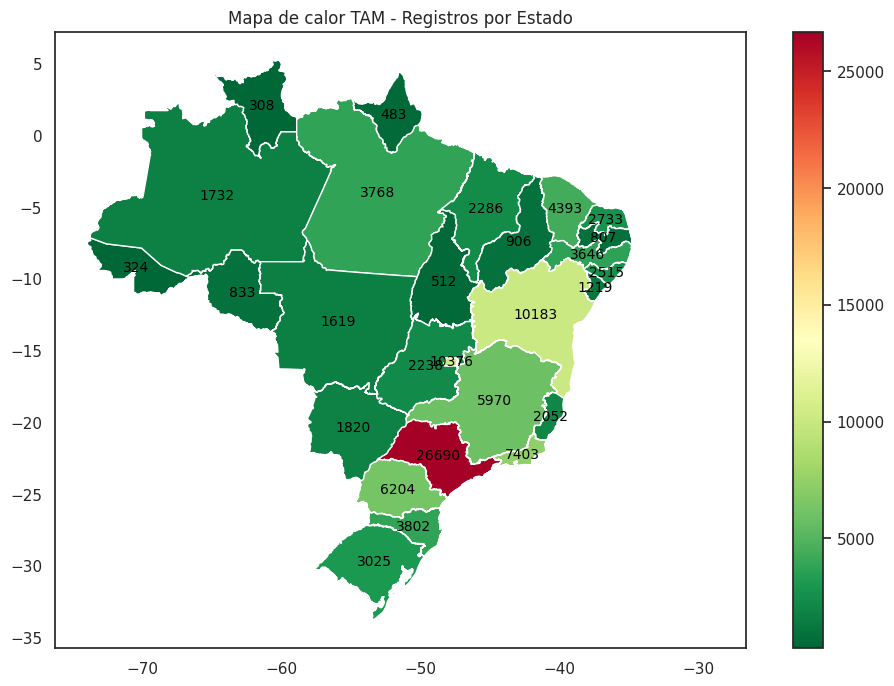

In [89]:
# Load Shape File
mapa_estados = gpd.read_file('geopandas/Estados_Brasileiros/UFEBRASIL.shp')

freq_tam = tam_mapa.groupby('NM_ESTADO')[['passageiros_pagos']].count()
freq_tam.columns = ['NM_ESTADO']
freq_tam = freq_tam.NM_ESTADO
mapa_estados = mapa_estados.merge(freq_tam, left_on='NM_ESTADO', right_index=True)
mapa_estados.NM_ESTADO_y = np.round(mapa_estados.NM_ESTADO_y, 1)

# Plotar o mapa
fig, ax = plt.subplots(figsize=(12, 8))
mapa_estados.plot(column='NM_ESTADO_y', cmap='RdYlGn_r', ax=ax, legend=True)

plt.title('Mapa de calor TAM - Registros por Estado')

# Adicionar os valores para cada estado
for idx, row in mapa_estados.iterrows():
    estado = row['NM_ESTADO_y']
    valor = row['NM_ESTADO_y']
    x, y = row['geometry'].centroid.coords[0]
    ax.text(x, y, f'{valor}', ha='center', va='center', fontsize=10, color='black')


# Exibir o mapa
plt.show()

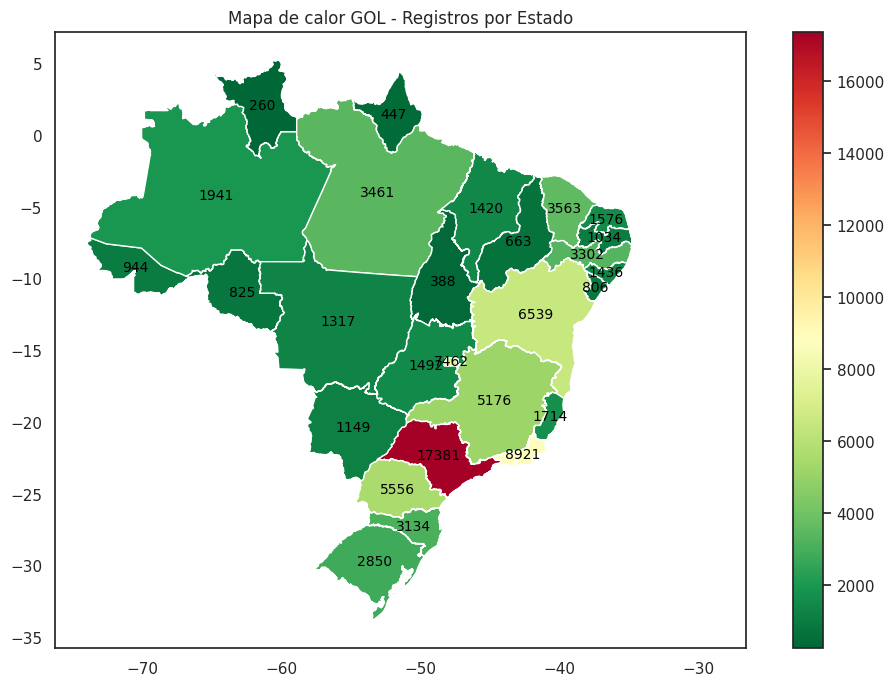

In [90]:
# Load Shape File
mapa_estados = gpd.read_file('geopandas/Estados_Brasileiros/UFEBRASIL.shp')

freq_GOL = gol_mapa.groupby('NM_ESTADO')[['passageiros_pagos']].count()
freq_GOL.columns = ['NM_ESTADO']
freq_GOL = freq_GOL.NM_ESTADO
mapa_estados = mapa_estados.merge(freq_GOL, left_on='NM_ESTADO', right_index=True)
mapa_estados.NM_ESTADO_y = np.round(mapa_estados.NM_ESTADO_y, 1)

# Plotar o mapa
fig, ax = plt.subplots(figsize=(12, 8))
mapa_estados.plot(column='NM_ESTADO_y', cmap='RdYlGn_r', ax=ax, legend=True)

plt.title('Mapa de calor GOL - Registros por Estado')

# Adicionar os valores para cada estado
for idx, row in mapa_estados.iterrows():
    estado = row['NM_ESTADO_y']
    valor = row['NM_ESTADO_y']
    x, y = row['geometry'].centroid.coords[0]
    ax.text(x, y, f'{valor}', ha='center', va='center', fontsize=10, color='black')


# Exibir o mapa
plt.show()

#### Decolagens

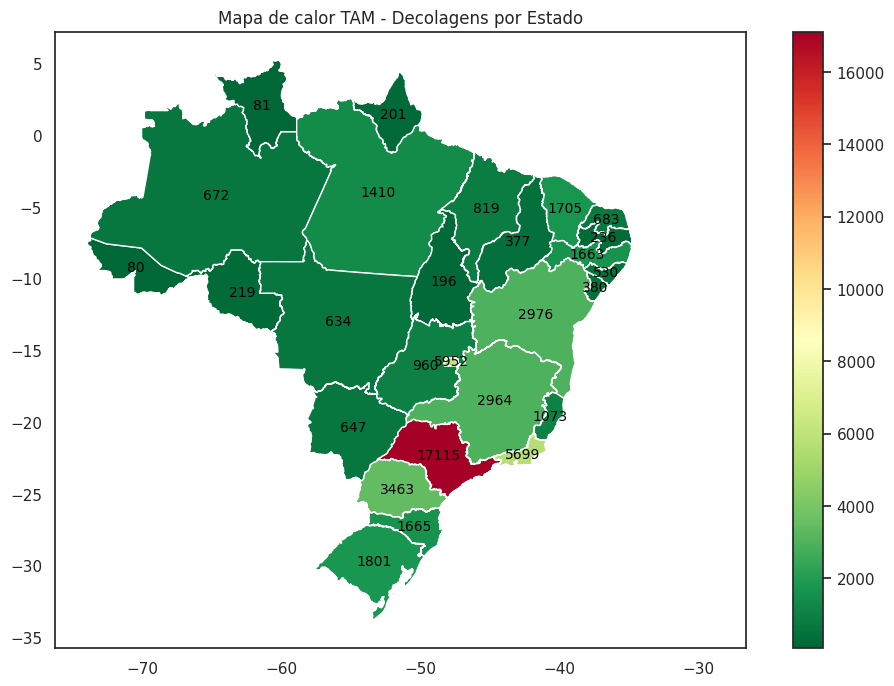

In [91]:
# Load Shape File
mapa_estados = gpd.read_file('geopandas/Estados_Brasileiros/UFEBRASIL.shp')

freq_tam = tam_mapa.groupby('NM_ESTADO')[['decolagens']].sum()
freq_tam.columns = ['NM_ESTADO']
freq_tam = freq_tam.NM_ESTADO
mapa_estados = mapa_estados.merge(freq_tam, left_on='NM_ESTADO', right_index=True)
mapa_estados.NM_ESTADO_y = (np.ceil( mapa_estados.NM_ESTADO_y / 100)).astype(int)
# Plotar o mapa
fig, ax = plt.subplots(figsize=(12, 8))
mapa_estados.plot(column='NM_ESTADO_y', cmap='RdYlGn_r', ax=ax, legend=True)

plt.title('Mapa de calor TAM - Decolagens por Estado')

# Adicionar os valores para cada estado
for idx, row in mapa_estados.iterrows():
    estado = row['NM_ESTADO_y']
    valor = row['NM_ESTADO_y']
    x, y = row['geometry'].centroid.coords[0]
    ax.text(x, y, f'{valor}', ha='center', va='center', fontsize=10, color='black')


# Exibir o mapa
plt.show()

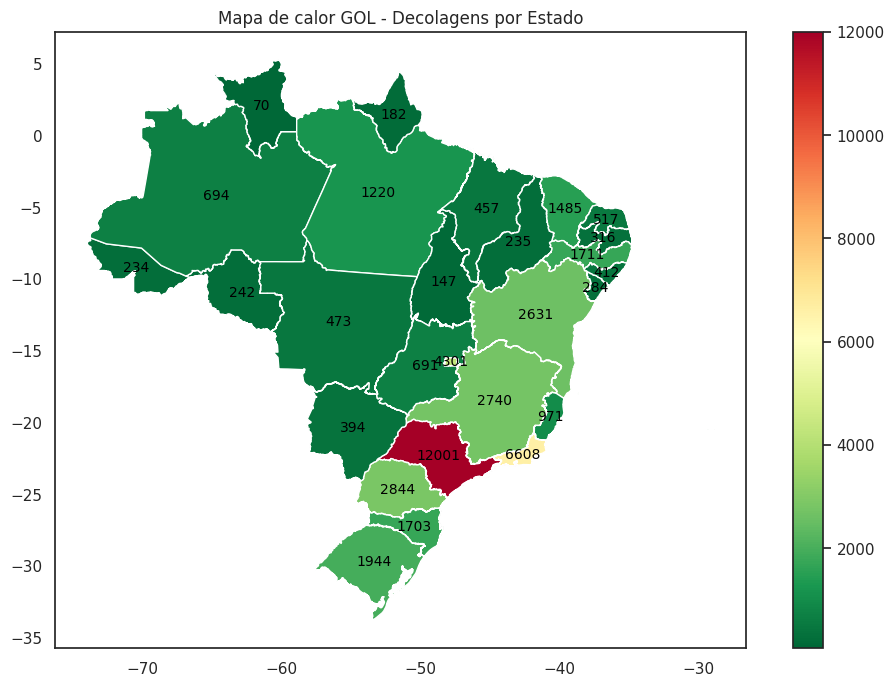

In [92]:
# Load Shape File
mapa_estados = gpd.read_file('geopandas/Estados_Brasileiros/UFEBRASIL.shp')

freq_GOL = gol_mapa.groupby('NM_ESTADO')[['decolagens']].sum()
freq_GOL.columns = ['NM_ESTADO']
freq_GOL = freq_GOL.NM_ESTADO
mapa_estados = mapa_estados.merge(freq_GOL, left_on='NM_ESTADO', right_index=True)
mapa_estados.NM_ESTADO_y = (np.ceil( mapa_estados.NM_ESTADO_y / 100)).astype(int)

# Plotar o mapa
fig, ax = plt.subplots(figsize=(12, 8))
mapa_estados.plot(column='NM_ESTADO_y', cmap='RdYlGn_r', ax=ax, legend=True)

plt.title('Mapa de calor GOL - Decolagens por Estado')

# Adicionar os valores para cada estado
for idx, row in mapa_estados.iterrows():
    estado = row['NM_ESTADO_y']
    valor = row['NM_ESTADO_y']
    x, y = row['geometry'].centroid.coords[0]
    ax.text(x, y, f'{valor}', ha='center', va='center', fontsize=10, color='black')


# Exibir o mapa
plt.show()

### ROTAS

In [93]:
gol_mapa.passageiros

49861     1111.00
49862      150.00
49863     1255.00
49864     2861.00
49865      642.00
            ...  
1154301   1209.00
1154304   1448.00
1154305   4680.00
1154308   9953.00
1154309    950.00
Name: passageiros, Length: 84757, dtype: float32

import plotly.graph_objects as go
df = gol_mapa
# Criar um dicionário para mapear os estados para IDs numéricos
state_ids = {}
counter = 0
for state in pd.concat([df['aeroporto_de_origem_nome'], df['aeroporto_de_destino_nome']]).unique():
    state_ids[state] = counter
    counter += 1

# Mapear os estados de origem e destino para IDs numéricos
df['Origem_ID'] = df['aeroporto_de_origem_nome'].map(state_ids)
df['Destino_ID'] = df['aeroporto_de_destino_nome'].map(state_ids)

# Criar o diagrama de Sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(
        label=list(state_ids.keys())
    ),
    link=dict(
        source=df['Origem_ID'],
        target=df['Destino_ID'],
        value=df['passageiros']
    )
)])

# Exibir o diagrama
fig.show()


In [94]:
asdasdasdasd

NameError: name 'asdasdasdasd' is not defined

# <font color='darkorange'> 3.0. Model

In [ ]:
data = pd.read_parquet('data/df2.parquet')

# Selecionando somente os Voos Regulares - Já que não faz sentido prever voos irregulares
data = data.query("grupo_de_voo == 'REGULAR'")

# Como algumas features são dependentes dos passageiros, e estamos tentando prever o numero de passageiros, essas features foram retiradas
cols = ["carga_paga_kg", "carga_gratis_kg", "correio_kg", "ask", "rpk", "atk", "rtk", "combustivel_litros", "empresa_sigla", "empresa_nacionalidade", 
        "grupo_de_voo", "combustivel_voo", "km_combustivel", "passageiros_gratis", "bagagem_kg", "payload", "carga_paga_km", "carga_gratis_km", "correio_km", 
        "passageiros_assentos", "passageiros_voo", "passageiros_pg_por_voo", "passageiros_gt_por_voo", "passageiros_pagos"]
data = data.drop(columns=cols)
data = data.reset_index(drop=True)

# Split train test
train = data.query('date < "2023-03-01"')
test = data.query('date >= "2023-03-01"')

print(train.shape[0] + test.shape[0] == data.shape[0])
print(train.shape, test.shape)

## <font color='darkorange'> 3.1. Data Descriptions

### <font color='darkorange'> 3.1.1. Check NA and dtypes

In [ ]:
starts.data_dimensions(train)

### <font color='darkorange'> 3.1.2. Data Dimensions

In [ ]:
starts.type_na(train)

- Faltam dados dos estados de origem e destino

## <font color='darkorange'> 3.2. EDA

In [ ]:
df2 = train.copy()

### <font color='darkorange'> 3.2.1. Descriptive Analysis

In [ ]:
starts.statistics_info(df2)

- 22 anos de dados - 2001 - 2023
- 14 km de distancia como minimo me chama a atenção
- Registro com uma unica decolagem
- Decolagem com alta kurtosis, skew positiva
- Assentos com alta kurtosis, skew positiva
- Passageiros com alta kurtosis, skew positiva

### <font color='darkorange'> 3.2.2. Numerical Analysis

In [ ]:
# target
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(25, 8))
fig.suptitle('Passageiros Distribuições')
sns.distplot((df2.passageiros), ax=axs[0]);
axs[0].set_title('Normal')
sns.distplot(np.log1p(df2.passageiros), ax=axs[1] );
axs[1].set_title('LOG1P');

In [ ]:
df2.hist(bins=22, figsize=(18,12));

In [ ]:
df2.sort_values('passageiros', ascending=False)

- distancia_voada_km -> OK
- decolagens -> OK
- assentos -> OK
- horas_voadas -> OK
- passageiros_pagos	 -> OK

### <font color='darkorange'> 3.2.2. Categorical Analysis

In [ ]:
# Split strings nas colunas aeroporto nome
df2 = split_names(df2)

# Aplica transformações nas strings
df2 = unicode_text(df2)

#### aeroporto_de_origem_sigla

In [ ]:
univariate_categorical( df2.aeroporto_de_origem_sigla, 'Origem Siglas')

#### aeroporto_de_origem_nome

In [ ]:
univariate_categorical( df2.aeroporto_de_origem_nome, 'Origem Nomes')

- O numero de nomes é diferente do numero de siglas isso se deve a ter aeroportos de mesmo nome e siglas diferentes

#### aeroporto_de_origem_uf

In [ ]:
univariate_categorical( df2.aeroporto_de_origem_uf, 'Origem UF')

#### aeroporto_de_destino_sigla


In [ ]:
univariate_categorical( df2.aeroporto_de_destino_sigla, 'Destino Sigla')

#### aeroporto_de_destino_nome


In [ ]:
univariate_categorical( df2.aeroporto_de_destino_nome, 'Destino Nome')

#### aeroporto_de_destino_uf


In [ ]:
univariate_categorical( df2.aeroporto_de_destino_uf, 'Destino UF')

#### natureza

In [ ]:
univariate_categorical( df2.natureza, 'Natureza')

### <font color='darkorange'> 3.2.3. Bivariate Analysis

In [ ]:
# ANO
sns.lineplot(data=df2, x='ano', y='passageiros');
plt.title('Passageiros por ano',fontsize=15)
plt.ylabel('Numero de passageiros');

In [ ]:
# mes
sns.lineplot(data=df2, x='mes', y='passageiros');
plt.title('Passageiros por mes',fontsize=15)
plt.ylabel('Numero de passageiros');

In [ ]:
# aeroporto_de_origem_uf
aux = (df2.groupby('aeroporto_de_origem_uf')[['passageiros']].sum().sort_values('passageiros',ascending=False)
                                                                     .reset_index())

sns.barplot(data=aux, x='passageiros', y='aeroporto_de_origem_uf', palette='Set2', order=aux.aeroporto_de_origem_uf);

plt.title('Passageiros por estado - Origem', fontsize=15)
plt.ylabel('Estados')
plt.xlabel('Numero de passageiros');

In [ ]:
# aeroporto_de_destino_uf
aux = (df2.groupby('aeroporto_de_destino_uf')[['passageiros']].sum().sort_values('passageiros',ascending=False)
                                                                     .reset_index())

sns.barplot(data=aux, x='passageiros', y='aeroporto_de_destino_uf', palette='Set2', order=aux.aeroporto_de_destino_uf);

plt.title('Passageiros por estado - Destino', fontsize=15)
plt.ylabel('Estados')
plt.xlabel('Numero de passageiros');

In [ ]:
# natureza
sns.violinplot(data=df2, y='passageiros', x='natureza')
plt.title('Distribuição de passageiros por natureza de voo', fontsize=15)
plt.ylabel('Numero de passageiros');

In [ ]:
# distancia_voada_km
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 8))
axes[0].set_position([0.1, 0.1, 0.43, 0.8])  # Set the size

sns.scatterplot(data=df2, x='distancia_voada_km', y='passageiros', ax=axes[0])
axes[0].set_title('Distancia Voada em KM x Numero de passageiros', fontsize=20)
axes[0].set_xlabel('Distancia Voada em KM')
axes[0].set_ylabel('Numero de passageiros')

aux = df2[['passageiros', 'distancia_voada_km']].corr(method='pearson')
sns.heatmap(aux, annot=True, ax=axes[1])
axes[1].set_title('Correlação Passageiros e distancia voada', fontsize=15)

plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 8))
axes[0].set_position([0.1, 0.1, 0.43, 0.8])  # Set the size

sns.scatterplot(data=df2, x='distancia_voada_km', y='passageiros', ax=axes[0])
axes[0].set_title('Distancia Voada em KM x Numero de passageiros', fontsize=20)
axes[0].set_xlabel('Distancia Voada em KM')
axes[0].set_ylabel('Numero de passageiros')

# Correlacao Pearson
aux = df2[['passageiros', 'distancia_voada_km']].corr(method='pearson')
sns.heatmap(aux, annot=True, ax=axes[1])
axes[1].set_title('Correlação Passageiros e distancia voada', fontsize=20)

plt.show()


In [ ]:
# decolagens
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 8))
axes[0].set_position([0.1, 0.1, 0.43, 0.8])  # Set the size

sns.scatterplot(data=df2, x='decolagens', y='passageiros', ax=axes[0])
axes[0].set_title('Decolagens x Numero de passageiros', fontsize=20)
axes[0].set_xlabel('Decolagens')
axes[0].set_ylabel('Numero de passageiros')

# Correlacao Pearson
aux = df2[['passageiros', 'decolagens']].corr(method='pearson')
sns.heatmap(aux, annot=True, ax=axes[1])
axes[1].set_title('Correlação Passageiros e Decolagens', fontsize=20)

plt.show()

In [ ]:
# assentos
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 8))
axes[0].set_position([0.1, 0.1, 0.43, 0.8])  # Set the size

sns.scatterplot(data=df2, x='assentos', y='passageiros', ax=axes[0])
axes[0].set_title('Assentos x Numero de passageiros', fontsize=20)
axes[0].set_xlabel('Assentos')
axes[0].set_ylabel('Numero de passageiros')

# Correlacao Pearson
aux = df2[['passageiros', 'assentos']].corr(method='pearson')
sns.heatmap(aux, annot=True, ax=axes[1])
axes[1].set_title('Correlação Passageiros e Assentos', fontsize=20)

plt.show()

In [ ]:
# horas_voadas
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 8))
axes[0].set_position([0.1, 0.1, 0.43, 0.8])  # Set the size

sns.scatterplot(data=df2, x='horas_voadas', y='passageiros', ax=axes[0])
axes[0].set_title('Horas voadas x Numero de passageiros', fontsize=20)
axes[0].set_xlabel('Horas voadas')
axes[0].set_ylabel('Numero de passageiros')

# Correlacao Pearson
aux = df2[['passageiros', 'horas_voadas']].corr(method='pearson')
sns.heatmap(aux, annot=True, ax=axes[1])
axes[1].set_title('Correlação Passageiros e Horas voadas', fontsize=20)

plt.show()

In [ ]:
# date
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=df2, x='date', y='passageiros', ax=ax);
plt.title('Passageiros por date',fontsize=15)
plt.ylabel('Numero de passageiros');
ax.axvline(pd.to_datetime('2020-01-01'), color='black', ls='--');

In [ ]:
# date
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=df2.query("ano >= 2019"), x='date', y='passageiros', ax=ax);
plt.title('Passageiros por date',fontsize=15)
plt.ylabel('Numero de passageiros');
ax.axvline(pd.to_datetime('2020-01-01'), color='black', ls='--');
ax.axvline(pd.to_datetime('2021-07-01'), color='black', ls='--');

- O gap causado pela covid é um ponto muito importante para esta modelagem

### <font color='darkorange'> 3.2.4. Time Series Analysis

In [ ]:
time_series = train.groupby('date')[['passageiros']].sum()
df_time_series = time_series.reset_index()

In [ ]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import math

In [ ]:
decomp = STL(time_series, period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(decomp.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomp.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomp.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomp.resid)
ax4.set_ylabel('Residuals');

## <font color='darkorange'> 3.3. Data Cleaning

In [ ]:
after_covid = pd.to_datetime('2021-01-01')
train_after_covid = train.query('date > @after_covid')

X_train = train_after_covid.copy()
X_train = X_train.sort_values('date').reset_index(drop=True)
y_train = train_after_covid.passageiros.copy()

print( X_train.shape, y_train.shape )
X_test = test.copy()
y_test = test.passageiros.copy()

print( X_test.shape, y_test.shape )

In [ ]:
from sklearn.base             import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

class DataCleaning(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = self.split_names(X)
        X = self.unicode_text(X)
        
        return X
    
    def split_names(self, data):

        """
        Split the airport names into airport name and corresponding state abbreviation.

        Args:
            data (DataFrame): Input DataFrame with columns 'aeroporto_de_origem_nome' and 'aeroporto_de_destino_nome'.

        Returns:
            DataFrame: Modified input DataFrame with additional columns 'aeroporto_de_origem_uf' and 'aeroporto_de_destino_uf'.
                       The 'aeroporto_de_origem_nome' and 'aeroporto_de_destino_nome' columns are updated to contain only the airport names.
                       The 'aeroporto_de_origem_uf' and 'aeroporto_de_destino_uf' columns are converted to the 'category' data type.
        """

        # Origem
        aeroporto_de_origem_uf = pd.DataFrame( data.aeroporto_de_origem_nome.str.split(',').str[1] )
        aeroporto_de_origem_uf = aeroporto_de_origem_uf.rename(columns={'aeroporto_de_origem_nome': 'aeroporto_de_origem_uf'})
        uf_completo = pd.DataFrame( data.aeroporto_de_origem_uf )
        uf_completo.update(aeroporto_de_origem_uf)
        data.aeroporto_de_origem_uf = uf_completo.astype('category')
        data.aeroporto_de_origem_nome = data.aeroporto_de_origem_nome.str.split(',').str[0].astype('category')

        # Destino
        aeroporto_de_destino_uf = pd.DataFrame( data.aeroporto_de_destino_nome.str.split(',').str[1] )
        aeroporto_de_destino_uf = aeroporto_de_destino_uf.rename(columns={'aeroporto_de_destino_nome': 'aeroporto_de_destino_uf'})
        uf_completo = pd.DataFrame( data.aeroporto_de_destino_uf )
        uf_completo.update(aeroporto_de_destino_uf)
        data.aeroporto_de_destino_uf = uf_completo.astype('category')
        data.aeroporto_de_destino_nome = data.aeroporto_de_destino_nome.str.split(',').str[0].astype('category')

        return data

    def unicode_text(self, data ):
        """
        Transforme the text - strip and unidecode.
        """

        for col in data.select_dtypes(include=['category']).columns:
            data[col] = data[col].astype(str).str.strip().apply(lambda x: unidecode(x))
            data[col] = data[col].astype('category')

        return data

In [ ]:
clean_pipe = Pipeline([('DataCleaning', DataCleaning())])
clean_pipe

In [ ]:
X_train = clean_pipe.fit_transform(X_train)
X_test = clean_pipe.transform(X_test)

X_train.head(2)

## <font color='darkorange'> 3.4. Feature Engineering

In [ ]:
from sklearn.base             import BaseEstimator, TransformerMixin
from dateutil.relativedelta import relativedelta
import pandas as pd

class FeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        X = self.lag_features(X)
        X = self.new_features(X)
        X = X.drop(columns=['passageiros', 'date'])
        return X
    
    def fit_transform(self, X, y=None):
        X = self.lag_features(X)
        X = self.new_features(X)
        X = X.drop(columns=['passageiros', 'date'])
        return X

    def transform(self, X, y=None):
        X = self.lag_transform(X)
        X = self.new_features(X)
        X = X.drop(columns=['passageiros', 'date'])
        return X
    
    def lag_features(self, data ):
        """
        Calculates the lag feature of passengers per flight for each date.
        """

        data_copy = data.copy()
        data_copy['passageiros_voo'] = data_copy.passageiros / data_copy.decolagens
        rolagem = data_copy.groupby('date')[['passageiros_voo']].sum().reset_index()

        self.lag_year = rolagem.copy()
        self.lag_year['date'] = self.lag_year.date.apply(lambda x: x + relativedelta(years=1))
        self.lag_year = self.lag_year.rename(columns={'passageiros_voo': 'lag_year'})

        data = data.merge(self.lag_year, how ='left', on='date')
        data = data.sort_values('date')
        
        return data
    
    def lag_transform(self, data ):
        """
        Apply lag features.
        """
        data = data.merge(self.lag_year, how ='left', on='date')
        data = data.sort_values('date')
        
        return data
    
    def new_features(self, data):
        """
        Create new features.
        """

        data['rota'] = data.aeroporto_de_origem_sigla.astype(str) + " - " + data.aeroporto_de_destino_sigla.astype(str)

        data['distancia_voada_km_por_voo'] = data.distancia_voada_km / data.decolagens
        data['assentos_por_voo'] = data.assentos / data.decolagens
        data['horas_voadas_por_voo'] = data.horas_voadas / data.decolagens

        # FEATURES ENGINEERING FOR TIME SERIES
        data["mes_sin"] = data.mes.apply(lambda x: np.sin(x * (2. * np.pi / 12)))
        data["mes_cos"] = data.mes.apply(lambda x: np.cos(x * (2. * np.pi / 12)))

        #LAG features
        data.lag_year = data.lag_year * data.decolagens
        min_value = data.lag_year.min()
        data.lag_year = data.lag_year.fillna(min_value)
        return data

In [ ]:
feat_pipe = Pipeline([('FeatureEngineering', FeatureEngineering())])
feat_pipe

In [ ]:
X_train = feat_pipe.fit_transform(X_train)
X_test = feat_pipe.transform(X_test)

X_train.tail(2)

## <font color='darkorange'> 3.5. Pre Processing

In [ ]:
num_cols = X_train.select_dtypes(include=['int', 'float']).columns

cat_cols = X_train.select_dtypes(exclude=['int', 'float']).columns

numerical_pipe = Pipeline([("Numerical_Imputer", SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=0)),
                           ("Numerical_PreProcessing", StandardScaler())])

categorical_pipe = Pipeline([("Categorical_Imputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                             ("Categorical_PreProcessing", CountEncoder())])


linear_preprocessing = ColumnTransformer([("Numerical"  , numerical_pipe, num_cols),
                                        ("Categorical", categorical_pipe, cat_cols)])
linear_preprocessing

In [ ]:
num_cols = X_train.select_dtypes(include=['int', 'float']).columns

cat_cols = X_train.select_dtypes(exclude=['int', 'float']).columns

numerical_pipe = Pipeline([("Numerical_Imputer", SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=0))])

categorical_pipe = Pipeline([("Categorical_Imputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                             ("Categorical_PreProcessing", CountEncoder())])


tree_preprocessing = ColumnTransformer([("Numerical_Transformations"  , numerical_pipe, num_cols),
                                        ("Categorical_Transformations", categorical_pipe, cat_cols)])
tree_preprocessing

In [ ]:
columns_name = X_train.columns
X_train_linear = pd.DataFrame(linear_preprocessing.fit_transform(X_train), columns=columns_name)
X_test_linear = pd.DataFrame(linear_preprocessing.transform(X_test), columns=columns_name)

X_train_tree   = pd.DataFrame(tree_preprocessing.fit_transform(X_train), columns=columns_name)
X_test_tree   = pd.DataFrame(tree_preprocessing.transform(X_test), columns=columns_name)

X_train_linear

## <font color='darkorange'> 3.6. Feature Selection

In [ ]:
cols_to_drop = ["aeroporto_de_origem_nome", "aeroporto_de_origem_regiao", "aeroporto_de_origem_pais", 
                "aeroporto_de_origem_continente", "aeroporto_de_destino_nome", "aeroporto_de_destino_regiao", 
                "aeroporto_de_destino_pais", "aeroporto_de_destino_continente"]

X_train_tree = X_train_tree.drop(columns=cols_to_drop)
X_test_tree  = X_test_tree.drop(columns=cols_to_drop)

X_train_linear = X_train_linear.drop(columns=cols_to_drop)
X_test_linear  = X_test_linear.drop(columns=cols_to_drop)

In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000, # trees
                       early_stopping_rounds=50, # se o testset não tiver melhoria, para antes
                       learning_rate=0.01) # taxa de aprendizado, para lidar com o overfiting

reg.fit(X_train_tree, y_train,
        eval_set=[(X_train_tree, y_train), (X_test_tree, y_test)],
        verbose=100)

In [ ]:
fi = pd.DataFrame({'Features': reg.feature_names_in_,
                   'Importances': reg.feature_importances_})
# plot
ordem = fi.sort_values('Importances', ascending=False).Features
sns.barplot(data=fi, x='Importances', y='Features', order = ordem, palette='icefire');
plt.title('Feature Importances');

In [ ]:
ss = StandardScaler()
print(X_train_linear.shape, y_train.shape)
# y_train_linear = ss.fit_transform(y_train)
y_train_reshaped = np.log1p(y_train)
y_test_reshaped = np.log1p(y_test)

X_train_linear.shape, y_train_reshaped.shape

In [ ]:
# Criar e ajustar o modelo de regressão linear
model = LinearRegression()
model.fit(X_train_linear, y_train_reshaped)

# Obter os coeficientes de regressão
coefficients = model.coef_

# Criar uma lista de tuplas com os recursos e seus coeficientes correspondentes
feature_coefficients = [(feature, coefficient) for feature, coefficient in zip(X_train_linear.columns, coefficients)]
# Ordenar a lista com base nos coeficientes em ordem decrescente
feature_coefficients.sort(key=lambda x: abs(x[1]), reverse=True)

# Selecionar os recursos com os coeficientes mais altos
selected_features = [feature for feature, _ in feature_coefficients[:5]]

# Reajustar o modelo usando apenas os recursos selecionados
X_train_selected = X_train_linear[selected_features]
X_test_selected = X_test_linear[selected_features]

model.fit(X_train_selected, y_train_reshaped)

# Avaliar o desempenho do modelo usando R²
y_pred = model.predict(X_test_selected)
r2 = r2_score(y_test_reshaped, y_pred)

print("R²:", r2)

fi_linear = pd.DataFrame(feature_coefficients, columns=['Features', 'Importances'])
fi_linear.Importances = np.abs(fi_linear.Importances)

# plot
ordem = fi_linear.sort_values('Importances', ascending=False).Features
sns.barplot(data=fi_linear, x='Importances', y='Features', order = ordem, palette='icefire');
plt.title('Feature Importances');

In [ ]:
fi = fi.merge(fi_linear, how='left', on='Features', suffixes=('_xbg', '_linear'))
total = fi.Importances_linear.sum()
fi.Importances_linear = fi.Importances_linear.apply(lambda x: x/total)
fi['Soma'] = fi.Importances_xbg + fi.Importances_linear
fi = fi.sort_values('Soma', ascending=False)
fi['cumsum'] = fi.Soma.cumsum()
fi

In [ ]:
# plot
ordem = fi.sort_values('Soma', ascending=False).Features

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(data=fi, x='Soma', y='Features', order = ordem, palette='icefire', ax=ax);
plt.title('Feature Importances');
ax.axvline(0.025, color='black', ls='--')
plt.xlabel('Soma', fontsize=8)
plt.ylabel('Features', fontsize=8)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=5);
ax.set_yticklabels(ax.get_yticklabels(), fontsize=7, rotation=0);

In [ ]:
features_selected = fi.query("Soma >= 0.03").Features.tolist()
features_selected

## <font color='darkorange'> 3.7. Model Selection

### Load Data

In [ ]:
data = pd.read_parquet('data/df2.parquet')

# Selecionando somente os Voos Regulares - Já que não faz sentido prever voos irregulares
data = data.query("grupo_de_voo == 'REGULAR'")

# Como algumas features são dependentes dos passageiros, e estamos tentando prever o numero de passageiros, essas features foram retiradas
cols = ["carga_paga_kg", "carga_gratis_kg", "correio_kg", "ask", "rpk", "atk", "rtk", "combustivel_litros", "empresa_sigla", "empresa_nacionalidade", 
        "grupo_de_voo", "combustivel_voo", "km_combustivel", "passageiros_gratis", "bagagem_kg", "payload", "carga_paga_km", "carga_gratis_km", "correio_km", 
        "passageiros_assentos", "passageiros_voo", "passageiros_pg_por_voo", "passageiros_gt_por_voo", "passageiros_pagos"]
data = data.drop(columns=cols)

# Drop the data before covid
after_covid = pd.to_datetime('2021-07-01')
data = data.query('date >= @after_covid')
data = data.sort_values('date')
data = data.reset_index(drop=True)

# Split train test
train = data.query('date < "2023-03-01"')
test = data.query('date >= "2023-03-01"')

print(train.shape[0] + test.shape[0] == data.shape[0])
print(train.shape, test.shape)

In [ ]:
X_train = train.copy()
y_train = train.passageiros.copy()
print( X_train.shape, y_train.shape )

X_test = test.copy()
y_test = test.passageiros.copy()
print( X_test.shape, y_test.shape )

### Pipeline

Os arquivos com as classes deste pipeline estao na pasta pipeline

In [ ]:
import pipeline

In [ ]:
cleaning_pipeline = Pipeline([('feature_engineering', pipeline.DataCleaning())])
cleaning_pipeline

In [ ]:
feature_engineering_pipeline = Pipeline([('feature_engineering', pipeline.FeatureEngineering())])
feature_engineering_pipeline

In [ ]:
num_cols = ["ano", "mes"]

cat_cols = ["aeroporto_de_destino_uf", "aeroporto_de_origem_uf", "empresa_nome", 
            "aeroporto_de_destino_sigla", "aeroporto_de_origem_sigla"]

numerical_pipe = Pipeline([("Numerical_Imputer", SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=0))])

categorical_pipe = Pipeline([("Categorical_Imputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                             ("Categorical_PreProcessing", CountEncoder())])


preprocessing_pipeline = ColumnTransformer([("Numerical_Transformations"  , numerical_pipe, num_cols),
                                        ("Categorical_Transformations", categorical_pipe, cat_cols)])
preprocessing_pipeline

In [ ]:
data_transfomr = Pipeline([('Data_Cleaning', cleaning_pipeline),
                           ('Feature_Engineering', feature_engineering_pipeline),
                           ('PreProcessing', preprocessing_pipeline)])

data_transfomr

### Cross Validation and Hyper parameter fine tunning

In [ ]:
kfold = 5
window_size = 2

In [ ]:
data_max = data['date'].max()  # MAX DATE
formatted_date = data_max.strftime('%Y-%m-%d')  # Formatação da data como string
max_date = datetime.strptime(formatted_date, '%Y-%m-%d')  # Conversão para objeto datetime

for k in reversed(range(1, kfold+1)):
    validation_start_date = (max_date - timedelta(days=30*k)).replace(day=1)
    validation_end_date   = (max_date - timedelta(days=30*(k-1))).replace(day=1)
    window = (validation_start_date - timedelta(days=30*window_size)).replace(day=1)

    train = data[ (data['date'] >= window) & (data['date'] < validation_start_date)]
    test = data[(data['date'] >= validation_start_date) & (data['date'] <= validation_end_date)]
    print('\ntrain')
    print(train.date.min(), train.date.max())

    print('validation')
    print(test.date.min(), test.date.max())

### 3.7.1 - LGBMClassifier

In [ ]:
window_size = 24
kfold = 5

In [ ]:
space = [(1e-3, 1e-1, 'log-uniform'), # learning_rate
         (2, 128), # num_leaves
         (2, 100), # min_child_samples
         (0.1, 1.0), # subsample
         (0.1, 1.0), # colsample bytree
         (3, 10), # max_depth
         (500,2500)] # n_estimators


In [ ]:
def space_model(params):
    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    subsample = params[3] 
    colsample_bytree = params[4] 
    max_depth = params[5]
    n_estimators = params[6]
        
    mdl = LGBMRegressor(learning_rate=learning_rate, num_leaves=num_leaves, min_child_samples=min_child_samples, 
                        subsample=subsample, colsample_bytree=colsample_bytree, random_state=0, 
                        subsample_freq=1, max_depth=max_depth, n_estimators=n_estimators, n_jobs=-1)
    return mdl

model = space_model


In [ ]:
bayes_tunning_cv = BayesianSearchCV( kfold=kfold, window_size=window_size, pipe_processing=preprocessing_pipeline, 
                                     params_space=space, model_params=model, n_calls=30)

In [ ]:
bayes_tunning_cv.fit(X_train,y_train)

In [ ]:
bayes_tunning_cv.cv_results_

In [ ]:
bayes_tunning_cv.best_parameters_

In [ ]:
lgbm = LGBMRegressor(learning_rate=0.08, num_leaves=69, min_child_samples=68, 
                        subsample=0.82, colsample_bytree=0.68, random_state=0, 
                        subsample_freq=1, max_depth=8, n_estimators=2235, n_jobs=-1)

### 3.7.2. CatBoostRegressor

In [ ]:
window_size = 24
kfold = 5

In [ ]:
space = [
         (500, 2000), # iterations
         (0.0001, 1.0, 'log-uniform'), # learning_rate
         (3, 10), # depth
         (2, 30), # l2_leaf_reg
         (0.0001, 1.0), # bagging_temperature
         (1, 50), # min_data_in_leaf
         (1, 255), # border_count
         (0.01, 1.0, 'uniform'), # random_strength
]

In [ ]:
def space_model(params):
    iterations = params[0]
    learning_rate = params[1]
    depth = params[2]
    l2_leaf_reg = params[3]
    bagging_temperature = params[4]
    min_data_in_leaf = params[5]
    border_count = params[6]
    random_strength = params[7]
    
    mdl = CatBoostRegressor(iterations=iterations, learning_rate=learning_rate, depth=depth, l2_leaf_reg=l2_leaf_reg, 
                             bagging_temperature=bagging_temperature, min_data_in_leaf=min_data_in_leaf, border_count=border_count, 
                             random_strength=random_strength, random_seed=0, verbose=False)
    return mdl

model = space_model

In [ ]:
bayes_tunning_cv = BayesianSearchCV( kfold=kfold, window_size=window_size, pipe_processing=preprocessing_pipeline, 
                                     params_space=space, model_params=model, n_calls=30)

In [ ]:
bayes_tunning_cv.fit(X_train,y_train)

In [ ]:
bayes_tunning_cv.cv_results_

In [ ]:
bayes_tunning_cv.best_parameters_

In [ ]:
catboost = CatBoostRegressor(iterations=1728, learning_rate=0.35, depth=9, l2_leaf_reg=22, 
                                   bagging_temperature=0.43, min_data_in_leaf=24, border_count=147, 
                                   random_strength=0.42, random_seed=0, verbose=False)

In [ ]:
lgbm_train = [1210.38, 1123.85, 1536.14, 1500.08, 1571.21]
lgbm_test = [1899.96, 2018.21, 2325.46, 2605.46, 2782.23]
cat_train = [689.38, 519.41, 778.26, 794.72, 1792.62]
cat_test = [1527.23, 1798.80, 1816.52, 2510.37, 2812.17]

metrics_plot = pd.DataFrame({"KFOLD": np.arange(1,6,1), "lgbm_train": lgbm_train, "lgbm_test": lgbm_test, "cat_train": cat_train, "cat_test": cat_test})
metrics_plot

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
sns.lineplot(data=metrics_plot, x="KFOLD", y="lgbm_train", label="lgbm_train")
sns.lineplot(data=metrics_plot, x="KFOLD", y="lgbm_test", label="lgbm_test")
sns.lineplot(data=metrics_plot, x="KFOLD", y="cat_train", label="cat_train")
sns.lineplot(data=metrics_plot, x="KFOLD", y="cat_test", label="cat_test")
plt.title("Métricas por modelo CrossValidation",fontsize=10)
plt.ylabel("RMSE", fontsize=8)
plt.xlabel("Numero FOLD", fontsize=8)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=5);
ax.set_yticklabels(ax.get_yticklabels(), fontsize=5, rotation=0);

### <font color='darkorange'> 3.7.1. Final Performance

In [ ]:
data = pd.read_parquet('data/df2.parquet')

# Selecionando somente os Voos Regulares - Já que não faz sentido prever voos irregulares
data = data.query("grupo_de_voo == 'REGULAR'")

# Como algumas features são dependentes dos passageiros, e estamos tentando prever o numero de passageiros, essas features foram retiradas
cols = ["carga_paga_kg", "carga_gratis_kg", "correio_kg", "ask", "rpk", "atk", "rtk", "combustivel_litros", "empresa_sigla", "empresa_nacionalidade", 
        "grupo_de_voo", "combustivel_voo", "km_combustivel", "passageiros_gratis", "bagagem_kg", "payload", "carga_paga_km", "carga_gratis_km", "correio_km", 
        "passageiros_assentos", "passageiros_voo", "passageiros_pg_por_voo", "passageiros_gt_por_voo", "passageiros_pagos"]
data = data.drop(columns=cols)

In [ ]:
modelofinal = Pipeline([('Data_Cleaning', cleaning_pipeline),
                        ('Feature_Engineering', feature_engineering_pipeline),
                        ('PreProcessing', preprocessing_pipeline),
                        ('CatBoostRegressor', catboost)])

modelofinal

#### Previsão - 1 mes

In [ ]:
# Drop the data_aftercovid before covid
after_covid = pd.to_datetime('2021-07-01')
data_aftercovid = data.query('date >= @after_covid')
data_aftercovid = data_aftercovid.sort_values('date')
data_aftercovid = data_aftercovid.reset_index(drop=True)

# Split train test
train = data_aftercovid.query('date < "2023-03-01"')
test = data_aftercovid.query('date >= "2023-03-01"')

X_train = train.copy()
y_train = train.passageiros.copy()
print( X_train.shape, y_train.shape )

X_test = test.copy()
y_test = test.passageiros.copy()
print( X_test.shape, y_test.shape )

In [ ]:
X_test.head()

In [ ]:
modelofinal.fit(X_train, y_train)

In [ ]:
tam_filter_train = train.empresa_nome.str.contains("TAM")
tam_train        = train.query("@tam_filter_train")

tam_filter_test  = test.empresa_nome.str.contains("TAM")
tam_test         = test.query("@tam_filter_test")


gol_filter_train = train.empresa_nome.str.contains("GOL")
gol_train        = train.query("@gol_filter_train")

gol_filter_test  = test.empresa_nome.str.contains("GOL")
gol_test         = test.query("@gol_filter_test")

In [ ]:
X_test_tam = tam.copy()
y_test_tam = tam.passageiros
print(X_test_tam.shape, y_test_tam.shape)

X_test_gol = gol.copy()
y_test_gol = gol.passageiros
print(X_test_gol.shape, y_test_gol.shape)

In [ ]:
y_pred_tam = modelofinal.predict(X_test_tam)
tam_results = RMSE(y_test_tam, y_pred_tam)

y_pred_gol = modelofinal.predict(X_test_gol)
gol_results = RMSE(y_test_gol, y_pred_gol)

In [ ]:
# BASELINE
y_baseline_tam = np.array([tam_train.passageiros.mean()] * len(y_test_tam))
tam_baseline_results = RMSE(y_test_tam, y_baseline_tam)

y_baseline_gol = np.array([gol_train.passageiros.mean()] * len(y_test_gol))
gol_baseline_results = RMSE(y_test_gol, y_baseline_gol)

In [ ]:
results= pd.DataFrame({'baseline':[tam_baseline_results, gol_baseline_results],
                       'Modelo':[tam_results, gol_results]},index=['TAM','GOL'])
results

In [ ]:
results.plot(kind='bar')

# Adicionar título e rótulos dos eixos
plt.title('Comparação Resultados TAM e GOL - 1 Mes')
plt.xlabel('Modelos')
plt.ylabel('RMSE');

#### Previsão - 1 ano - 1 Rota

In [ ]:
# Split train test
train = data.query('date < "2022-03-01"')
test = data.query('date >= "2022-03-01"')
test = test.query("rota == 'SBGR - SBPA'")

X_train = train.copy()
y_train = train.passageiros.copy()
print( X_train.shape, y_train.shape )

X_test = test.copy()
y_test = test.passageiros.copy()
print( X_test.shape, y_test.shape )

In [ ]:
X_test.head()

In [ ]:
modelofinal.fit(X_train, y_train)

In [ ]:
tam_filter_train = train.empresa_nome.str.contains("TAM")
tam_train        = train.query("@tam_filter_train")

tam_filter_test  = test.empresa_nome.str.contains("TAM")
tam_test         = test.query("@tam_filter_test")


gol_filter_train = train.empresa_nome.str.contains("GOL")
gol_train        = train.query("@gol_filter_train")

gol_filter_test  = test.empresa_nome.str.contains("GOL")
gol_test         = test.query("@gol_filter_test")

In [ ]:
X_test_tam = tam.copy()
y_test_tam = tam.passageiros
print(X_test_tam.shape, y_test_tam.shape)

X_test_gol = gol.copy()
y_test_gol = gol.passageiros
print(X_test_gol.shape, y_test_gol.shape)

In [ ]:
y_pred_tam = modelofinal.predict(X_test_tam)
tam_results = RMSE(y_test_tam, y_pred_tam)

y_pred_gol = modelofinal.predict(X_test_gol)
gol_results = RMSE(y_test_gol, y_pred_gol)

In [ ]:
# BASELINE
y_baseline_tam = np.array([tam_train.passageiros.mean()] * len(y_test_tam))
tam_baseline_results = RMSE(y_test_tam, y_baseline_tam)

y_baseline_gol = np.array([gol_train.passageiros.mean()] * len(y_test_gol))
gol_baseline_results = RMSE(y_test_gol, y_baseline_gol)

In [ ]:
results= pd.DataFrame({'baseline':[tam_baseline_results, gol_baseline_results],
                       'Modelo':[tam_results, gol_results]},index=['TAM','GOL'])
results.T

In [ ]:
results.plot(kind='bar')

# Adicionar título e rótulos dos eixos
plt.title('Comparação de resultados TAM e GOL - 1 ANO - Rota SBGR - SBPA')
plt.xlabel('Modelos')
plt.ylabel('RMSE');

In [ ]:
X_test.date.hist()

In [ ]:
X_test_tam

In [ ]:
X_test_tam['pred'] = y_pred_tam
X_test_gol['pred'] = y_pred_gol

sns.scatterplot(data=X_test_gol, x='mes', y='passageiros', label='TRUE')
sns.scatterplot(data=X_test_gol, x='mes', y='pred', label='pred')